In [1]:
import pandas as pd
from datetime import datetime
from osgeo import gdal
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
import keras.backend as backend
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from dateutil import parser
import matplotlib.pyplot as plt
import os

In [2]:
# These are fields in the HDF files
# Field fill, max, min values from https://lpdaac.usgs.gov/products/mcd19a2v006/
field_fill_min_max = {
                        0: {"fill": -28672, "min": -100, "max":5000},  # Optical_Depth_047
                        1: {"fill": -28672, "min": -100, "max":5000},  # Optical_Depth_055
                        2: {"fill": -28672, "min": -100, "max":30000}, # AOD_Uncertainty
                        3: {"fill": -28672, "min": 0, "max":10000}, # FineModeFraction
                        4: {"fill": -28672, "min": 0, "max":30000}, # Column_WV
                        5: {"fill": 0, "min": 1, "max":65535}, # AOD_QA
                        6: {"fill": 255, "min": 0, "max": 100}, # AOD_Model
                        7: {"fill": -99999, "min": 0, "max":10000}, # Injection_Height
                        8: {"fill": -28672, "min": 0, "max": 10000}, # cosSZA
                        9: {"fill": -28672, "min": 0, "max": 10000}, # cosVZA
                       10: {"fill": -28672, "min": -18000, "max": 18000}, # RelAZ
                       11: {"fill": -28672, "min": -18000, "max": 18000}, # Scattering_Angle
                       12: {"fill": -28672, "min": -18000, "max": 18000}, # Glint_Angle
                     }

In [3]:
# train_labels = pd.read_csv("train_labels.csv")  # Full training dataset
# train_labels = pd.read_csv("train_labels_10k.csv")  # Smaller subset
# train_labels = pd.read_csv("train_labels_1k.csv") # Even smaller subset
train_labels = pd.read_csv("train_labels_100.csv") # Smallest subset
grid_metadata = pd.read_csv("grid_metadata.csv")
satellite_metadata = pd.read_csv("pm25_satellite_metadata.csv")
submission_format = pd.read_csv("submission_format.csv")
satellite_metadata['Date'] =  pd.to_datetime(satellite_metadata['time_end'], format='%Y-%m-%d')

In [4]:
def get_grid_data(metadata, grid_id):
    return metadata[metadata["grid_id"] == grid_id]

In [5]:
def fetch_satellite_meta(metadata, datetime, location, datatype, split):
    if location == "Delhi":
        location = "dl"
    elif location == "Taipei":
        location = "tpe"
    else:
        location = "la"

    metadata = metadata[metadata['location'] == location]
    metadata = metadata[metadata['product'] == datatype]
    metadata = metadata[metadata['split'] == split]
    dateobject = parser.parse(datetime)
    return metadata.loc[(metadata['Date'].dt.month == dateobject.month) & 
                        (metadata['Date'].dt.day == dateobject.day) &
                        (metadata['Date'].dt.year <= dateobject.year)]

In [6]:
# Opens the HDF file
def load_data(FILEPATH):
    ds = gdal.Open(FILEPATH)
    return ds

def fetch_subset(granule_id, field=0, band=1, split="train"):
    # Field default to 0 = Optical_Depth_047
    # Band defaults to 1 --> Bands start from 1 (not 0)
    # If Band is None, returns all bands
    print("Granule ID: ", granule_id)
    ds = load_data(os.path.join(split, granule_id))
    raster = gdal.Open(ds.GetSubDatasets()[field][0])
    if band is None:
        return raster.ReadAsArray()
    elif band == -1:
        band_arr = raster.ReadAsArray()
        return band_arr[0:3, :, :]
    else:
        band = raster.GetRasterBand(band)
        band_arr = band.ReadAsArray()
        return band_arr

In [7]:
def fetch_training_features(grid_id, datetime, split, field=0, band=1):
    # Field defaults to 0 = Optical_Depth_047
    # Band defaults to 1 --> Bands start from 1 (not 0)
    # If Band is None, returns all bands
    temp = get_grid_data(grid_metadata, grid_id)
    sat_met = fetch_satellite_meta(satellite_metadata, 
                               datetime, 
                               temp.iloc[0]['location'], 
                               "maiac", 
                               split)
    counter = 0
    features = None
    for i in range(len(sat_met)):
        counter += 1
        granule_id = sat_met.iloc[i]['granule_id']
        subset = fetch_subset(granule_id, field=field, band=band, split=split)
        if features is None:
            features = subset
        else:
            features += subset
    return features/counter # Averaging of 2 or more arrays

In [8]:
def generate_features(train_labels, split, field=0, band=1):
    labels = []
    features = []
    for i in range(len(train_labels)):
        feature = fetch_training_features(train_labels.iloc[i]['grid_id'], train_labels.iloc[i]['datetime'], split, 
                                          field=field, band=band)
        # features.append(np.array(feature).reshape(-1))
        features.append(np.array(feature))  # Do not reshape
        if split == "train":
            labels.append(train_labels.iloc[i]['value'])
    return np.array(features), np.array(labels)

In [9]:
def print_hdf_file_content(hdf_file):
    gdal_dataset = load_data(hdf_file)
    fields = gdal_dataset.GetSubDatasets()
    for field in fields:
        print(field)
    return gdal_dataset

In [10]:
def plot_raster_layers(gdal_dataset, field=0):  
    raster = gdal_dataset.GetSubDatasets()[field][0]
    lc_data = gdal.Open(raster)
    lc = lc_data.ReadAsArray()
    print("Field dimensions:", lc.shape)
    num_bands = lc.shape[0]
    get_min_int = field_fill_min_max[field]["min"]
    get_max_int = field_fill_min_max[field]["max"]
    for i in range(num_bands):
        plt.figure()
        plt.imshow(lc[i, :, :], interpolation='nearest', vmin=get_min_int, vmax=get_max_int, cmap=plt.cm.plasma) # exclude fill value -28672
        plt.colorbar()

('HDF4_EOS:EOS_GRID:"train\\20180203T055000_maiac_dl_0.hdf":grid1km:Optical_Depth_047', '[3x1200x1200] Optical_Depth_047 grid1km (16-bit integer)')
('HDF4_EOS:EOS_GRID:"train\\20180203T055000_maiac_dl_0.hdf":grid1km:Optical_Depth_055', '[3x1200x1200] Optical_Depth_055 grid1km (16-bit integer)')
('HDF4_EOS:EOS_GRID:"train\\20180203T055000_maiac_dl_0.hdf":grid1km:AOD_Uncertainty', '[3x1200x1200] AOD_Uncertainty grid1km (16-bit integer)')
('HDF4_EOS:EOS_GRID:"train\\20180203T055000_maiac_dl_0.hdf":grid1km:FineModeFraction', '[3x1200x1200] FineModeFraction grid1km (16-bit integer)')
('HDF4_EOS:EOS_GRID:"train\\20180203T055000_maiac_dl_0.hdf":grid1km:Column_WV', '[3x1200x1200] Column_WV grid1km (16-bit integer)')
('HDF4_EOS:EOS_GRID:"train\\20180203T055000_maiac_dl_0.hdf":grid1km:AOD_QA', '[3x1200x1200] AOD_QA grid1km (16-bit unsigned integer)')
('HDF4_EOS:EOS_GRID:"train\\20180203T055000_maiac_dl_0.hdf":grid1km:AOD_MODEL', '[3x1200x1200] AOD_MODEL grid1km (8-bit unsigned integer)')
('HDF4_

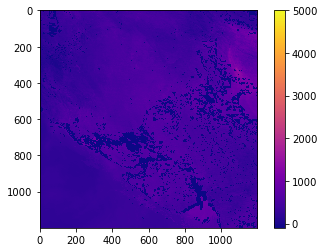

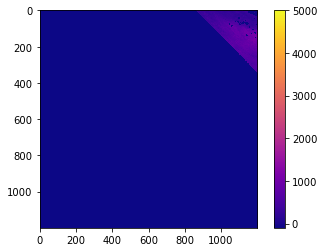

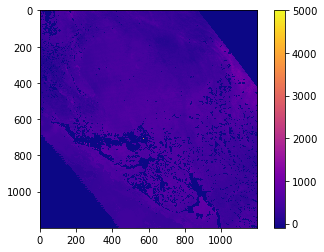

In [11]:
# Inspect one of the hdf files
test_hdf_file_path = os.path.join("train", "20180203T055000_maiac_dl_0.hdf")
gdal_dataset = print_hdf_file_content(test_hdf_file_path)
# Plot one of the fields of the hdf file
plot_raster_layers(gdal_dataset, field=0)

In [12]:
features, labels = generate_features(train_labels, "train", band=1)

Granule ID:  20180201T191000_maiac_la_0.hdf
Granule ID:  20180201T191000_maiac_la_0.hdf
Granule ID:  20180201T191000_maiac_la_0.hdf
Granule ID:  20180201T191000_maiac_la_0.hdf
Granule ID:  20180201T191000_maiac_la_0.hdf
Granule ID:  20180201T191000_maiac_la_0.hdf
Granule ID:  20180201T191000_maiac_la_0.hdf
Granule ID:  20180201T191000_maiac_la_0.hdf
Granule ID:  20180201T191000_maiac_la_0.hdf
Granule ID:  20180201T191000_maiac_la_0.hdf
Granule ID:  20180201T191000_maiac_la_0.hdf
Granule ID:  20180201T191000_maiac_la_0.hdf
Granule ID:  20180201T024000_maiac_tpe_0.hdf
Granule ID:  20180201T042000_maiac_tpe_0.hdf
Granule ID:  20180201T024000_maiac_tpe_0.hdf
Granule ID:  20180201T042000_maiac_tpe_0.hdf
Granule ID:  20180201T024000_maiac_tpe_0.hdf
Granule ID:  20180201T042000_maiac_tpe_0.hdf
Granule ID:  20180201T024000_maiac_tpe_0.hdf
Granule ID:  20180201T042000_maiac_tpe_0.hdf
Granule ID:  20180201T024000_maiac_tpe_0.hdf
Granule ID:  20180201T042000_maiac_tpe_0.hdf
Granule ID:  20180201T

Min PM2.5 value in train dataset: 0.4
List of row index matches: [56]
Granule ID:  20180203T203000_maiac_la_0.hdf
('HDF4_EOS:EOS_GRID:"train\\20180203T203000_maiac_la_0.hdf":grid1km:Optical_Depth_047', '[5x1200x1200] Optical_Depth_047 grid1km (16-bit integer)')
('HDF4_EOS:EOS_GRID:"train\\20180203T203000_maiac_la_0.hdf":grid1km:Optical_Depth_055', '[5x1200x1200] Optical_Depth_055 grid1km (16-bit integer)')
('HDF4_EOS:EOS_GRID:"train\\20180203T203000_maiac_la_0.hdf":grid1km:AOD_Uncertainty', '[5x1200x1200] AOD_Uncertainty grid1km (16-bit integer)')
('HDF4_EOS:EOS_GRID:"train\\20180203T203000_maiac_la_0.hdf":grid1km:FineModeFraction', '[5x1200x1200] FineModeFraction grid1km (16-bit integer)')
('HDF4_EOS:EOS_GRID:"train\\20180203T203000_maiac_la_0.hdf":grid1km:Column_WV', '[5x1200x1200] Column_WV grid1km (16-bit integer)')
('HDF4_EOS:EOS_GRID:"train\\20180203T203000_maiac_la_0.hdf":grid1km:AOD_QA', '[5x1200x1200] AOD_QA grid1km (16-bit unsigned integer)')
('HDF4_EOS:EOS_GRID:"train\\20180

C:\Users\zixiangloh\anaconda3\lib\site-packages\pandas\core\indexes\base.py:4616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


Field dimensions: (5, 1200, 1200)


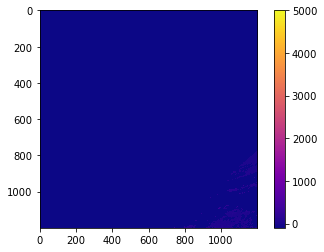

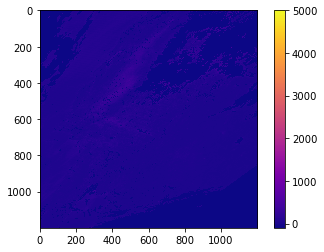

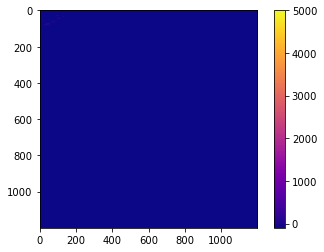

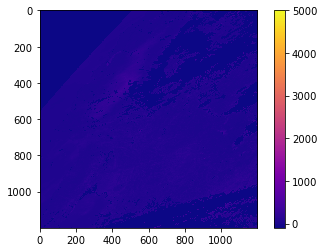

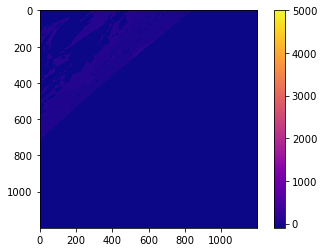

In [13]:
min_label = np.amin(labels)
print("Min PM2.5 value in train dataset:", min_label)
idx = train_labels.index[[train_labels["value"] == min_label]].tolist()
print("List of row index matches:", idx)
feature = fetch_training_features(train_labels.iloc[idx[0]]["grid_id"], train_labels.iloc[idx[0]]["datetime"], "train", field=0, band=1)
gdal_dataset = print_hdf_file_content(os.path.join("train", "20180203T203000_maiac_la_0.hdf"))
plot_raster_layers(gdal_dataset, field=0)

Max PM2.5 value in train dataset: 165.875
List of row index matches: [75]
Granule ID:  20180203T055000_maiac_dl_0.hdf
('HDF4_EOS:EOS_GRID:"train\\20180203T055000_maiac_dl_0.hdf":grid1km:Optical_Depth_047', '[3x1200x1200] Optical_Depth_047 grid1km (16-bit integer)')
('HDF4_EOS:EOS_GRID:"train\\20180203T055000_maiac_dl_0.hdf":grid1km:Optical_Depth_055', '[3x1200x1200] Optical_Depth_055 grid1km (16-bit integer)')
('HDF4_EOS:EOS_GRID:"train\\20180203T055000_maiac_dl_0.hdf":grid1km:AOD_Uncertainty', '[3x1200x1200] AOD_Uncertainty grid1km (16-bit integer)')
('HDF4_EOS:EOS_GRID:"train\\20180203T055000_maiac_dl_0.hdf":grid1km:FineModeFraction', '[3x1200x1200] FineModeFraction grid1km (16-bit integer)')
('HDF4_EOS:EOS_GRID:"train\\20180203T055000_maiac_dl_0.hdf":grid1km:Column_WV', '[3x1200x1200] Column_WV grid1km (16-bit integer)')
('HDF4_EOS:EOS_GRID:"train\\20180203T055000_maiac_dl_0.hdf":grid1km:AOD_QA', '[3x1200x1200] AOD_QA grid1km (16-bit unsigned integer)')
('HDF4_EOS:EOS_GRID:"train\\2

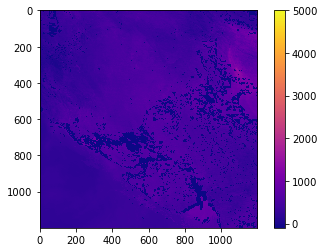

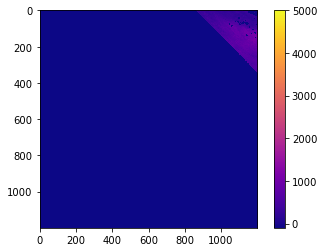

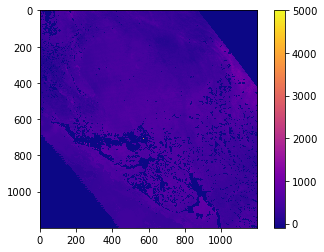

In [14]:
max_label = np.amax(labels)
print("Max PM2.5 value in train dataset:", max_label)
idx = train_labels.index[[train_labels["value"] == max_label]].tolist()
print("List of row index matches:", idx)
feature = fetch_training_features(train_labels.iloc[idx[0]]["grid_id"], train_labels.iloc[idx[0]]["datetime"], "train", field=0, band=1)
gdal_dataset = print_hdf_file_content(os.path.join("train", "20180203T055000_maiac_dl_0.hdf"))
plot_raster_layers(gdal_dataset, field=0)

In [15]:
print(features.shape)
print(labels.shape)
print("First Feature:\n", features[0])
print("First Label:", labels[0])

features_flat = (features[0]).flatten()
print("Max value in feature:", np.amax(features_flat))
print("Min value in feature excluding fill:", np.amin(features_flat[features_flat != field_fill_min_max[0]["fill"]]))
# hist, bins = np.histogram(features_flat, bins=1000)
# print(hist)
# print(bins)
# plt.hist(hist, bins) 
# plt.title("Distribution of Data Histogram")
# plt.xlim([-40000, -20000])
# plt.ylim([0, 2000000])
# plt.show()

(100, 1200, 1200)
(100,)
First Feature:
 [[-28672. -28672. -28672. ... -28672. -28672. -28672.]
 [-28672. -28672. -28672. ... -28672. -28672. -28672.]
 [-28672. -28672. -28672. ... -28672. -28672. -28672.]
 ...
 [-28672. -28672. -28672. ... -28672. -28672. -28672.]
 [-28672. -28672. -28672. ... -28672. -28672. -28672.]
 [-28672. -28672. -28672. ... -28672. -28672. -28672.]]
First Label: 11.4
Max value in feature: 497.0
Min value in feature excluding fill: 19.0


In [16]:
def custom_minmax_scaler(features, lower_margin=2, use_fill=False, field=0):
    if not use_fill:
        X_min = field_fill_min_max[0]["min"]
    else:
        X_min = field_fill_min_max[0]["fill"]
    X_min -= lower_margin
    X_max = field_fill_min_max[0]["max"]
    features_normalized = (features - X_min) / (X_max - X_min)
    if not use_fill:
        features_normalized[features_normalized < 0] = 0  # We set the fill values to 0
    return features_normalized

In [17]:
# Without scaling, the loss is high ~5K.
# I wrote this customer minmax scaler using a simple concept, we add some margin around the lowest valid value 
# (default margin=2), and set all the fill values to 0. This way all the features should be within 0-1, with 
# a large population of the data be 0s (for fills). 
# I noticed that this gives a much better fit (loss drops to around ~400-500).

features_norm = custom_minmax_scaler(features)
print(features_norm.shape)
print(labels.shape)
print(features_norm[0])

(100, 1200, 1200)
(100,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [18]:
# Simple Single Conv Layer to Dense Output Model (Tunable filter)
# Single Band Input (1200 x 1200)

def cnn_single_band_model(filters=4):  # 1200 x 1200 from one band model
    model = Sequential()
    model.add(Conv2D(filters, (3, 3), activation='relu', input_shape=(1200, 1200, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))  # Last layer relu (This last layer cannot be linear, otherwise loss increases)
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = cnn_single_band_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1198, 1198, 4)     40        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 599, 599, 4)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1435204)           0         
                                                                 
 dense (Dense)               (None, 1)                 1435205   
                                                                 
Total params: 1,435,245
Trainable params: 1,435,245
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Using Epoch=100, Batch_Size=5, Loss is around 400-500
history = model.fit(features_norm, labels, epochs=100, batch_size=5)

Epoch 1/100
20/20 [==============================] - 13s 650ms/step - loss: 6358.4438
Epoch 2/100
20/20 [==============================] - 13s 632ms/step - loss: 5335.6963
Epoch 3/100
20/20 [==============================] - 13s 645ms/step - loss: 4861.8042
Epoch 4/100
20/20 [==============================] - 13s 644ms/step - loss: 4544.3408
Epoch 5/100
20/20 [==============================] - 13s 647ms/step - loss: 4377.0620
Epoch 6/100
20/20 [==============================] - 13s 644ms/step - loss: 4256.8545
Epoch 7/100
20/20 [==============================] - 13s 631ms/step - loss: 4201.4946
Epoch 8/100
20/20 [==============================] - 13s 636ms/step - loss: 4182.8989
Epoch 9/100
20/20 [==============================] - 13s 638ms/step - loss: 4197.1450
Epoch 10/100
20/20 [==============================] - 13s 643ms/step - loss: 4164.8008
Epoch 11/100
20/20 [==============================] - 13s 648ms/step - loss: 4163.7876
Epoch 12/100
20/20 [==============================] 

20/20 [==============================] - 13s 647ms/step - loss: 3967.8997
Epoch 96/100
20/20 [==============================] - 13s 636ms/step - loss: 3981.5369
Epoch 97/100
20/20 [==============================] - 13s 653ms/step - loss: 4002.6562
Epoch 98/100
20/20 [==============================] - 13s 630ms/step - loss: 3994.4407
Epoch 99/100
20/20 [==============================] - 13s 641ms/step - loss: 3978.2009
Epoch 100/100
20/20 [==============================] - 13s 635ms/step - loss: 3969.1338


In [ ]:
# Second model, we add more filters to see what happens
model_2 = cnn_single_band_model(filters=16)
model_2.summary()

In [ ]:
history_2 = model_2.fit(features_norm, labels, epochs=100, batch_size=5)

In [ ]:
# Check and see what are the optimizer configurations
print(model_2.optimizer.get_config())
print(model.optimizer.get_config())

In [62]:
# The first model seems to have lower loss. Second model doesn't work as well. 
# We'll use the first model to do prediction and see how well we fare.

# Instead of taking in all the data structure, we take in 1K at a time and predict
# That way we won't run into memory issues
total_rows = len((submission_format.index))
num_1k_rows = total_rows // 1000
# num_1k_rows = 4
remainder_rows = total_rows % 1000

submission_format = pd.read_csv("submission_format.csv")
submission_format.head()

for loop_cnt in range(0, num_1k_rows):
    print("Current Loop:", loop_cnt)
    start_idx = 1000*loop_cnt
    stop_idx = 1000*(loop_cnt + 1)
    submission_format_subset = submission_format.iloc[start_idx:stop_idx]
#     print(submission_format_subset.head())
#     print(submission_format_subset.tail())
    features, labels = generate_features(submission_format_subset, "test", band=1)
    labels_pred = model.predict(features)
    labels_pred = np.squeeze(labels_pred)
    submission_format.loc[start_idx:(stop_idx-1), 'value'] = labels_pred

# The last loop (< 1K)
start_idx = 1000*(num_1k_rows)
stop_idx = 1000*(num_1k_rows) + remainder_rows + 1
submission_format_subset = submission_format.iloc[start_idx:stop_idx]
# print(submission_format_subset.head())
# print(submission_format_subset.tail())
features, labels = generate_features(submission_format_subset, "test", band=1)
labels_pred = model.predict(features)
labels_pred = np.squeeze(labels_pred)
submission_format.loc[start_idx:(stop_idx-1), 'value'] = labels_pred

submission_format.to_csv("model_1_prediction_submission.csv", index=False)

Current Loop: 0
Granule ID:  20170107T032000_maiac_tpe_0.hdf
Granule ID:  20170107T032000_maiac_tpe_1.hdf
Granule ID:  20170107T032000_maiac_tpe_0.hdf
Granule ID:  20170107T032000_maiac_tpe_1.hdf
Granule ID:  20170107T032000_maiac_tpe_0.hdf
Granule ID:  20170107T032000_maiac_tpe_1.hdf
Granule ID:  20170107T032000_maiac_tpe_0.hdf
Granule ID:  20170107T032000_maiac_tpe_1.hdf
Granule ID:  20170107T032000_maiac_tpe_0.hdf
Granule ID:  20170107T032000_maiac_tpe_1.hdf
Granule ID:  20170108T202500_maiac_la_0.hdf
Granule ID:  20170108T202500_maiac_la_0.hdf
Granule ID:  20170108T202500_maiac_la_0.hdf
Granule ID:  20170108T202500_maiac_la_0.hdf
Granule ID:  20170108T202500_maiac_la_0.hdf
Granule ID:  20170108T202500_maiac_la_0.hdf
Granule ID:  20170108T202500_maiac_la_0.hdf
Granule ID:  20170108T202500_maiac_la_0.hdf
Granule ID:  20170108T202500_maiac_la_0.hdf
Granule ID:  20170108T202500_maiac_la_0.hdf
Granule ID:  20170108T202500_maiac_la_0.hdf
Granule ID:  20170108T202500_maiac_la_0.hdf
Granul

Granule ID:  20170116T031500_maiac_tpe_0.hdf
Granule ID:  20170116T031500_maiac_tpe_1.hdf
Granule ID:  20170116T031500_maiac_tpe_0.hdf
Granule ID:  20170116T031500_maiac_tpe_1.hdf
Granule ID:  20170117T202000_maiac_la_0.hdf
Granule ID:  20170117T202000_maiac_la_0.hdf
Granule ID:  20170117T202000_maiac_la_0.hdf
Granule ID:  20170117T202000_maiac_la_0.hdf
Granule ID:  20170117T202000_maiac_la_0.hdf
Granule ID:  20170117T202000_maiac_la_0.hdf
Granule ID:  20170117T202000_maiac_la_0.hdf
Granule ID:  20170117T202000_maiac_la_0.hdf
Granule ID:  20170117T202000_maiac_la_0.hdf
Granule ID:  20170117T202000_maiac_la_0.hdf
Granule ID:  20170117T202000_maiac_la_0.hdf
Granule ID:  20170117T035500_maiac_tpe_0.hdf
Granule ID:  20170117T022000_maiac_tpe_0.hdf
Granule ID:  20170117T035500_maiac_tpe_0.hdf
Granule ID:  20170117T022000_maiac_tpe_0.hdf
Granule ID:  20170117T035500_maiac_tpe_0.hdf
Granule ID:  20170117T022000_maiac_tpe_0.hdf
Granule ID:  20170117T035500_maiac_tpe_0.hdf
Granule ID:  20170117

Granule ID:  20170126T201500_maiac_la_0.hdf
Granule ID:  20170126T035000_maiac_tpe_0.hdf
Granule ID:  20170126T021000_maiac_tpe_0.hdf
Granule ID:  20170126T035000_maiac_tpe_0.hdf
Granule ID:  20170126T021000_maiac_tpe_0.hdf
Granule ID:  20170126T035000_maiac_tpe_0.hdf
Granule ID:  20170126T021000_maiac_tpe_0.hdf
Granule ID:  20170126T035000_maiac_tpe_0.hdf
Granule ID:  20170126T021000_maiac_tpe_0.hdf
Granule ID:  20170126T035000_maiac_tpe_0.hdf
Granule ID:  20170126T021000_maiac_tpe_0.hdf
Granule ID:  20170127T192000_maiac_la_0.hdf
Granule ID:  20170127T192000_maiac_la_0.hdf
Granule ID:  20170127T192000_maiac_la_0.hdf
Granule ID:  20170127T192000_maiac_la_0.hdf
Granule ID:  20170127T192000_maiac_la_0.hdf
Granule ID:  20170127T192000_maiac_la_0.hdf
Granule ID:  20170127T192000_maiac_la_0.hdf
Granule ID:  20170127T192000_maiac_la_0.hdf
Granule ID:  20170127T192000_maiac_la_0.hdf
Granule ID:  20170127T192000_maiac_la_0.hdf
Granule ID:  20170127T192000_maiac_la_0.hdf
Granule ID:  20170127T

Granule ID:  20170205T191500_maiac_la_0.hdf
Granule ID:  20170205T191500_maiac_la_0.hdf
Granule ID:  20170205T191500_maiac_la_0.hdf
Granule ID:  20170205T191500_maiac_la_0.hdf
Granule ID:  20170205T191500_maiac_la_0.hdf
Granule ID:  20170205T191500_maiac_la_0.hdf
Granule ID:  20170205T191500_maiac_la_0.hdf
Granule ID:  20170205T191500_maiac_la_0.hdf
Granule ID:  20170205T191500_maiac_la_0.hdf
Granule ID:  20170205T191500_maiac_la_0.hdf
Granule ID:  20170205T191500_maiac_la_0.hdf
Granule ID:  20170205T025000_maiac_tpe_0.hdf
Granule ID:  20170205T025000_maiac_tpe_1.hdf
Granule ID:  20170205T025000_maiac_tpe_0.hdf
Granule ID:  20170205T025000_maiac_tpe_1.hdf
Granule ID:  20170205T025000_maiac_tpe_0.hdf
Granule ID:  20170205T025000_maiac_tpe_1.hdf
Granule ID:  20170205T025000_maiac_tpe_0.hdf
Granule ID:  20170205T025000_maiac_tpe_1.hdf
Granule ID:  20170205T025000_maiac_tpe_0.hdf
Granule ID:  20170205T025000_maiac_tpe_1.hdf
Granule ID:  20170206T195500_maiac_la_0.hdf
Granule ID:  20170206T

Granule ID:  20170215T032500_maiac_tpe_0.hdf
Granule ID:  20170215T032500_maiac_tpe_1.hdf
Granule ID:  20170215T032500_maiac_tpe_0.hdf
Granule ID:  20170215T032500_maiac_tpe_1.hdf
Granule ID:  20170215T032500_maiac_tpe_0.hdf
Granule ID:  20170215T032500_maiac_tpe_1.hdf
Granule ID:  20170216T203000_maiac_la_0.hdf
Granule ID:  20170216T203000_maiac_la_0.hdf
Granule ID:  20170216T203000_maiac_la_0.hdf
Granule ID:  20170216T203000_maiac_la_0.hdf
Granule ID:  20170216T203000_maiac_la_0.hdf
Granule ID:  20170216T203000_maiac_la_0.hdf
Granule ID:  20170216T203000_maiac_la_0.hdf
Granule ID:  20170216T203000_maiac_la_0.hdf
Granule ID:  20170216T203000_maiac_la_0.hdf
Granule ID:  20170216T203000_maiac_la_0.hdf
Granule ID:  20170216T203000_maiac_la_0.hdf
Granule ID:  20170216T203000_maiac_la_0.hdf
Granule ID:  20170216T041000_maiac_tpe_0.hdf
Granule ID:  20170216T023000_maiac_tpe_0.hdf
Granule ID:  20170216T041000_maiac_tpe_0.hdf
Granule ID:  20170216T023000_maiac_tpe_0.hdf
Granule ID:  20170216T

Granule ID:  20170225T040000_maiac_tpe_0.hdf
Granule ID:  20170225T022500_maiac_tpe_0.hdf
Granule ID:  20170225T040000_maiac_tpe_0.hdf
Granule ID:  20170225T022500_maiac_tpe_0.hdf
Granule ID:  20170226T193000_maiac_la_0.hdf
Granule ID:  20170226T193000_maiac_la_0.hdf
Granule ID:  20170226T193000_maiac_la_0.hdf
Granule ID:  20170226T193000_maiac_la_0.hdf
Granule ID:  20170226T193000_maiac_la_0.hdf
Granule ID:  20170226T193000_maiac_la_0.hdf
Granule ID:  20170226T193000_maiac_la_0.hdf
Granule ID:  20170226T193000_maiac_la_0.hdf
Granule ID:  20170226T193000_maiac_la_0.hdf
Granule ID:  20170226T193000_maiac_la_0.hdf
Granule ID:  20170226T193000_maiac_la_0.hdf
Granule ID:  20170226T193000_maiac_la_0.hdf
Granule ID:  20170226T030500_maiac_tpe_0.hdf
Granule ID:  20170226T030500_maiac_tpe_1.hdf
Granule ID:  20170226T030500_maiac_tpe_0.hdf
Granule ID:  20170226T030500_maiac_tpe_1.hdf
Granule ID:  20170226T030500_maiac_tpe_0.hdf
Granule ID:  20170226T030500_maiac_tpe_1.hdf
Granule ID:  20170226T

Granule ID:  20170310T033000_maiac_tpe_0.hdf
Granule ID:  20170310T033000_maiac_tpe_1.hdf
Granule ID:  20170310T033000_maiac_tpe_0.hdf
Granule ID:  20170310T033000_maiac_tpe_1.hdf
Granule ID:  20170310T033000_maiac_tpe_0.hdf
Granule ID:  20170310T033000_maiac_tpe_1.hdf
Granule ID:  20170310T033000_maiac_tpe_0.hdf
Granule ID:  20170310T033000_maiac_tpe_1.hdf
Granule ID:  20170311T023500_maiac_tpe_0.hdf
Granule ID:  20170311T041500_maiac_tpe_0.hdf
Granule ID:  20170311T023500_maiac_tpe_0.hdf
Granule ID:  20170311T041500_maiac_tpe_0.hdf
Granule ID:  20170311T023500_maiac_tpe_0.hdf
Granule ID:  20170311T041500_maiac_tpe_0.hdf
Granule ID:  20170311T023500_maiac_tpe_0.hdf
Granule ID:  20170311T041500_maiac_tpe_0.hdf
Granule ID:  20170311T023500_maiac_tpe_0.hdf
Granule ID:  20170311T041500_maiac_tpe_0.hdf
Granule ID:  20170312T194500_maiac_la_0.hdf
Granule ID:  20170312T194500_maiac_la_0.hdf
Granule ID:  20170312T194500_maiac_la_0.hdf
Granule ID:  20170312T194500_maiac_la_0.hdf
Granule ID:  2

Granule ID:  20170320T203000_maiac_la_0.hdf
Granule ID:  20170320T203000_maiac_la_0.hdf
Granule ID:  20170320T041000_maiac_tpe_0.hdf
Granule ID:  20170320T023000_maiac_tpe_0.hdf
Granule ID:  20170320T041000_maiac_tpe_0.hdf
Granule ID:  20170320T023000_maiac_tpe_0.hdf
Granule ID:  20170320T041000_maiac_tpe_0.hdf
Granule ID:  20170320T023000_maiac_tpe_0.hdf
Granule ID:  20170320T041000_maiac_tpe_0.hdf
Granule ID:  20170320T023000_maiac_tpe_0.hdf
Granule ID:  20170320T041000_maiac_tpe_0.hdf
Granule ID:  20170320T023000_maiac_tpe_0.hdf
Granule ID:  20170321T194000_maiac_la_0.hdf
Granule ID:  20170321T194000_maiac_la_0.hdf
Granule ID:  20170321T194000_maiac_la_0.hdf
Granule ID:  20170321T194000_maiac_la_0.hdf
Granule ID:  20170321T194000_maiac_la_0.hdf
Granule ID:  20170321T194000_maiac_la_0.hdf
Granule ID:  20170321T194000_maiac_la_0.hdf
Granule ID:  20170321T194000_maiac_la_0.hdf
Granule ID:  20170321T194000_maiac_la_0.hdf
Granule ID:  20170321T194000_maiac_la_0.hdf
Granule ID:  20170321T

Granule ID:  20170331T201500_maiac_la_0.hdf
Granule ID:  20170331T201500_maiac_la_0.hdf
Granule ID:  20170331T201500_maiac_la_0.hdf
Granule ID:  20170331T201500_maiac_la_0.hdf
Granule ID:  20170331T201500_maiac_la_0.hdf
Granule ID:  20170331T035000_maiac_tpe_0.hdf
Granule ID:  20170331T021000_maiac_tpe_0.hdf
Granule ID:  20170331T035000_maiac_tpe_0.hdf
Granule ID:  20170331T021000_maiac_tpe_0.hdf
Granule ID:  20170331T035000_maiac_tpe_0.hdf
Granule ID:  20170331T021000_maiac_tpe_0.hdf
Granule ID:  20170331T035000_maiac_tpe_0.hdf
Granule ID:  20170331T021000_maiac_tpe_0.hdf
Granule ID:  20170331T035000_maiac_tpe_0.hdf
Granule ID:  20170331T021000_maiac_tpe_0.hdf
Granule ID:  20170401T025500_maiac_tpe_0.hdf
Granule ID:  20170401T025500_maiac_tpe_1.hdf
Granule ID:  20170401T025500_maiac_tpe_0.hdf
Granule ID:  20170401T025500_maiac_tpe_1.hdf
Granule ID:  20170401T025500_maiac_tpe_0.hdf
Granule ID:  20170401T025500_maiac_tpe_1.hdf
Granule ID:  20170401T025500_maiac_tpe_0.hdf
Granule ID:  20

Granule ID:  20170410T191500_maiac_la_0.hdf
Granule ID:  20170410T191500_maiac_la_0.hdf
Granule ID:  20170410T191500_maiac_la_0.hdf
Granule ID:  20170410T025000_maiac_tpe_0.hdf
Granule ID:  20170410T025000_maiac_tpe_1.hdf
Granule ID:  20170410T025000_maiac_tpe_0.hdf
Granule ID:  20170410T025000_maiac_tpe_1.hdf
Granule ID:  20170410T025000_maiac_tpe_0.hdf
Granule ID:  20170410T025000_maiac_tpe_1.hdf
Granule ID:  20170410T025000_maiac_tpe_0.hdf
Granule ID:  20170410T025000_maiac_tpe_1.hdf
Granule ID:  20170410T025000_maiac_tpe_0.hdf
Granule ID:  20170410T025000_maiac_tpe_1.hdf
Granule ID:  20170411T195500_maiac_la_0.hdf
Granule ID:  20170411T195500_maiac_la_0.hdf
Granule ID:  20170411T195500_maiac_la_0.hdf
Granule ID:  20170411T195500_maiac_la_0.hdf
Granule ID:  20170411T195500_maiac_la_0.hdf
Granule ID:  20170411T195500_maiac_la_0.hdf
Granule ID:  20170411T195500_maiac_la_0.hdf
Granule ID:  20170411T195500_maiac_la_0.hdf
Granule ID:  20170411T195500_maiac_la_0.hdf
Granule ID:  20170411T

Granule ID:  20170419T024000_maiac_tpe_0.hdf
Granule ID:  20170419T042000_maiac_tpe_0.hdf
Granule ID:  20170419T024000_maiac_tpe_0.hdf
Granule ID:  20170419T042000_maiac_tpe_0.hdf
Granule ID:  20170419T024000_maiac_tpe_0.hdf
Granule ID:  20170419T042000_maiac_tpe_0.hdf
Granule ID:  20170419T024000_maiac_tpe_0.hdf
Granule ID:  20170419T042000_maiac_tpe_0.hdf
Granule ID:  20170420T195000_maiac_la_0.hdf
Granule ID:  20170420T195000_maiac_la_0.hdf
Granule ID:  20170420T195000_maiac_la_0.hdf
Granule ID:  20170420T195000_maiac_la_0.hdf
Granule ID:  20170420T195000_maiac_la_0.hdf
Granule ID:  20170420T195000_maiac_la_0.hdf
Granule ID:  20170420T195000_maiac_la_0.hdf
Granule ID:  20170420T195000_maiac_la_0.hdf
Granule ID:  20170420T195000_maiac_la_0.hdf
Granule ID:  20170420T195000_maiac_la_0.hdf
Granule ID:  20170420T195000_maiac_la_0.hdf
Granule ID:  20170420T195000_maiac_la_0.hdf
Granule ID:  20170420T032500_maiac_tpe_0.hdf
Granule ID:  20170420T032500_maiac_tpe_1.hdf
Granule ID:  20170420T

Granule ID:  20170428T203500_maiac_la_0.hdf
Granule ID:  20170428T203500_maiac_la_0.hdf
Granule ID:  20170428T203500_maiac_la_0.hdf
Granule ID:  20170428T203500_maiac_la_0.hdf
Granule ID:  20170428T203500_maiac_la_0.hdf
Granule ID:  20170428T203500_maiac_la_0.hdf
Granule ID:  20170428T203500_maiac_la_0.hdf
Granule ID:  20170428T203500_maiac_la_0.hdf
Granule ID:  20170428T203500_maiac_la_0.hdf
Granule ID:  20170428T203500_maiac_la_0.hdf
Granule ID:  20170428T203500_maiac_la_0.hdf
Granule ID:  20170428T023500_maiac_tpe_0.hdf
Granule ID:  20170428T041500_maiac_tpe_0.hdf
Granule ID:  20170428T023500_maiac_tpe_0.hdf
Granule ID:  20170428T041500_maiac_tpe_0.hdf
Granule ID:  20170428T023500_maiac_tpe_0.hdf
Granule ID:  20170428T041500_maiac_tpe_0.hdf
Granule ID:  20170428T023500_maiac_tpe_0.hdf
Granule ID:  20170428T041500_maiac_tpe_0.hdf
Granule ID:  20170428T023500_maiac_tpe_0.hdf
Granule ID:  20170428T041500_maiac_tpe_0.hdf
Granule ID:  20170429T194500_maiac_la_0.hdf
Granule ID:  20170429T

Granule ID:  20170506T032500_maiac_tpe_0.hdf
Granule ID:  20170506T032500_maiac_tpe_1.hdf
Granule ID:  20170506T032500_maiac_tpe_0.hdf
Granule ID:  20170506T032500_maiac_tpe_1.hdf
Granule ID:  20170506T032500_maiac_tpe_0.hdf
Granule ID:  20170506T032500_maiac_tpe_1.hdf
Granule ID:  20170506T032500_maiac_tpe_0.hdf
Granule ID:  20170506T032500_maiac_tpe_1.hdf
Granule ID:  20170507T203000_maiac_la_0.hdf
Granule ID:  20170507T203000_maiac_la_0.hdf
Granule ID:  20170507T203000_maiac_la_0.hdf
Granule ID:  20170507T203000_maiac_la_0.hdf
Granule ID:  20170507T203000_maiac_la_0.hdf
Granule ID:  20170507T203000_maiac_la_0.hdf
Granule ID:  20170507T203000_maiac_la_0.hdf
Granule ID:  20170507T203000_maiac_la_0.hdf
Granule ID:  20170507T203000_maiac_la_0.hdf
Granule ID:  20170507T203000_maiac_la_0.hdf
Granule ID:  20170507T203000_maiac_la_0.hdf
Granule ID:  20170507T203000_maiac_la_0.hdf
Granule ID:  20170507T041000_maiac_tpe_0.hdf
Granule ID:  20170507T023000_maiac_tpe_0.hdf
Granule ID:  20170507T

Granule ID:  20170515T194500_maiac_la_0.hdf
Granule ID:  20170515T194500_maiac_la_0.hdf
Granule ID:  20170515T194500_maiac_la_0.hdf
Granule ID:  20170515T194500_maiac_la_0.hdf
Granule ID:  20170515T194500_maiac_la_0.hdf
Granule ID:  20170515T194500_maiac_la_0.hdf
Granule ID:  20170515T194500_maiac_la_0.hdf
Granule ID:  20170515T194500_maiac_la_0.hdf
Granule ID:  20170515T194500_maiac_la_0.hdf
Granule ID:  20170515T194500_maiac_la_0.hdf
Granule ID:  20170515T032000_maiac_tpe_0.hdf
Granule ID:  20170515T032000_maiac_tpe_1.hdf
Granule ID:  20170515T032000_maiac_tpe_0.hdf
Granule ID:  20170515T032000_maiac_tpe_1.hdf
Granule ID:  20170515T032000_maiac_tpe_0.hdf
Granule ID:  20170515T032000_maiac_tpe_1.hdf
Granule ID:  20170515T032000_maiac_tpe_0.hdf
Granule ID:  20170515T032000_maiac_tpe_1.hdf
Granule ID:  20170515T032000_maiac_tpe_0.hdf
Granule ID:  20170515T032000_maiac_tpe_1.hdf
Granule ID:  20170516T202500_maiac_la_0.hdf
Granule ID:  20170516T202500_maiac_la_0.hdf
Granule ID:  20170516T

Granule ID:  20170523T203000_maiac_la_0.hdf
Granule ID:  20170523T041000_maiac_tpe_0.hdf
Granule ID:  20170523T023000_maiac_tpe_0.hdf
Granule ID:  20170523T041000_maiac_tpe_0.hdf
Granule ID:  20170523T023000_maiac_tpe_0.hdf
Granule ID:  20170523T041000_maiac_tpe_0.hdf
Granule ID:  20170523T023000_maiac_tpe_0.hdf
Granule ID:  20170523T041000_maiac_tpe_0.hdf
Granule ID:  20170523T023000_maiac_tpe_0.hdf
Granule ID:  20170523T041000_maiac_tpe_0.hdf
Granule ID:  20170523T023000_maiac_tpe_0.hdf
Granule ID:  20170524T194000_maiac_la_0.hdf
Granule ID:  20170524T194000_maiac_la_0.hdf
Granule ID:  20170524T194000_maiac_la_0.hdf
Granule ID:  20170524T194000_maiac_la_0.hdf
Granule ID:  20170524T194000_maiac_la_0.hdf
Granule ID:  20170524T194000_maiac_la_0.hdf
Granule ID:  20170524T194000_maiac_la_0.hdf
Granule ID:  20170524T194000_maiac_la_0.hdf
Granule ID:  20170524T194000_maiac_la_0.hdf
Granule ID:  20170524T194000_maiac_la_0.hdf
Granule ID:  20170524T194000_maiac_la_0.hdf
Granule ID:  20170524T

Granule ID:  20170601T202500_maiac_la_0.hdf
Granule ID:  20170601T202500_maiac_la_0.hdf
Granule ID:  20170601T202500_maiac_la_0.hdf
Granule ID:  20170601T202500_maiac_la_0.hdf
Granule ID:  20170601T202500_maiac_la_0.hdf
Granule ID:  20170601T202500_maiac_la_0.hdf
Granule ID:  20170601T202500_maiac_la_0.hdf
Granule ID:  20170601T202500_maiac_la_0.hdf
Granule ID:  20170601T202500_maiac_la_0.hdf
Granule ID:  20170601T202500_maiac_la_0.hdf
Granule ID:  20170601T022500_maiac_tpe_0.hdf
Granule ID:  20170601T040000_maiac_tpe_0.hdf
Granule ID:  20170601T022500_maiac_tpe_0.hdf
Granule ID:  20170601T040000_maiac_tpe_0.hdf
Granule ID:  20170601T022500_maiac_tpe_0.hdf
Granule ID:  20170601T040000_maiac_tpe_0.hdf
Granule ID:  20170601T022500_maiac_tpe_0.hdf
Granule ID:  20170601T040000_maiac_tpe_0.hdf
Granule ID:  20170601T022500_maiac_tpe_0.hdf
Granule ID:  20170601T040000_maiac_tpe_0.hdf
Granule ID:  20170602T193000_maiac_la_0.hdf
Granule ID:  20170602T193000_maiac_la_0.hdf
Granule ID:  20170602T

Granule ID:  20170609T031500_maiac_tpe_1.hdf
Granule ID:  20170609T031500_maiac_tpe_0.hdf
Granule ID:  20170609T031500_maiac_tpe_1.hdf
Granule ID:  20170610T202000_maiac_la_0.hdf
Granule ID:  20170610T202000_maiac_la_0.hdf
Granule ID:  20170610T202000_maiac_la_0.hdf
Granule ID:  20170610T202000_maiac_la_0.hdf
Granule ID:  20170610T202000_maiac_la_0.hdf
Granule ID:  20170610T202000_maiac_la_0.hdf
Granule ID:  20170610T202000_maiac_la_0.hdf
Granule ID:  20170610T202000_maiac_la_0.hdf
Granule ID:  20170610T202000_maiac_la_0.hdf
Granule ID:  20170610T202000_maiac_la_0.hdf
Granule ID:  20170610T202000_maiac_la_0.hdf
Granule ID:  20170610T202000_maiac_la_0.hdf
Granule ID:  20170610T022000_maiac_tpe_0.hdf
Granule ID:  20170610T035500_maiac_tpe_0.hdf
Granule ID:  20170610T022000_maiac_tpe_0.hdf
Granule ID:  20170610T035500_maiac_tpe_0.hdf
Granule ID:  20170610T022000_maiac_tpe_0.hdf
Granule ID:  20170610T035500_maiac_tpe_0.hdf
Granule ID:  20170610T022000_maiac_tpe_0.hdf
Granule ID:  20170610T

Granule ID:  20170622T191000_maiac_la_0.hdf
Granule ID:  20170623T195000_maiac_la_0.hdf
Granule ID:  20170623T195000_maiac_la_0.hdf
Granule ID:  20170623T195000_maiac_la_0.hdf
Granule ID:  20170623T195000_maiac_la_0.hdf
Granule ID:  20170623T195000_maiac_la_0.hdf
Granule ID:  20170623T195000_maiac_la_0.hdf
Granule ID:  20170623T195000_maiac_la_0.hdf
Granule ID:  20170623T195000_maiac_la_0.hdf
Granule ID:  20170623T195000_maiac_la_0.hdf
Granule ID:  20170623T195000_maiac_la_0.hdf
Granule ID:  20170623T195000_maiac_la_0.hdf
Granule ID:  20170623T195000_maiac_la_0.hdf
Granule ID:  20170624T203000_maiac_la_0.hdf
Granule ID:  20170624T203000_maiac_la_0.hdf
Granule ID:  20170624T203000_maiac_la_0.hdf
Granule ID:  20170624T203000_maiac_la_0.hdf
Granule ID:  20170624T203000_maiac_la_0.hdf
Granule ID:  20170624T203000_maiac_la_0.hdf
Granule ID:  20170624T203000_maiac_la_0.hdf
Granule ID:  20170624T203000_maiac_la_0.hdf
Granule ID:  20170624T203000_maiac_la_0.hdf
Granule ID:  20170624T203000_mai

Granule ID:  20170709T195000_maiac_la_0.hdf
Granule ID:  20170709T195000_maiac_la_0.hdf
Granule ID:  20170710T203000_maiac_la_0.hdf
Granule ID:  20170710T203000_maiac_la_0.hdf
Granule ID:  20170710T203000_maiac_la_0.hdf
Granule ID:  20170710T203000_maiac_la_0.hdf
Granule ID:  20170710T203000_maiac_la_0.hdf
Granule ID:  20170710T203000_maiac_la_0.hdf
Granule ID:  20170710T203000_maiac_la_0.hdf
Granule ID:  20170710T203000_maiac_la_0.hdf
Granule ID:  20170710T203000_maiac_la_0.hdf
Granule ID:  20170710T203000_maiac_la_0.hdf
Granule ID:  20170710T203000_maiac_la_0.hdf
Granule ID:  20170711T194000_maiac_la_0.hdf
Granule ID:  20170711T194000_maiac_la_0.hdf
Granule ID:  20170711T194000_maiac_la_0.hdf
Granule ID:  20170711T194000_maiac_la_0.hdf
Granule ID:  20170711T194000_maiac_la_0.hdf
Granule ID:  20170711T194000_maiac_la_0.hdf
Granule ID:  20170711T194000_maiac_la_0.hdf
Granule ID:  20170711T194000_maiac_la_0.hdf
Granule ID:  20170711T194000_maiac_la_0.hdf
Granule ID:  20170711T194000_mai

Granule ID:  20170815T201000_maiac_la_0.hdf
Granule ID:  20170815T201000_maiac_la_0.hdf
Granule ID:  20170815T201000_maiac_la_0.hdf
Granule ID:  20170815T201000_maiac_la_0.hdf
Granule ID:  20170815T201000_maiac_la_0.hdf
Granule ID:  20170815T201000_maiac_la_0.hdf
Granule ID:  20170815T201000_maiac_la_0.hdf
Granule ID:  20170815T201000_maiac_la_0.hdf
Granule ID:  20170816T191500_maiac_la_0.hdf
Granule ID:  20170816T191500_maiac_la_0.hdf
Granule ID:  20170816T191500_maiac_la_0.hdf
Granule ID:  20170816T191500_maiac_la_0.hdf
Granule ID:  20170816T191500_maiac_la_0.hdf
Granule ID:  20170816T191500_maiac_la_0.hdf
Granule ID:  20170816T191500_maiac_la_0.hdf
Granule ID:  20170816T191500_maiac_la_0.hdf
Granule ID:  20170816T191500_maiac_la_0.hdf
Granule ID:  20170816T191500_maiac_la_0.hdf
Granule ID:  20170816T191500_maiac_la_0.hdf
Granule ID:  20170816T191500_maiac_la_0.hdf
Granule ID:  20170817T195500_maiac_la_0.hdf
Granule ID:  20170817T195500_maiac_la_0.hdf
Granule ID:  20170817T195500_mai

Granule ID:  20170831T201000_maiac_la_0.hdf
Granule ID:  20170831T201000_maiac_la_0.hdf
Granule ID:  20170831T201000_maiac_la_0.hdf
Granule ID:  20170831T201000_maiac_la_0.hdf
Granule ID:  20170831T201000_maiac_la_0.hdf
Granule ID:  20170831T201000_maiac_la_0.hdf
Granule ID:  20170831T201000_maiac_la_0.hdf
Granule ID:  20170831T201000_maiac_la_0.hdf
Granule ID:  20170831T201000_maiac_la_0.hdf
Granule ID:  20170831T201000_maiac_la_0.hdf
Granule ID:  20170901T191500_maiac_la_0.hdf
Granule ID:  20170901T191500_maiac_la_0.hdf
Granule ID:  20170901T191500_maiac_la_0.hdf
Granule ID:  20170901T191500_maiac_la_0.hdf
Granule ID:  20170901T191500_maiac_la_0.hdf
Granule ID:  20170901T191500_maiac_la_0.hdf
Granule ID:  20170901T191500_maiac_la_0.hdf
Granule ID:  20170901T191500_maiac_la_0.hdf
Granule ID:  20170901T191500_maiac_la_0.hdf
Granule ID:  20170901T191500_maiac_la_0.hdf
Granule ID:  20170901T191500_maiac_la_0.hdf
Granule ID:  20170901T191500_maiac_la_0.hdf
Granule ID:  20170902T195500_mai

Granule ID:  20170913T194000_maiac_la_0.hdf
Granule ID:  20170913T194000_maiac_la_0.hdf
Granule ID:  20170913T194000_maiac_la_0.hdf
Granule ID:  20170913T031500_maiac_tpe_0.hdf
Granule ID:  20170913T031500_maiac_tpe_1.hdf
Granule ID:  20170913T031500_maiac_tpe_0.hdf
Granule ID:  20170913T031500_maiac_tpe_1.hdf
Granule ID:  20170913T031500_maiac_tpe_0.hdf
Granule ID:  20170913T031500_maiac_tpe_1.hdf
Granule ID:  20170913T031500_maiac_tpe_0.hdf
Granule ID:  20170913T031500_maiac_tpe_1.hdf
Granule ID:  20170913T031500_maiac_tpe_0.hdf
Granule ID:  20170913T031500_maiac_tpe_1.hdf
Granule ID:  20170913T031500_maiac_tpe_0.hdf
Granule ID:  20170913T031500_maiac_tpe_1.hdf
Granule ID:  20170913T031500_maiac_tpe_0.hdf
Granule ID:  20170913T031500_maiac_tpe_1.hdf
Granule ID:  20170913T063000_maiac_dl_0.hdf
Granule ID:  20170913T063000_maiac_dl_0.hdf
Granule ID:  20170914T202000_maiac_la_0.hdf
Granule ID:  20170914T202000_maiac_la_0.hdf
Granule ID:  20170914T202000_maiac_la_0.hdf
Granule ID:  20170

Granule ID:  20170919T055500_maiac_dl_0.hdf
Granule ID:  20170919T055500_maiac_dl_0.hdf
Granule ID:  20170919T055500_maiac_dl_0.hdf
Granule ID:  20170920T194500_maiac_la_0.hdf
Granule ID:  20170920T194500_maiac_la_0.hdf
Granule ID:  20170920T194500_maiac_la_0.hdf
Granule ID:  20170920T194500_maiac_la_0.hdf
Granule ID:  20170920T194500_maiac_la_0.hdf
Granule ID:  20170920T194500_maiac_la_0.hdf
Granule ID:  20170920T194500_maiac_la_0.hdf
Granule ID:  20170920T194500_maiac_la_0.hdf
Granule ID:  20170920T194500_maiac_la_0.hdf
Granule ID:  20170920T194500_maiac_la_0.hdf
Granule ID:  20170920T194500_maiac_la_0.hdf
Granule ID:  20170920T032000_maiac_tpe_0.hdf
Granule ID:  20170920T032000_maiac_tpe_1.hdf
Granule ID:  20170920T032000_maiac_tpe_0.hdf
Granule ID:  20170920T032000_maiac_tpe_1.hdf
Granule ID:  20170920T032000_maiac_tpe_0.hdf
Granule ID:  20170920T032000_maiac_tpe_1.hdf
Granule ID:  20170920T032000_maiac_tpe_0.hdf
Granule ID:  20170920T032000_maiac_tpe_1.hdf
Granule ID:  20170920T03

Granule ID:  20170926T024500_maiac_tpe_0.hdf
Granule ID:  20170926T042000_maiac_tpe_0.hdf
Granule ID:  20170926T024500_maiac_tpe_0.hdf
Granule ID:  20170926T042000_maiac_tpe_0.hdf
Granule ID:  20170926T024500_maiac_tpe_0.hdf
Granule ID:  20170926T042000_maiac_tpe_0.hdf
Granule ID:  20170926T024500_maiac_tpe_0.hdf
Granule ID:  20170926T042000_maiac_tpe_0.hdf
Granule ID:  20170926T024500_maiac_tpe_0.hdf
Granule ID:  20170926T042000_maiac_tpe_0.hdf
Granule ID:  20170926T024500_maiac_tpe_0.hdf
Granule ID:  20170926T042000_maiac_tpe_0.hdf
Granule ID:  20170926T024500_maiac_tpe_0.hdf
Granule ID:  20170926T042000_maiac_tpe_0.hdf
Granule ID:  20170926T060000_maiac_dl_0.hdf
Granule ID:  20170926T060000_maiac_dl_0.hdf
Granule ID:  20170926T060000_maiac_dl_0.hdf
Granule ID:  20170926T060000_maiac_dl_0.hdf
Granule ID:  20170926T060000_maiac_dl_0.hdf
Granule ID:  20170927T195000_maiac_la_0.hdf
Granule ID:  20170927T195000_maiac_la_0.hdf
Granule ID:  20170927T195000_maiac_la_0.hdf
Granule ID:  20170

Granule ID:  20171002T034500_maiac_tpe_0.hdf
Granule ID:  20171002T020500_maiac_tpe_0.hdf
Granule ID:  20171002T034500_maiac_tpe_0.hdf
Granule ID:  20171002T020500_maiac_tpe_0.hdf
Granule ID:  20171002T034500_maiac_tpe_0.hdf
Granule ID:  20171002T020500_maiac_tpe_0.hdf
Granule ID:  20171002T034500_maiac_tpe_0.hdf
Granule ID:  20171002T020500_maiac_tpe_0.hdf
Granule ID:  20171002T034500_maiac_tpe_0.hdf
Granule ID:  20171002T020500_maiac_tpe_0.hdf
Granule ID:  20171002T034500_maiac_tpe_0.hdf
Granule ID:  20171002T020500_maiac_tpe_0.hdf
Granule ID:  20171002T034500_maiac_tpe_0.hdf
Granule ID:  20171002T070000_maiac_dl_0.hdf
Granule ID:  20171002T070000_maiac_dl_0.hdf
Granule ID:  20171002T070000_maiac_dl_0.hdf
Granule ID:  20171002T070000_maiac_dl_0.hdf
Granule ID:  20171002T070000_maiac_dl_0.hdf
Granule ID:  20171003T191500_maiac_la_0.hdf
Granule ID:  20171003T191500_maiac_la_0.hdf
Granule ID:  20171003T191500_maiac_la_0.hdf
Granule ID:  20171003T191500_maiac_la_0.hdf
Granule ID:  201710

Granule ID:  20171008T030500_maiac_tpe_0.hdf
Granule ID:  20171008T030500_maiac_tpe_1.hdf
Granule ID:  20171008T030500_maiac_tpe_0.hdf
Granule ID:  20171008T030500_maiac_tpe_1.hdf
Granule ID:  20171008T030500_maiac_tpe_0.hdf
Granule ID:  20171008T030500_maiac_tpe_1.hdf
Granule ID:  20171008T030500_maiac_tpe_0.hdf
Granule ID:  20171008T030500_maiac_tpe_1.hdf
Granule ID:  20171008T030500_maiac_tpe_0.hdf
Granule ID:  20171008T030500_maiac_tpe_1.hdf
Granule ID:  20171008T030500_maiac_tpe_0.hdf
Granule ID:  20171008T030500_maiac_tpe_1.hdf
Granule ID:  20171008T030500_maiac_tpe_0.hdf
Granule ID:  20171008T030500_maiac_tpe_1.hdf
Granule ID:  20171008T062500_maiac_dl_0.hdf
Granule ID:  20171008T062500_maiac_dl_0.hdf
Granule ID:  20171008T062500_maiac_dl_0.hdf
Granule ID:  20171008T062500_maiac_dl_0.hdf
Granule ID:  20171008T062500_maiac_dl_0.hdf
Granule ID:  20171009T201500_maiac_la_0.hdf
Granule ID:  20171009T201500_maiac_la_0.hdf
Granule ID:  20171009T201500_maiac_la_0.hdf
Granule ID:  20171

Granule ID:  20171014T041000_maiac_tpe_0.hdf
Granule ID:  20171014T023000_maiac_tpe_0.hdf
Granule ID:  20171014T041000_maiac_tpe_0.hdf
Granule ID:  20171014T023000_maiac_tpe_0.hdf
Granule ID:  20171014T041000_maiac_tpe_0.hdf
Granule ID:  20171014T023000_maiac_tpe_0.hdf
Granule ID:  20171014T041000_maiac_tpe_0.hdf
Granule ID:  20171014T023000_maiac_tpe_0.hdf
Granule ID:  20171014T041000_maiac_tpe_0.hdf
Granule ID:  20171014T023000_maiac_tpe_0.hdf
Granule ID:  20171014T041000_maiac_tpe_0.hdf
Granule ID:  20171014T023000_maiac_tpe_0.hdf
Granule ID:  20171014T041000_maiac_tpe_0.hdf
Granule ID:  20171014T055000_maiac_dl_0.hdf
Granule ID:  20171014T055000_maiac_dl_0.hdf
Granule ID:  20171014T055000_maiac_dl_0.hdf
Granule ID:  20171014T055000_maiac_dl_0.hdf
Granule ID:  20171014T055000_maiac_dl_0.hdf
Granule ID:  20171015T194000_maiac_la_0.hdf
Granule ID:  20171015T194000_maiac_la_0.hdf
Granule ID:  20171015T194000_maiac_la_0.hdf
Granule ID:  20171015T194000_maiac_la_0.hdf
Granule ID:  201710

Current Loop: 4
Granule ID:  20171020T033000_maiac_tpe_0.hdf
Granule ID:  20171020T033000_maiac_tpe_1.hdf
Granule ID:  20171020T033000_maiac_tpe_0.hdf
Granule ID:  20171020T033000_maiac_tpe_1.hdf
Granule ID:  20171020T033000_maiac_tpe_0.hdf
Granule ID:  20171020T033000_maiac_tpe_1.hdf
Granule ID:  20171020T033000_maiac_tpe_0.hdf
Granule ID:  20171020T033000_maiac_tpe_1.hdf
Granule ID:  20171020T033000_maiac_tpe_0.hdf
Granule ID:  20171020T033000_maiac_tpe_1.hdf
Granule ID:  20171020T065000_maiac_dl_0.hdf
Granule ID:  20171020T065000_maiac_dl_0.hdf
Granule ID:  20171020T065000_maiac_dl_0.hdf
Granule ID:  20171020T065000_maiac_dl_0.hdf
Granule ID:  20171020T065000_maiac_dl_0.hdf
Granule ID:  20171021T204000_maiac_la_0.hdf
Granule ID:  20171021T204000_maiac_la_0.hdf
Granule ID:  20171021T204000_maiac_la_0.hdf
Granule ID:  20171021T204000_maiac_la_0.hdf
Granule ID:  20171021T204000_maiac_la_0.hdf
Granule ID:  20171021T204000_maiac_la_0.hdf
Granule ID:  20171021T204000_maiac_la_0.hdf
Granul

Granule ID:  20171026T025500_maiac_tpe_1.hdf
Granule ID:  20171026T025500_maiac_tpe_0.hdf
Granule ID:  20171026T025500_maiac_tpe_1.hdf
Granule ID:  20171026T025500_maiac_tpe_0.hdf
Granule ID:  20171026T025500_maiac_tpe_1.hdf
Granule ID:  20171026T025500_maiac_tpe_0.hdf
Granule ID:  20171026T025500_maiac_tpe_1.hdf
Granule ID:  20171026T025500_maiac_tpe_0.hdf
Granule ID:  20171026T025500_maiac_tpe_1.hdf
Granule ID:  20171026T061500_maiac_dl_0.hdf
Granule ID:  20171026T061500_maiac_dl_0.hdf
Granule ID:  20171026T061500_maiac_dl_0.hdf
Granule ID:  20171026T061500_maiac_dl_0.hdf
Granule ID:  20171027T200000_maiac_la_0.hdf
Granule ID:  20171027T200000_maiac_la_0.hdf
Granule ID:  20171027T200000_maiac_la_0.hdf
Granule ID:  20171027T200000_maiac_la_0.hdf
Granule ID:  20171027T200000_maiac_la_0.hdf
Granule ID:  20171027T200000_maiac_la_0.hdf
Granule ID:  20171027T200000_maiac_la_0.hdf
Granule ID:  20171027T200000_maiac_la_0.hdf
Granule ID:  20171027T200000_maiac_la_0.hdf
Granule ID:  20171027T2

Granule ID:  20171101T071500_maiac_dl_0.hdf
Granule ID:  20171101T071500_maiac_dl_0.hdf
Granule ID:  20171101T071500_maiac_dl_0.hdf
Granule ID:  20171101T071500_maiac_dl_0.hdf
Granule ID:  20171102T192500_maiac_la_0.hdf
Granule ID:  20171102T192500_maiac_la_0.hdf
Granule ID:  20171102T192500_maiac_la_0.hdf
Granule ID:  20171102T192500_maiac_la_0.hdf
Granule ID:  20171102T192500_maiac_la_0.hdf
Granule ID:  20171102T192500_maiac_la_0.hdf
Granule ID:  20171102T192500_maiac_la_0.hdf
Granule ID:  20171102T192500_maiac_la_0.hdf
Granule ID:  20171102T192500_maiac_la_0.hdf
Granule ID:  20171102T192500_maiac_la_0.hdf
Granule ID:  20171102T192500_maiac_la_0.hdf
Granule ID:  20171102T192500_maiac_la_0.hdf
Granule ID:  20171102T030000_maiac_tpe_0.hdf
Granule ID:  20171102T030000_maiac_tpe_1.hdf
Granule ID:  20171102T030000_maiac_tpe_0.hdf
Granule ID:  20171102T030000_maiac_tpe_1.hdf
Granule ID:  20171102T030000_maiac_tpe_0.hdf
Granule ID:  20171102T030000_maiac_tpe_1.hdf
Granule ID:  20171102T0300

Granule ID:  20171108T040000_maiac_tpe_0.hdf
Granule ID:  20171108T022500_maiac_tpe_0.hdf
Granule ID:  20171108T040000_maiac_tpe_0.hdf
Granule ID:  20171108T022500_maiac_tpe_0.hdf
Granule ID:  20171108T040000_maiac_tpe_0.hdf
Granule ID:  20171108T022500_maiac_tpe_0.hdf
Granule ID:  20171108T040000_maiac_tpe_0.hdf
Granule ID:  20171108T022500_maiac_tpe_0.hdf
Granule ID:  20171108T040000_maiac_tpe_0.hdf
Granule ID:  20171108T054000_maiac_dl_0.hdf
Granule ID:  20171108T054000_maiac_dl_0.hdf
Granule ID:  20171108T054000_maiac_dl_0.hdf
Granule ID:  20171108T054000_maiac_dl_0.hdf
Granule ID:  20171108T054000_maiac_dl_0.hdf
Granule ID:  20171109T193000_maiac_la_0.hdf
Granule ID:  20171109T193000_maiac_la_0.hdf
Granule ID:  20171109T193000_maiac_la_0.hdf
Granule ID:  20171109T193000_maiac_la_0.hdf
Granule ID:  20171109T193000_maiac_la_0.hdf
Granule ID:  20171109T193000_maiac_la_0.hdf
Granule ID:  20171109T193000_maiac_la_0.hdf
Granule ID:  20171109T193000_maiac_la_0.hdf
Granule ID:  20171109T1

Granule ID:  20171114T064500_maiac_dl_0.hdf
Granule ID:  20171114T064500_maiac_dl_0.hdf
Granule ID:  20171115T203000_maiac_la_0.hdf
Granule ID:  20171115T203000_maiac_la_0.hdf
Granule ID:  20171115T203000_maiac_la_0.hdf
Granule ID:  20171115T203000_maiac_la_0.hdf
Granule ID:  20171115T203000_maiac_la_0.hdf
Granule ID:  20171115T203000_maiac_la_0.hdf
Granule ID:  20171115T203000_maiac_la_0.hdf
Granule ID:  20171115T203000_maiac_la_0.hdf
Granule ID:  20171115T203000_maiac_la_0.hdf
Granule ID:  20171115T203000_maiac_la_0.hdf
Granule ID:  20171115T203000_maiac_la_0.hdf
Granule ID:  20171115T203000_maiac_la_0.hdf
Granule ID:  20171115T023000_maiac_tpe_0.hdf
Granule ID:  20171115T041000_maiac_tpe_0.hdf
Granule ID:  20171115T023000_maiac_tpe_0.hdf
Granule ID:  20171115T041000_maiac_tpe_0.hdf
Granule ID:  20171115T023000_maiac_tpe_0.hdf
Granule ID:  20171115T041000_maiac_tpe_0.hdf
Granule ID:  20171115T023000_maiac_tpe_0.hdf
Granule ID:  20171115T041000_maiac_tpe_0.hdf
Granule ID:  20171115T02

Granule ID:  20171121T033000_maiac_tpe_1.hdf
Granule ID:  20171121T033000_maiac_tpe_0.hdf
Granule ID:  20171121T033000_maiac_tpe_1.hdf
Granule ID:  20171121T033000_maiac_tpe_0.hdf
Granule ID:  20171121T033000_maiac_tpe_1.hdf
Granule ID:  20171121T033000_maiac_tpe_0.hdf
Granule ID:  20171121T033000_maiac_tpe_1.hdf
Granule ID:  20171121T033000_maiac_tpe_0.hdf
Granule ID:  20171121T033000_maiac_tpe_1.hdf
Granule ID:  20171121T033000_maiac_tpe_0.hdf
Granule ID:  20171121T033000_maiac_tpe_1.hdf
Granule ID:  20171121T065000_maiac_dl_0.hdf
Granule ID:  20171121T065000_maiac_dl_0.hdf
Granule ID:  20171121T065000_maiac_dl_0.hdf
Granule ID:  20171121T065000_maiac_dl_0.hdf
Granule ID:  20171121T065000_maiac_dl_0.hdf
Granule ID:  20171122T204000_maiac_la_0.hdf
Granule ID:  20171122T204000_maiac_la_0.hdf
Granule ID:  20171122T204000_maiac_la_0.hdf
Granule ID:  20171122T204000_maiac_la_0.hdf
Granule ID:  20171122T204000_maiac_la_0.hdf
Granule ID:  20171122T204000_maiac_la_0.hdf
Granule ID:  20171122

Granule ID:  20171127T061500_maiac_dl_0.hdf
Granule ID:  20171127T061500_maiac_dl_0.hdf
Granule ID:  20171127T061500_maiac_dl_0.hdf
Granule ID:  20171127T061500_maiac_dl_0.hdf
Granule ID:  20171127T061500_maiac_dl_0.hdf
Granule ID:  20171127T061500_maiac_dl_0.hdf
Granule ID:  20171127T061500_maiac_dl_0.hdf
Granule ID:  20171127T061500_maiac_dl_0.hdf
Granule ID:  20171127T061500_maiac_dl_0.hdf
Granule ID:  20171127T061500_maiac_dl_0.hdf
Granule ID:  20171128T200000_maiac_la_0.hdf
Granule ID:  20171128T200000_maiac_la_0.hdf
Granule ID:  20171128T200000_maiac_la_0.hdf
Granule ID:  20171128T200000_maiac_la_0.hdf
Granule ID:  20171128T200000_maiac_la_0.hdf
Granule ID:  20171128T200000_maiac_la_0.hdf
Granule ID:  20171128T200000_maiac_la_0.hdf
Granule ID:  20171128T200000_maiac_la_0.hdf
Granule ID:  20171128T200000_maiac_la_0.hdf
Granule ID:  20171128T200000_maiac_la_0.hdf
Granule ID:  20171128T200000_maiac_la_0.hdf
Granule ID:  20171128T200000_maiac_la_0.hdf
Granule ID:  20171128T034000_mai

Granule ID:  20171203T202000_maiac_la_0.hdf
Granule ID:  20171203T035500_maiac_tpe_0.hdf
Granule ID:  20171203T022000_maiac_tpe_0.hdf
Granule ID:  20171203T035500_maiac_tpe_0.hdf
Granule ID:  20171203T022000_maiac_tpe_0.hdf
Granule ID:  20171203T035500_maiac_tpe_0.hdf
Granule ID:  20171203T022000_maiac_tpe_0.hdf
Granule ID:  20171203T035500_maiac_tpe_0.hdf
Granule ID:  20171203T022000_maiac_tpe_0.hdf
Granule ID:  20171203T035500_maiac_tpe_0.hdf
Granule ID:  20171203T022000_maiac_tpe_0.hdf
Granule ID:  20171203T035500_maiac_tpe_0.hdf
Granule ID:  20171203T022000_maiac_tpe_0.hdf
Granule ID:  20171203T035500_maiac_tpe_0.hdf
Granule ID:  20171203T022000_maiac_tpe_0.hdf
Granule ID:  20171203T071500_maiac_dl_0.hdf
Granule ID:  20171203T071500_maiac_dl_0.hdf
Granule ID:  20171203T071500_maiac_dl_0.hdf
Granule ID:  20171203T071500_maiac_dl_0.hdf
Granule ID:  20171203T071500_maiac_dl_0.hdf
Granule ID:  20171203T071500_maiac_dl_0.hdf
Granule ID:  20171203T071500_maiac_dl_0.hdf
Granule ID:  20171

Granule ID:  20171208T023500_maiac_tpe_0.hdf
Granule ID:  20171208T041500_maiac_tpe_0.hdf
Granule ID:  20171208T023500_maiac_tpe_0.hdf
Granule ID:  20171208T041500_maiac_tpe_0.hdf
Granule ID:  20171208T023500_maiac_tpe_0.hdf
Granule ID:  20171208T041500_maiac_tpe_0.hdf
Granule ID:  20171208T023500_maiac_tpe_0.hdf
Granule ID:  20171208T041500_maiac_tpe_0.hdf
Granule ID:  20171208T055500_maiac_dl_0.hdf
Granule ID:  20171208T055500_maiac_dl_0.hdf
Granule ID:  20171208T055500_maiac_dl_0.hdf
Granule ID:  20171208T055500_maiac_dl_0.hdf
Granule ID:  20171208T055500_maiac_dl_0.hdf
Granule ID:  20171208T055500_maiac_dl_0.hdf
Granule ID:  20171208T055500_maiac_dl_0.hdf
Granule ID:  20171208T055500_maiac_dl_0.hdf
Granule ID:  20171208T055500_maiac_dl_0.hdf
Granule ID:  20171208T055500_maiac_dl_0.hdf
Granule ID:  20171208T055500_maiac_dl_0.hdf
Granule ID:  20171208T055500_maiac_dl_0.hdf
Granule ID:  20171209T194500_maiac_la_0.hdf
Granule ID:  20171209T194500_maiac_la_0.hdf
Granule ID:  20171209T19

Granule ID:  20171213T025500_maiac_tpe_0.hdf
Granule ID:  20171213T025500_maiac_tpe_1.hdf
Granule ID:  20171213T061000_maiac_dl_0.hdf
Granule ID:  20171213T061000_maiac_dl_0.hdf
Granule ID:  20171213T061000_maiac_dl_0.hdf
Granule ID:  20171213T061000_maiac_dl_0.hdf
Granule ID:  20171213T061000_maiac_dl_0.hdf
Granule ID:  20171213T061000_maiac_dl_0.hdf
Granule ID:  20171213T061000_maiac_dl_0.hdf
Granule ID:  20171213T061000_maiac_dl_0.hdf
Granule ID:  20171213T061000_maiac_dl_0.hdf
Granule ID:  20171213T061000_maiac_dl_0.hdf
Granule ID:  20171214T200000_maiac_la_0.hdf
Granule ID:  20171214T200000_maiac_la_0.hdf
Granule ID:  20171214T200000_maiac_la_0.hdf
Granule ID:  20171214T200000_maiac_la_0.hdf
Granule ID:  20171214T200000_maiac_la_0.hdf
Granule ID:  20171214T200000_maiac_la_0.hdf
Granule ID:  20171214T200000_maiac_la_0.hdf
Granule ID:  20171214T200000_maiac_la_0.hdf
Granule ID:  20171214T200000_maiac_la_0.hdf
Granule ID:  20171214T200000_maiac_la_0.hdf
Granule ID:  20171214T200000_m

Granule ID:  20171218T063000_maiac_dl_0.hdf
Granule ID:  20171218T063000_maiac_dl_0.hdf
Granule ID:  20171218T063000_maiac_dl_0.hdf
Granule ID:  20171218T063000_maiac_dl_0.hdf
Granule ID:  20171218T063000_maiac_dl_0.hdf
Granule ID:  20171219T202000_maiac_la_0.hdf
Granule ID:  20171219T202000_maiac_la_0.hdf
Granule ID:  20171219T202000_maiac_la_0.hdf
Granule ID:  20171219T202000_maiac_la_0.hdf
Granule ID:  20171219T202000_maiac_la_0.hdf
Granule ID:  20171219T202000_maiac_la_0.hdf
Granule ID:  20171219T202000_maiac_la_0.hdf
Granule ID:  20171219T202000_maiac_la_0.hdf
Granule ID:  20171219T202000_maiac_la_0.hdf
Granule ID:  20171219T202000_maiac_la_0.hdf
Granule ID:  20171219T202000_maiac_la_0.hdf
Granule ID:  20171219T202000_maiac_la_0.hdf
Granule ID:  20171219T035500_maiac_tpe_0.hdf
Granule ID:  20171219T022000_maiac_tpe_0.hdf
Granule ID:  20171219T035500_maiac_tpe_0.hdf
Granule ID:  20171219T022000_maiac_tpe_0.hdf
Granule ID:  20171219T035500_maiac_tpe_0.hdf
Granule ID:  20171219T02200

Granule ID:  20171223T065000_maiac_dl_0.hdf
Granule ID:  20171223T065000_maiac_dl_0.hdf
Granule ID:  20171223T065000_maiac_dl_0.hdf
Granule ID:  20171223T065000_maiac_dl_0.hdf
Granule ID:  20171223T065000_maiac_dl_0.hdf
Granule ID:  20171224T203500_maiac_la_0.hdf
Granule ID:  20171224T203500_maiac_la_0.hdf
Granule ID:  20171224T203500_maiac_la_0.hdf
Granule ID:  20171224T203500_maiac_la_0.hdf
Granule ID:  20171224T203500_maiac_la_0.hdf
Granule ID:  20171224T203500_maiac_la_0.hdf
Granule ID:  20171224T203500_maiac_la_0.hdf
Granule ID:  20171224T203500_maiac_la_0.hdf
Granule ID:  20171224T203500_maiac_la_0.hdf
Granule ID:  20171224T203500_maiac_la_0.hdf
Granule ID:  20171224T203500_maiac_la_0.hdf
Granule ID:  20171224T203500_maiac_la_0.hdf
Granule ID:  20171224T023500_maiac_tpe_0.hdf
Granule ID:  20171224T041500_maiac_tpe_0.hdf
Granule ID:  20171224T023500_maiac_tpe_0.hdf
Granule ID:  20171224T041500_maiac_tpe_0.hdf
Granule ID:  20171224T023500_maiac_tpe_0.hdf
Granule ID:  20171224T04150

Granule ID:  20171229T192000_maiac_la_0.hdf
Granule ID:  20171229T192000_maiac_la_0.hdf
Granule ID:  20171229T192000_maiac_la_0.hdf
Granule ID:  20171229T025500_maiac_tpe_0.hdf
Granule ID:  20171229T025500_maiac_tpe_1.hdf
Granule ID:  20171229T025500_maiac_tpe_0.hdf
Granule ID:  20171229T025500_maiac_tpe_1.hdf
Granule ID:  20171229T025500_maiac_tpe_0.hdf
Granule ID:  20171229T025500_maiac_tpe_1.hdf
Granule ID:  20171229T025500_maiac_tpe_0.hdf
Granule ID:  20171229T025500_maiac_tpe_1.hdf
Granule ID:  20171229T025500_maiac_tpe_0.hdf
Granule ID:  20171229T025500_maiac_tpe_1.hdf
Granule ID:  20171229T025500_maiac_tpe_0.hdf
Granule ID:  20171229T025500_maiac_tpe_1.hdf
Granule ID:  20171229T025500_maiac_tpe_0.hdf
Granule ID:  20171229T025500_maiac_tpe_1.hdf
Granule ID:  20171229T061000_maiac_dl_0.hdf
Granule ID:  20171229T061000_maiac_dl_0.hdf
Granule ID:  20171229T061000_maiac_dl_0.hdf
Granule ID:  20171229T061000_maiac_dl_0.hdf
Granule ID:  20171229T061000_maiac_dl_0.hdf
Granule ID:  20171

Granule ID:  20180103T194000_maiac_la_0.hdf
Granule ID:  20180103T194000_maiac_la_0.hdf
Granule ID:  20180103T194000_maiac_la_0.hdf
Granule ID:  20180103T194000_maiac_la_0.hdf
Granule ID:  20180103T194000_maiac_la_0.hdf
Granule ID:  20180103T194000_maiac_la_0.hdf
Granule ID:  20180103T194000_maiac_la_0.hdf
Granule ID:  20180103T031500_maiac_tpe_0.hdf
Granule ID:  20180103T031500_maiac_tpe_1.hdf
Granule ID:  20180103T031500_maiac_tpe_0.hdf
Granule ID:  20180103T031500_maiac_tpe_1.hdf
Granule ID:  20180103T031500_maiac_tpe_0.hdf
Granule ID:  20180103T031500_maiac_tpe_1.hdf
Granule ID:  20180103T031500_maiac_tpe_0.hdf
Granule ID:  20180103T031500_maiac_tpe_1.hdf
Granule ID:  20180103T031500_maiac_tpe_0.hdf
Granule ID:  20180103T031500_maiac_tpe_1.hdf
Granule ID:  20180103T031500_maiac_tpe_0.hdf
Granule ID:  20180103T031500_maiac_tpe_1.hdf
Granule ID:  20180103T031500_maiac_tpe_0.hdf
Granule ID:  20180103T031500_maiac_tpe_1.hdf
Granule ID:  20180103T063000_maiac_dl_0.hdf
Granule ID:  20180

Granule ID:  20180107T025000_maiac_tpe_1.hdf
Granule ID:  20170107T032000_maiac_tpe_0.hdf
Granule ID:  20170107T032000_maiac_tpe_1.hdf
Granule ID:  20180107T025000_maiac_tpe_0.hdf
Granule ID:  20180107T025000_maiac_tpe_1.hdf
Granule ID:  20170107T032000_maiac_tpe_0.hdf
Granule ID:  20170107T032000_maiac_tpe_1.hdf
Granule ID:  20180107T025000_maiac_tpe_0.hdf
Granule ID:  20180107T025000_maiac_tpe_1.hdf
Granule ID:  20170107T032000_maiac_tpe_0.hdf
Granule ID:  20170107T032000_maiac_tpe_1.hdf
Granule ID:  20180107T025000_maiac_tpe_0.hdf
Granule ID:  20180107T025000_maiac_tpe_1.hdf
Granule ID:  20170107T063500_maiac_dl_0.hdf
Granule ID:  20180107T060500_maiac_dl_0.hdf
Granule ID:  20170107T063500_maiac_dl_0.hdf
Granule ID:  20180107T060500_maiac_dl_0.hdf
Granule ID:  20170107T063500_maiac_dl_0.hdf
Granule ID:  20180107T060500_maiac_dl_0.hdf
Granule ID:  20170107T063500_maiac_dl_0.hdf
Granule ID:  20180107T060500_maiac_dl_0.hdf
Granule ID:  20170107T063500_maiac_dl_0.hdf
Granule ID:  201801

Granule ID:  20170110T035000_maiac_tpe_0.hdf
Granule ID:  20170110T021000_maiac_tpe_0.hdf
Granule ID:  20180110T032000_maiac_tpe_0.hdf
Granule ID:  20180110T032000_maiac_tpe_1.hdf
Granule ID:  20170110T035000_maiac_tpe_0.hdf
Granule ID:  20170110T021000_maiac_tpe_0.hdf
Granule ID:  20180110T032000_maiac_tpe_0.hdf
Granule ID:  20180110T032000_maiac_tpe_1.hdf
Granule ID:  20170110T035000_maiac_tpe_0.hdf
Granule ID:  20170110T021000_maiac_tpe_0.hdf
Granule ID:  20180110T032000_maiac_tpe_0.hdf
Granule ID:  20180110T032000_maiac_tpe_1.hdf
Granule ID:  20170110T035000_maiac_tpe_0.hdf
Granule ID:  20170110T021000_maiac_tpe_0.hdf
Granule ID:  20180110T032000_maiac_tpe_0.hdf
Granule ID:  20180110T032000_maiac_tpe_1.hdf
Granule ID:  20170110T035000_maiac_tpe_0.hdf
Granule ID:  20170110T021000_maiac_tpe_0.hdf
Granule ID:  20180110T032000_maiac_tpe_0.hdf
Granule ID:  20180110T032000_maiac_tpe_1.hdf
Granule ID:  20170110T035000_maiac_tpe_0.hdf
Granule ID:  20170110T021000_maiac_tpe_0.hdf
Granule ID

Granule ID:  20180112T062500_maiac_dl_0.hdf
Granule ID:  20170112T065500_maiac_dl_0.hdf
Granule ID:  20180112T062500_maiac_dl_0.hdf
Granule ID:  20170112T065500_maiac_dl_0.hdf
Granule ID:  20180112T062500_maiac_dl_0.hdf
Granule ID:  20170112T065500_maiac_dl_0.hdf
Granule ID:  20180112T062500_maiac_dl_0.hdf
Granule ID:  20170112T065500_maiac_dl_0.hdf
Granule ID:  20180112T062500_maiac_dl_0.hdf
Granule ID:  20170112T065500_maiac_dl_0.hdf
Granule ID:  20180112T062500_maiac_dl_0.hdf
Granule ID:  20170112T065500_maiac_dl_0.hdf
Granule ID:  20180112T062500_maiac_dl_0.hdf
Granule ID:  20170112T065500_maiac_dl_0.hdf
Granule ID:  20180112T062500_maiac_dl_0.hdf
Granule ID:  20170113T191000_maiac_la_0.hdf
Granule ID:  20180113T201500_maiac_la_0.hdf
Granule ID:  20170113T191000_maiac_la_0.hdf
Granule ID:  20180113T201500_maiac_la_0.hdf
Granule ID:  20170113T191000_maiac_la_0.hdf
Granule ID:  20180113T201500_maiac_la_0.hdf
Granule ID:  20170113T191000_maiac_la_0.hdf
Granule ID:  20180113T201500_mai

Granule ID:  20180115T200000_maiac_la_0.hdf
Granule ID:  20170115T203000_maiac_la_0.hdf
Granule ID:  20180115T200000_maiac_la_0.hdf
Granule ID:  20170115T041000_maiac_tpe_0.hdf
Granule ID:  20170115T023000_maiac_tpe_0.hdf
Granule ID:  20180115T033500_maiac_tpe_0.hdf
Granule ID:  20180115T034000_maiac_tpe_0.hdf
Granule ID:  20170115T041000_maiac_tpe_0.hdf
Granule ID:  20170115T023000_maiac_tpe_0.hdf
Granule ID:  20180115T033500_maiac_tpe_0.hdf
Granule ID:  20180115T034000_maiac_tpe_0.hdf
Granule ID:  20170115T041000_maiac_tpe_0.hdf
Granule ID:  20170115T023000_maiac_tpe_0.hdf
Granule ID:  20180115T033500_maiac_tpe_0.hdf
Granule ID:  20180115T034000_maiac_tpe_0.hdf
Granule ID:  20170115T041000_maiac_tpe_0.hdf
Granule ID:  20170115T023000_maiac_tpe_0.hdf
Granule ID:  20180115T033500_maiac_tpe_0.hdf
Granule ID:  20180115T034000_maiac_tpe_0.hdf
Granule ID:  20170115T041000_maiac_tpe_0.hdf
Granule ID:  20170115T023000_maiac_tpe_0.hdf
Granule ID:  20180115T033500_maiac_tpe_0.hdf
Granule ID:  

Granule ID:  20180117T064500_maiac_dl_0.hdf
Granule ID:  20170117T071500_maiac_dl_0.hdf
Granule ID:  20180117T064500_maiac_dl_0.hdf
Granule ID:  20170117T071500_maiac_dl_0.hdf
Granule ID:  20180117T064500_maiac_dl_0.hdf
Granule ID:  20170117T071500_maiac_dl_0.hdf
Granule ID:  20180117T064500_maiac_dl_0.hdf
Granule ID:  20170117T071500_maiac_dl_0.hdf
Granule ID:  20180117T064500_maiac_dl_0.hdf
Granule ID:  20170117T071500_maiac_dl_0.hdf
Granule ID:  20180117T064500_maiac_dl_0.hdf
Granule ID:  20170117T071500_maiac_dl_0.hdf
Granule ID:  20180117T064500_maiac_dl_0.hdf
Granule ID:  20170117T071500_maiac_dl_0.hdf
Granule ID:  20180117T064500_maiac_dl_0.hdf
Granule ID:  20170117T071500_maiac_dl_0.hdf
Granule ID:  20180117T064500_maiac_dl_0.hdf
Granule ID:  20170118T192500_maiac_la_0.hdf
Granule ID:  20180118T203000_maiac_la_0.hdf
Granule ID:  20170118T192500_maiac_la_0.hdf
Granule ID:  20180118T203000_maiac_la_0.hdf
Granule ID:  20170118T192500_maiac_la_0.hdf
Granule ID:  20180118T203000_mai

Granule ID:  20180120T202000_maiac_la_0.hdf
Granule ID:  20170120T191500_maiac_la_0.hdf
Granule ID:  20180120T202000_maiac_la_0.hdf
Granule ID:  20170120T025000_maiac_tpe_0.hdf
Granule ID:  20170120T025000_maiac_tpe_1.hdf
Granule ID:  20180120T022000_maiac_tpe_0.hdf
Granule ID:  20180120T035500_maiac_tpe_0.hdf
Granule ID:  20170120T025000_maiac_tpe_0.hdf
Granule ID:  20170120T025000_maiac_tpe_1.hdf
Granule ID:  20180120T022000_maiac_tpe_0.hdf
Granule ID:  20180120T035500_maiac_tpe_0.hdf
Granule ID:  20170120T025000_maiac_tpe_0.hdf
Granule ID:  20170120T025000_maiac_tpe_1.hdf
Granule ID:  20180120T022000_maiac_tpe_0.hdf
Granule ID:  20180120T035500_maiac_tpe_0.hdf
Granule ID:  20170120T025000_maiac_tpe_0.hdf
Granule ID:  20170120T025000_maiac_tpe_1.hdf
Granule ID:  20180120T022000_maiac_tpe_0.hdf
Granule ID:  20180120T035500_maiac_tpe_0.hdf
Granule ID:  20170120T025000_maiac_tpe_0.hdf
Granule ID:  20170120T025000_maiac_tpe_1.hdf
Granule ID:  20180120T022000_maiac_tpe_0.hdf
Granule ID:  

Granule ID:  20170122T055500_maiac_dl_0.hdf
Granule ID:  20180122T070000_maiac_dl_0.hdf
Granule ID:  20170122T055500_maiac_dl_0.hdf
Granule ID:  20180122T070000_maiac_dl_0.hdf
Granule ID:  20170122T055500_maiac_dl_0.hdf
Granule ID:  20180122T070000_maiac_dl_0.hdf
Granule ID:  20170122T055500_maiac_dl_0.hdf
Granule ID:  20180122T070000_maiac_dl_0.hdf
Granule ID:  20170123T194500_maiac_la_0.hdf
Granule ID:  20180123T191500_maiac_la_0.hdf
Granule ID:  20170123T194500_maiac_la_0.hdf
Granule ID:  20180123T191500_maiac_la_0.hdf
Granule ID:  20170123T194500_maiac_la_0.hdf
Granule ID:  20180123T191500_maiac_la_0.hdf
Granule ID:  20170123T194500_maiac_la_0.hdf
Granule ID:  20180123T191500_maiac_la_0.hdf
Granule ID:  20170123T194500_maiac_la_0.hdf
Granule ID:  20180123T191500_maiac_la_0.hdf
Granule ID:  20170123T194500_maiac_la_0.hdf
Granule ID:  20180123T191500_maiac_la_0.hdf
Granule ID:  20170123T194500_maiac_la_0.hdf
Granule ID:  20180123T191500_maiac_la_0.hdf
Granule ID:  20170123T194500_mai

Granule ID:  20180108T033000_maiac_tpe_1.hdf
Granule ID:  20210108T024000_maiac_tpe_0.hdf
Granule ID:  20210108T042000_maiac_tpe_0.hdf
Granule ID:  20170108T022500_maiac_tpe_0.hdf
Granule ID:  20170108T040000_maiac_tpe_0.hdf
Granule ID:  20180108T033000_maiac_tpe_0.hdf
Granule ID:  20180108T033000_maiac_tpe_1.hdf
Granule ID:  20210108T024000_maiac_tpe_0.hdf
Granule ID:  20210108T042000_maiac_tpe_0.hdf
Granule ID:  20170108T022500_maiac_tpe_0.hdf
Granule ID:  20170108T040000_maiac_tpe_0.hdf
Granule ID:  20180108T033000_maiac_tpe_0.hdf
Granule ID:  20180108T033000_maiac_tpe_1.hdf
Granule ID:  20210108T024000_maiac_tpe_0.hdf
Granule ID:  20210108T042000_maiac_tpe_0.hdf
Granule ID:  20170108T022500_maiac_tpe_0.hdf
Granule ID:  20170108T040000_maiac_tpe_0.hdf
Granule ID:  20180108T033000_maiac_tpe_0.hdf
Granule ID:  20180108T033000_maiac_tpe_1.hdf
Granule ID:  20210108T024000_maiac_tpe_0.hdf
Granule ID:  20210108T042000_maiac_tpe_0.hdf
Granule ID:  20170108T022500_maiac_tpe_0.hdf
Granule ID

Granule ID:  20180109T041500_maiac_tpe_0.hdf
Granule ID:  20210109T032500_maiac_tpe_0.hdf
Granule ID:  20210109T032500_maiac_tpe_1.hdf
Granule ID:  20170109T030500_maiac_tpe_0.hdf
Granule ID:  20170109T030500_maiac_tpe_1.hdf
Granule ID:  20180109T023500_maiac_tpe_0.hdf
Granule ID:  20180109T041500_maiac_tpe_0.hdf
Granule ID:  20210109T032500_maiac_tpe_0.hdf
Granule ID:  20210109T032500_maiac_tpe_1.hdf
Granule ID:  20170109T062500_maiac_dl_0.hdf
Granule ID:  20180109T055500_maiac_dl_0.hdf
Granule ID:  20210109T064000_maiac_dl_0.hdf
Granule ID:  20170109T062500_maiac_dl_0.hdf
Granule ID:  20180109T055500_maiac_dl_0.hdf
Granule ID:  20210109T064000_maiac_dl_0.hdf
Granule ID:  20170109T062500_maiac_dl_0.hdf
Granule ID:  20180109T055500_maiac_dl_0.hdf
Granule ID:  20210109T064000_maiac_dl_0.hdf
Granule ID:  20170109T062500_maiac_dl_0.hdf
Granule ID:  20180109T055500_maiac_dl_0.hdf
Granule ID:  20210109T064000_maiac_dl_0.hdf
Granule ID:  20170109T062500_maiac_dl_0.hdf
Granule ID:  20180109T0

Granule ID:  20180110T063500_maiac_dl_0.hdf
Granule ID:  20210110T054500_maiac_dl_0.hdf
Granule ID:  20170110T070500_maiac_dl_0.hdf
Granule ID:  20180110T063500_maiac_dl_0.hdf
Granule ID:  20210110T054500_maiac_dl_0.hdf
Granule ID:  20170110T070500_maiac_dl_0.hdf
Granule ID:  20180110T063500_maiac_dl_0.hdf
Granule ID:  20210110T054500_maiac_dl_0.hdf
Granule ID:  20170110T070500_maiac_dl_0.hdf
Granule ID:  20180110T063500_maiac_dl_0.hdf
Granule ID:  20210110T054500_maiac_dl_0.hdf
Granule ID:  20170110T070500_maiac_dl_0.hdf
Granule ID:  20180110T063500_maiac_dl_0.hdf
Granule ID:  20210110T054500_maiac_dl_0.hdf
Granule ID:  20170110T070500_maiac_dl_0.hdf
Granule ID:  20180110T063500_maiac_dl_0.hdf
Granule ID:  20210110T054500_maiac_dl_0.hdf
Granule ID:  20170110T070500_maiac_dl_0.hdf
Granule ID:  20180110T063500_maiac_dl_0.hdf
Granule ID:  20210110T054500_maiac_dl_0.hdf
Granule ID:  20170110T070500_maiac_dl_0.hdf
Granule ID:  20180110T063500_maiac_dl_0.hdf
Granule ID:  20210110T054500_mai

Granule ID:  20210111T063000_maiac_dl_0.hdf
Granule ID:  20170111T061000_maiac_dl_0.hdf
Granule ID:  20180111T054000_maiac_dl_0.hdf
Granule ID:  20210111T063000_maiac_dl_0.hdf
Granule ID:  20170111T061000_maiac_dl_0.hdf
Granule ID:  20180111T054000_maiac_dl_0.hdf
Granule ID:  20210111T063000_maiac_dl_0.hdf
Granule ID:  20170111T061000_maiac_dl_0.hdf
Granule ID:  20180111T054000_maiac_dl_0.hdf
Granule ID:  20210111T063000_maiac_dl_0.hdf
Granule ID:  20170111T061000_maiac_dl_0.hdf
Granule ID:  20180111T054000_maiac_dl_0.hdf
Granule ID:  20210111T063000_maiac_dl_0.hdf
Granule ID:  20170111T061000_maiac_dl_0.hdf
Granule ID:  20180111T054000_maiac_dl_0.hdf
Granule ID:  20210111T063000_maiac_dl_0.hdf
Granule ID:  20170111T061000_maiac_dl_0.hdf
Granule ID:  20180111T054000_maiac_dl_0.hdf
Granule ID:  20210111T063000_maiac_dl_0.hdf
Granule ID:  20170111T061000_maiac_dl_0.hdf
Granule ID:  20180111T054000_maiac_dl_0.hdf
Granule ID:  20210111T063000_maiac_dl_0.hdf
Granule ID:  20170111T061000_mai

Granule ID:  20170112T065500_maiac_dl_0.hdf
Granule ID:  20180112T062500_maiac_dl_0.hdf
Granule ID:  20210112T071500_maiac_dl_0.hdf
Granule ID:  20170112T065500_maiac_dl_0.hdf
Granule ID:  20180112T062500_maiac_dl_0.hdf
Granule ID:  20210112T071500_maiac_dl_0.hdf
Granule ID:  20170112T065500_maiac_dl_0.hdf
Granule ID:  20180112T062500_maiac_dl_0.hdf
Granule ID:  20210112T071500_maiac_dl_0.hdf
Granule ID:  20170112T065500_maiac_dl_0.hdf
Granule ID:  20180112T062500_maiac_dl_0.hdf
Granule ID:  20210112T071500_maiac_dl_0.hdf
Granule ID:  20170112T065500_maiac_dl_0.hdf
Granule ID:  20180112T062500_maiac_dl_0.hdf
Granule ID:  20210112T071500_maiac_dl_0.hdf
Granule ID:  20170112T065500_maiac_dl_0.hdf
Granule ID:  20180112T062500_maiac_dl_0.hdf
Granule ID:  20210112T071500_maiac_dl_0.hdf
Granule ID:  20170112T065500_maiac_dl_0.hdf
Granule ID:  20180112T062500_maiac_dl_0.hdf
Granule ID:  20210112T071500_maiac_dl_0.hdf
Granule ID:  20170112T065500_maiac_dl_0.hdf
Granule ID:  20180112T062500_mai

Granule ID:  20170113T060000_maiac_dl_0.hdf
Granule ID:  20180113T070500_maiac_dl_0.hdf
Granule ID:  20210113T062000_maiac_dl_0.hdf
Granule ID:  20170113T060000_maiac_dl_0.hdf
Granule ID:  20180113T070500_maiac_dl_0.hdf
Granule ID:  20210113T062000_maiac_dl_0.hdf
Granule ID:  20170114T195000_maiac_la_0.hdf
Granule ID:  20180114T192000_maiac_la_0.hdf
Granule ID:  20210114T200500_maiac_la_0.hdf
Granule ID:  20170114T195000_maiac_la_0.hdf
Granule ID:  20180114T192000_maiac_la_0.hdf
Granule ID:  20210114T200500_maiac_la_0.hdf
Granule ID:  20170114T195000_maiac_la_0.hdf
Granule ID:  20180114T192000_maiac_la_0.hdf
Granule ID:  20210114T200500_maiac_la_0.hdf
Granule ID:  20170114T195000_maiac_la_0.hdf
Granule ID:  20180114T192000_maiac_la_0.hdf
Granule ID:  20210114T200500_maiac_la_0.hdf
Granule ID:  20170114T195000_maiac_la_0.hdf
Granule ID:  20180114T192000_maiac_la_0.hdf
Granule ID:  20210114T200500_maiac_la_0.hdf
Granule ID:  20170114T195000_maiac_la_0.hdf
Granule ID:  20180114T192000_mai

Granule ID:  20180115T200000_maiac_la_0.hdf
Granule ID:  20210115T191500_maiac_la_0.hdf
Granule ID:  20170115T203000_maiac_la_0.hdf
Granule ID:  20180115T200000_maiac_la_0.hdf
Granule ID:  20210115T191500_maiac_la_0.hdf
Granule ID:  20170115T203000_maiac_la_0.hdf
Granule ID:  20180115T200000_maiac_la_0.hdf
Granule ID:  20210115T191500_maiac_la_0.hdf
Granule ID:  20170115T203000_maiac_la_0.hdf
Granule ID:  20180115T200000_maiac_la_0.hdf
Granule ID:  20210115T191500_maiac_la_0.hdf
Granule ID:  20170115T203000_maiac_la_0.hdf
Granule ID:  20180115T200000_maiac_la_0.hdf
Granule ID:  20210115T191500_maiac_la_0.hdf
Granule ID:  20170115T203000_maiac_la_0.hdf
Granule ID:  20180115T200000_maiac_la_0.hdf
Granule ID:  20210115T191500_maiac_la_0.hdf
Granule ID:  20170115T203000_maiac_la_0.hdf
Granule ID:  20180115T200000_maiac_la_0.hdf
Granule ID:  20210115T191500_maiac_la_0.hdf
Granule ID:  20170115T041000_maiac_tpe_0.hdf
Granule ID:  20170115T023000_maiac_tpe_0.hdf
Granule ID:  20180115T033500_m

Granule ID:  20170116T031500_maiac_tpe_0.hdf
Granule ID:  20170116T031500_maiac_tpe_1.hdf
Granule ID:  20180116T024000_maiac_tpe_0.hdf
Granule ID:  20180116T042000_maiac_tpe_0.hdf
Granule ID:  20210116T033000_maiac_tpe_0.hdf
Granule ID:  20210116T033000_maiac_tpe_1.hdf
Granule ID:  20170116T031500_maiac_tpe_0.hdf
Granule ID:  20170116T031500_maiac_tpe_1.hdf
Granule ID:  20180116T024000_maiac_tpe_0.hdf
Granule ID:  20180116T042000_maiac_tpe_0.hdf
Granule ID:  20210116T033000_maiac_tpe_0.hdf
Granule ID:  20210116T033000_maiac_tpe_1.hdf
Granule ID:  20170116T031500_maiac_tpe_0.hdf
Granule ID:  20170116T031500_maiac_tpe_1.hdf
Granule ID:  20180116T024000_maiac_tpe_0.hdf
Granule ID:  20180116T042000_maiac_tpe_0.hdf
Granule ID:  20210116T033000_maiac_tpe_0.hdf
Granule ID:  20210116T033000_maiac_tpe_1.hdf
Granule ID:  20170116T031500_maiac_tpe_0.hdf
Granule ID:  20170116T031500_maiac_tpe_1.hdf
Granule ID:  20180116T024000_maiac_tpe_0.hdf
Granule ID:  20180116T042000_maiac_tpe_0.hdf
Granule ID

Granule ID:  20210117T023500_maiac_tpe_0.hdf
Granule ID:  20210117T041500_maiac_tpe_0.hdf
Granule ID:  20170117T035500_maiac_tpe_0.hdf
Granule ID:  20170117T022000_maiac_tpe_0.hdf
Granule ID:  20180117T032500_maiac_tpe_0.hdf
Granule ID:  20180117T032500_maiac_tpe_1.hdf
Granule ID:  20210117T023500_maiac_tpe_0.hdf
Granule ID:  20210117T041500_maiac_tpe_0.hdf
Granule ID:  20170117T035500_maiac_tpe_0.hdf
Granule ID:  20170117T022000_maiac_tpe_0.hdf
Granule ID:  20180117T032500_maiac_tpe_0.hdf
Granule ID:  20180117T032500_maiac_tpe_1.hdf
Granule ID:  20210117T023500_maiac_tpe_0.hdf
Granule ID:  20210117T041500_maiac_tpe_0.hdf
Granule ID:  20170117T035500_maiac_tpe_0.hdf
Granule ID:  20170117T022000_maiac_tpe_0.hdf
Granule ID:  20180117T032500_maiac_tpe_0.hdf
Granule ID:  20180117T032500_maiac_tpe_1.hdf
Granule ID:  20210117T023500_maiac_tpe_0.hdf
Granule ID:  20210117T041500_maiac_tpe_0.hdf
Granule ID:  20170117T035500_maiac_tpe_0.hdf
Granule ID:  20170117T022000_maiac_tpe_0.hdf
Granule ID

Granule ID:  20210118T032000_maiac_tpe_0.hdf
Granule ID:  20210118T032000_maiac_tpe_1.hdf
Granule ID:  20170118T030000_maiac_tpe_0.hdf
Granule ID:  20170118T030000_maiac_tpe_1.hdf
Granule ID:  20180118T023000_maiac_tpe_0.hdf
Granule ID:  20180118T041000_maiac_tpe_0.hdf
Granule ID:  20210118T032000_maiac_tpe_0.hdf
Granule ID:  20210118T032000_maiac_tpe_1.hdf
Granule ID:  20170118T062000_maiac_dl_0.hdf
Granule ID:  20180118T055000_maiac_dl_0.hdf
Granule ID:  20210118T063500_maiac_dl_0.hdf
Granule ID:  20170118T062000_maiac_dl_0.hdf
Granule ID:  20180118T055000_maiac_dl_0.hdf
Granule ID:  20210118T063500_maiac_dl_0.hdf
Granule ID:  20170118T062000_maiac_dl_0.hdf
Granule ID:  20180118T055000_maiac_dl_0.hdf
Granule ID:  20210118T063500_maiac_dl_0.hdf
Granule ID:  20170118T062000_maiac_dl_0.hdf
Granule ID:  20180118T055000_maiac_dl_0.hdf
Granule ID:  20210118T063500_maiac_dl_0.hdf
Granule ID:  20170118T062000_maiac_dl_0.hdf
Granule ID:  20180118T055000_maiac_dl_0.hdf
Granule ID:  20210118T06

Granule ID:  20180119T063000_maiac_dl_0.hdf
Granule ID:  20210119T054000_maiac_dl_0.hdf
Granule ID:  20170119T070000_maiac_dl_0.hdf
Granule ID:  20180119T063000_maiac_dl_0.hdf
Granule ID:  20210119T054000_maiac_dl_0.hdf
Granule ID:  20170119T070000_maiac_dl_0.hdf
Granule ID:  20180119T063000_maiac_dl_0.hdf
Granule ID:  20210119T054000_maiac_dl_0.hdf
Granule ID:  20170119T070000_maiac_dl_0.hdf
Granule ID:  20180119T063000_maiac_dl_0.hdf
Granule ID:  20210119T054000_maiac_dl_0.hdf
Granule ID:  20170119T070000_maiac_dl_0.hdf
Granule ID:  20180119T063000_maiac_dl_0.hdf
Granule ID:  20210119T054000_maiac_dl_0.hdf
Granule ID:  20170119T070000_maiac_dl_0.hdf
Granule ID:  20180119T063000_maiac_dl_0.hdf
Granule ID:  20210119T054000_maiac_dl_0.hdf
Granule ID:  20170119T070000_maiac_dl_0.hdf
Granule ID:  20180119T063000_maiac_dl_0.hdf
Granule ID:  20210119T054000_maiac_dl_0.hdf
Granule ID:  20170119T070000_maiac_dl_0.hdf
Granule ID:  20180119T063000_maiac_dl_0.hdf
Granule ID:  20210119T054000_mai

Granule ID:  20210120T062500_maiac_dl_0.hdf
Granule ID:  20170120T060500_maiac_dl_0.hdf
Granule ID:  20180120T071500_maiac_dl_0.hdf
Granule ID:  20210120T062500_maiac_dl_0.hdf
Granule ID:  20170120T060500_maiac_dl_0.hdf
Granule ID:  20180120T071500_maiac_dl_0.hdf
Granule ID:  20210120T062500_maiac_dl_0.hdf
Granule ID:  20170120T060500_maiac_dl_0.hdf
Granule ID:  20180120T071500_maiac_dl_0.hdf
Granule ID:  20210120T062500_maiac_dl_0.hdf
Granule ID:  20170120T060500_maiac_dl_0.hdf
Granule ID:  20180120T071500_maiac_dl_0.hdf
Granule ID:  20210120T062500_maiac_dl_0.hdf
Granule ID:  20170120T060500_maiac_dl_0.hdf
Granule ID:  20180120T071500_maiac_dl_0.hdf
Granule ID:  20210120T062500_maiac_dl_0.hdf
Granule ID:  20170120T060500_maiac_dl_0.hdf
Granule ID:  20180120T071500_maiac_dl_0.hdf
Granule ID:  20210120T062500_maiac_dl_0.hdf
Granule ID:  20170120T060500_maiac_dl_0.hdf
Granule ID:  20180120T071500_maiac_dl_0.hdf
Granule ID:  20210120T062500_maiac_dl_0.hdf
Granule ID:  20170120T060500_mai

Granule ID:  20170121T065000_maiac_dl_0.hdf
Granule ID:  20180121T062000_maiac_dl_0.hdf
Granule ID:  20210121T070500_maiac_dl_0.hdf
Granule ID:  20170121T065000_maiac_dl_0.hdf
Granule ID:  20180121T062000_maiac_dl_0.hdf
Granule ID:  20210121T070500_maiac_dl_0.hdf
Granule ID:  20170121T065000_maiac_dl_0.hdf
Granule ID:  20180121T062000_maiac_dl_0.hdf
Granule ID:  20210121T070500_maiac_dl_0.hdf
Granule ID:  20170121T065000_maiac_dl_0.hdf
Granule ID:  20180121T062000_maiac_dl_0.hdf
Granule ID:  20210121T070500_maiac_dl_0.hdf
Granule ID:  20170121T065000_maiac_dl_0.hdf
Granule ID:  20180121T062000_maiac_dl_0.hdf
Granule ID:  20210121T070500_maiac_dl_0.hdf
Granule ID:  20170121T065000_maiac_dl_0.hdf
Granule ID:  20180121T062000_maiac_dl_0.hdf
Granule ID:  20210121T070500_maiac_dl_0.hdf
Granule ID:  20170121T065000_maiac_dl_0.hdf
Granule ID:  20180121T062000_maiac_dl_0.hdf
Granule ID:  20210121T070500_maiac_dl_0.hdf
Granule ID:  20170121T065000_maiac_dl_0.hdf
Granule ID:  20180121T062000_mai

Granule ID:  20170122T055500_maiac_dl_0.hdf
Granule ID:  20180122T070000_maiac_dl_0.hdf
Granule ID:  20210122T061000_maiac_dl_0.hdf
Granule ID:  20170122T055500_maiac_dl_0.hdf
Granule ID:  20180122T070000_maiac_dl_0.hdf
Granule ID:  20210122T061000_maiac_dl_0.hdf
Granule ID:  20170122T055500_maiac_dl_0.hdf
Granule ID:  20180122T070000_maiac_dl_0.hdf
Granule ID:  20210122T061000_maiac_dl_0.hdf
Granule ID:  20170122T055500_maiac_dl_0.hdf
Granule ID:  20180122T070000_maiac_dl_0.hdf
Granule ID:  20210122T061000_maiac_dl_0.hdf
Granule ID:  20170122T055500_maiac_dl_0.hdf
Granule ID:  20180122T070000_maiac_dl_0.hdf
Granule ID:  20210122T061000_maiac_dl_0.hdf
Granule ID:  20170122T055500_maiac_dl_0.hdf
Granule ID:  20180122T070000_maiac_dl_0.hdf
Granule ID:  20210122T061000_maiac_dl_0.hdf
Granule ID:  20170123T194500_maiac_la_0.hdf
Granule ID:  20180123T191500_maiac_la_0.hdf
Granule ID:  20210123T200000_maiac_la_0.hdf
Granule ID:  20170123T194500_maiac_la_0.hdf
Granule ID:  20180123T191500_mai

Granule ID:  20170124T202500_maiac_la_0.hdf
Granule ID:  20180124T195500_maiac_la_0.hdf
Granule ID:  20210124T190500_maiac_la_0.hdf
Granule ID:  20170124T202500_maiac_la_0.hdf
Granule ID:  20180124T195500_maiac_la_0.hdf
Granule ID:  20210124T190500_maiac_la_0.hdf
Granule ID:  20170124T202500_maiac_la_0.hdf
Granule ID:  20180124T195500_maiac_la_0.hdf
Granule ID:  20210124T190500_maiac_la_0.hdf
Granule ID:  20170124T202500_maiac_la_0.hdf
Granule ID:  20180124T195500_maiac_la_0.hdf
Granule ID:  20210124T190500_maiac_la_0.hdf
Granule ID:  20170124T202500_maiac_la_0.hdf
Granule ID:  20180124T195500_maiac_la_0.hdf
Granule ID:  20210124T190500_maiac_la_0.hdf
Granule ID:  20170124T202500_maiac_la_0.hdf
Granule ID:  20180124T195500_maiac_la_0.hdf
Granule ID:  20210124T190500_maiac_la_0.hdf
Granule ID:  20170124T202500_maiac_la_0.hdf
Granule ID:  20180124T195500_maiac_la_0.hdf
Granule ID:  20210124T190500_maiac_la_0.hdf
Granule ID:  20170124T202500_maiac_la_0.hdf
Granule ID:  20180124T195500_mai

Granule ID:  20210125T032500_maiac_tpe_1.hdf
Granule ID:  20170125T030500_maiac_tpe_0.hdf
Granule ID:  20170125T030500_maiac_tpe_1.hdf
Granule ID:  20210125T032500_maiac_tpe_0.hdf
Granule ID:  20210125T032500_maiac_tpe_1.hdf
Granule ID:  20170125T030500_maiac_tpe_0.hdf
Granule ID:  20170125T030500_maiac_tpe_1.hdf
Granule ID:  20210125T032500_maiac_tpe_0.hdf
Granule ID:  20210125T032500_maiac_tpe_1.hdf
Granule ID:  20170125T030500_maiac_tpe_0.hdf
Granule ID:  20170125T030500_maiac_tpe_1.hdf
Granule ID:  20210125T032500_maiac_tpe_0.hdf
Granule ID:  20210125T032500_maiac_tpe_1.hdf
Granule ID:  20170125T030500_maiac_tpe_0.hdf
Granule ID:  20170125T030500_maiac_tpe_1.hdf
Granule ID:  20210125T032500_maiac_tpe_0.hdf
Granule ID:  20210125T032500_maiac_tpe_1.hdf
Granule ID:  20170125T030500_maiac_tpe_0.hdf
Granule ID:  20170125T030500_maiac_tpe_1.hdf
Granule ID:  20210125T032500_maiac_tpe_0.hdf
Granule ID:  20210125T032500_maiac_tpe_1.hdf
Granule ID:  20170125T030500_maiac_tpe_0.hdf
Granule ID

Granule ID:  20170127T025500_maiac_tpe_0.hdf
Granule ID:  20170127T025500_maiac_tpe_1.hdf
Granule ID:  20210127T031000_maiac_tpe_0.hdf
Granule ID:  20210127T031000_maiac_tpe_1.hdf
Granule ID:  20170127T025500_maiac_tpe_0.hdf
Granule ID:  20170127T025500_maiac_tpe_1.hdf
Granule ID:  20210127T031000_maiac_tpe_0.hdf
Granule ID:  20210127T031000_maiac_tpe_1.hdf
Granule ID:  20170127T025500_maiac_tpe_0.hdf
Granule ID:  20170127T025500_maiac_tpe_1.hdf
Granule ID:  20210127T031000_maiac_tpe_0.hdf
Granule ID:  20210127T031000_maiac_tpe_1.hdf
Granule ID:  20170127T025500_maiac_tpe_0.hdf
Granule ID:  20170127T025500_maiac_tpe_1.hdf
Granule ID:  20210127T031000_maiac_tpe_0.hdf
Granule ID:  20210127T031000_maiac_tpe_1.hdf
Granule ID:  20170127T025500_maiac_tpe_0.hdf
Granule ID:  20170127T025500_maiac_tpe_1.hdf
Granule ID:  20210127T031000_maiac_tpe_0.hdf
Granule ID:  20210127T031000_maiac_tpe_1.hdf
Granule ID:  20170127T025500_maiac_tpe_0.hdf
Granule ID:  20170127T025500_maiac_tpe_1.hdf
Granule ID

Granule ID:  20170131T203000_maiac_la_0.hdf
Granule ID:  20210131T191500_maiac_la_0.hdf
Granule ID:  20170131T203000_maiac_la_0.hdf
Granule ID:  20210131T191500_maiac_la_0.hdf
Granule ID:  20170131T203000_maiac_la_0.hdf
Granule ID:  20210131T191500_maiac_la_0.hdf
Granule ID:  20170131T203000_maiac_la_0.hdf
Granule ID:  20210131T191500_maiac_la_0.hdf
Granule ID:  20170131T203000_maiac_la_0.hdf
Granule ID:  20210131T191500_maiac_la_0.hdf
Granule ID:  20170131T203000_maiac_la_0.hdf
Granule ID:  20210131T191500_maiac_la_0.hdf
Granule ID:  20170131T203000_maiac_la_0.hdf
Granule ID:  20210131T191500_maiac_la_0.hdf
Granule ID:  20170131T203000_maiac_la_0.hdf
Granule ID:  20210131T191500_maiac_la_0.hdf
Granule ID:  20170131T203000_maiac_la_0.hdf
Granule ID:  20210131T191500_maiac_la_0.hdf
Granule ID:  20170131T041000_maiac_tpe_0.hdf
Granule ID:  20170131T023000_maiac_tpe_0.hdf
Granule ID:  20210131T025000_maiac_tpe_0.hdf
Granule ID:  20210131T025000_maiac_tpe_1.hdf
Granule ID:  20170131T041000

Granule ID:  20210203T032000_maiac_tpe_0.hdf
Granule ID:  20210203T032000_maiac_tpe_1.hdf
Granule ID:  20170203T030000_maiac_tpe_0.hdf
Granule ID:  20170203T030000_maiac_tpe_1.hdf
Granule ID:  20210203T032000_maiac_tpe_0.hdf
Granule ID:  20210203T032000_maiac_tpe_1.hdf
Granule ID:  20170203T030000_maiac_tpe_0.hdf
Granule ID:  20170203T030000_maiac_tpe_1.hdf
Granule ID:  20210203T032000_maiac_tpe_0.hdf
Granule ID:  20210203T032000_maiac_tpe_1.hdf
Granule ID:  20170204T200500_maiac_la_0.hdf
Granule ID:  20210204T202500_maiac_la_0.hdf
Granule ID:  20170204T200500_maiac_la_0.hdf
Granule ID:  20210204T202500_maiac_la_0.hdf
Granule ID:  20170204T200500_maiac_la_0.hdf
Granule ID:  20210204T202500_maiac_la_0.hdf
Granule ID:  20170204T200500_maiac_la_0.hdf
Granule ID:  20210204T202500_maiac_la_0.hdf
Granule ID:  20170204T200500_maiac_la_0.hdf
Granule ID:  20210204T202500_maiac_la_0.hdf
Granule ID:  20170204T200500_maiac_la_0.hdf
Granule ID:  20210204T202500_maiac_la_0.hdf
Granule ID:  20170204T

Granule ID:  20210205T062500_maiac_dl_0.hdf
Granule ID:  20170205T060500_maiac_dl_0.hdf
Granule ID:  20210205T062500_maiac_dl_0.hdf
Granule ID:  20170205T060500_maiac_dl_0.hdf
Granule ID:  20210205T062500_maiac_dl_0.hdf
Granule ID:  20170205T060500_maiac_dl_0.hdf
Granule ID:  20210205T062500_maiac_dl_0.hdf
Granule ID:  20170205T060500_maiac_dl_0.hdf
Granule ID:  20210205T062500_maiac_dl_0.hdf
Granule ID:  20170205T060500_maiac_dl_0.hdf
Granule ID:  20210205T062500_maiac_dl_0.hdf
Granule ID:  20170205T060500_maiac_dl_0.hdf
Granule ID:  20210205T062500_maiac_dl_0.hdf
Granule ID:  20170205T060500_maiac_dl_0.hdf
Granule ID:  20210205T062500_maiac_dl_0.hdf
Granule ID:  20170205T060500_maiac_dl_0.hdf
Granule ID:  20210205T062500_maiac_dl_0.hdf
Granule ID:  20170205T060500_maiac_dl_0.hdf
Granule ID:  20210205T062500_maiac_dl_0.hdf
Granule ID:  20170205T060500_maiac_dl_0.hdf
Granule ID:  20210205T062500_maiac_dl_0.hdf
Granule ID:  20170205T060500_maiac_dl_0.hdf
Granule ID:  20210205T062500_mai

Granule ID:  20170207T041500_maiac_tpe_0.hdf
Granule ID:  20210207T025500_maiac_tpe_0.hdf
Granule ID:  20210207T025500_maiac_tpe_1.hdf
Granule ID:  20170207T023500_maiac_tpe_0.hdf
Granule ID:  20170207T041500_maiac_tpe_0.hdf
Granule ID:  20210207T025500_maiac_tpe_0.hdf
Granule ID:  20210207T025500_maiac_tpe_1.hdf
Granule ID:  20170207T023500_maiac_tpe_0.hdf
Granule ID:  20170207T041500_maiac_tpe_0.hdf
Granule ID:  20210207T025500_maiac_tpe_0.hdf
Granule ID:  20210207T025500_maiac_tpe_1.hdf
Granule ID:  20170207T023500_maiac_tpe_0.hdf
Granule ID:  20170207T041500_maiac_tpe_0.hdf
Granule ID:  20210207T025500_maiac_tpe_0.hdf
Granule ID:  20210207T025500_maiac_tpe_1.hdf
Granule ID:  20170207T023500_maiac_tpe_0.hdf
Granule ID:  20170207T041500_maiac_tpe_0.hdf
Granule ID:  20210207T025500_maiac_tpe_0.hdf
Granule ID:  20210207T025500_maiac_tpe_1.hdf
Granule ID:  20170207T023500_maiac_tpe_0.hdf
Granule ID:  20170207T041500_maiac_tpe_0.hdf
Granule ID:  20210207T025500_maiac_tpe_0.hdf
Granule ID

Granule ID:  20170208T063500_maiac_dl_0.hdf
Granule ID:  20210208T065500_maiac_dl_0.hdf
Granule ID:  20170208T063500_maiac_dl_0.hdf
Granule ID:  20210208T065500_maiac_dl_0.hdf
Granule ID:  20170208T063500_maiac_dl_0.hdf
Granule ID:  20210208T065500_maiac_dl_0.hdf
Granule ID:  20170208T063500_maiac_dl_0.hdf
Granule ID:  20210208T065500_maiac_dl_0.hdf
Granule ID:  20170209T202500_maiac_la_0.hdf
Granule ID:  20210209T190500_maiac_la_0.hdf
Granule ID:  20170209T202500_maiac_la_0.hdf
Granule ID:  20210209T190500_maiac_la_0.hdf
Granule ID:  20170209T202500_maiac_la_0.hdf
Granule ID:  20210209T190500_maiac_la_0.hdf
Granule ID:  20170209T202500_maiac_la_0.hdf
Granule ID:  20210209T190500_maiac_la_0.hdf
Granule ID:  20170209T202500_maiac_la_0.hdf
Granule ID:  20210209T190500_maiac_la_0.hdf
Granule ID:  20170209T202500_maiac_la_0.hdf
Granule ID:  20210209T190500_maiac_la_0.hdf
Granule ID:  20170209T202500_maiac_la_0.hdf
Granule ID:  20210209T190500_maiac_la_0.hdf
Granule ID:  20170209T202500_mai

Granule ID:  20210210T064000_maiac_dl_0.hdf
Granule ID:  20170210T062500_maiac_dl_0.hdf
Granule ID:  20210210T064000_maiac_dl_0.hdf
Granule ID:  20170210T062500_maiac_dl_0.hdf
Granule ID:  20210210T064000_maiac_dl_0.hdf
Granule ID:  20170210T062500_maiac_dl_0.hdf
Granule ID:  20210210T064000_maiac_dl_0.hdf
Granule ID:  20170210T062500_maiac_dl_0.hdf
Granule ID:  20210210T064000_maiac_dl_0.hdf
Granule ID:  20170210T062500_maiac_dl_0.hdf
Granule ID:  20210210T064000_maiac_dl_0.hdf
Granule ID:  20170210T062500_maiac_dl_0.hdf
Granule ID:  20210210T064000_maiac_dl_0.hdf
Granule ID:  20170210T062500_maiac_dl_0.hdf
Granule ID:  20210210T064000_maiac_dl_0.hdf
Granule ID:  20170210T062500_maiac_dl_0.hdf
Granule ID:  20210210T064000_maiac_dl_0.hdf
Granule ID:  20170210T062500_maiac_dl_0.hdf
Granule ID:  20210210T064000_maiac_dl_0.hdf
Granule ID:  20170210T062500_maiac_dl_0.hdf
Granule ID:  20210210T064000_maiac_dl_0.hdf
Granule ID:  20170210T062500_maiac_dl_0.hdf
Granule ID:  20210210T064000_mai

Granule ID:  20210212T031000_maiac_tpe_0.hdf
Granule ID:  20210212T031000_maiac_tpe_1.hdf
Granule ID:  20170212T025500_maiac_tpe_0.hdf
Granule ID:  20170212T025500_maiac_tpe_1.hdf
Granule ID:  20210212T031000_maiac_tpe_0.hdf
Granule ID:  20210212T031000_maiac_tpe_1.hdf
Granule ID:  20170212T025500_maiac_tpe_0.hdf
Granule ID:  20170212T025500_maiac_tpe_1.hdf
Granule ID:  20210212T031000_maiac_tpe_0.hdf
Granule ID:  20210212T031000_maiac_tpe_1.hdf
Granule ID:  20170212T025500_maiac_tpe_0.hdf
Granule ID:  20170212T025500_maiac_tpe_1.hdf
Granule ID:  20210212T031000_maiac_tpe_0.hdf
Granule ID:  20210212T031000_maiac_tpe_1.hdf
Granule ID:  20170212T061000_maiac_dl_0.hdf
Granule ID:  20210212T063000_maiac_dl_0.hdf
Granule ID:  20170212T061000_maiac_dl_0.hdf
Granule ID:  20210212T063000_maiac_dl_0.hdf
Granule ID:  20170212T061000_maiac_dl_0.hdf
Granule ID:  20210212T063000_maiac_dl_0.hdf
Granule ID:  20170212T061000_maiac_dl_0.hdf
Granule ID:  20210212T063000_maiac_dl_0.hdf
Granule ID:  20170

Granule ID:  20170214T191000_maiac_la_0.hdf
Granule ID:  20210214T192500_maiac_la_0.hdf
Granule ID:  20170214T191000_maiac_la_0.hdf
Granule ID:  20210214T192500_maiac_la_0.hdf
Granule ID:  20170214T191000_maiac_la_0.hdf
Granule ID:  20210214T192500_maiac_la_0.hdf
Granule ID:  20170214T191000_maiac_la_0.hdf
Granule ID:  20210214T192500_maiac_la_0.hdf
Granule ID:  20170214T191000_maiac_la_0.hdf
Granule ID:  20210214T192500_maiac_la_0.hdf
Granule ID:  20170214T191000_maiac_la_0.hdf
Granule ID:  20210214T192500_maiac_la_0.hdf
Granule ID:  20170214T191000_maiac_la_0.hdf
Granule ID:  20210214T192500_maiac_la_0.hdf
Granule ID:  20170214T191000_maiac_la_0.hdf
Granule ID:  20210214T192500_maiac_la_0.hdf
Granule ID:  20170214T191000_maiac_la_0.hdf
Granule ID:  20210214T192500_maiac_la_0.hdf
Granule ID:  20170214T191000_maiac_la_0.hdf
Granule ID:  20210214T192500_maiac_la_0.hdf
Granule ID:  20170214T191000_maiac_la_0.hdf
Granule ID:  20210214T192500_maiac_la_0.hdf
Granule ID:  20170214T024000_mai

Granule ID:  20170215T064500_maiac_dl_0.hdf
Granule ID:  20210215T070000_maiac_dl_0.hdf
Granule ID:  20170215T064500_maiac_dl_0.hdf
Granule ID:  20210215T070000_maiac_dl_0.hdf
Granule ID:  20170215T064500_maiac_dl_0.hdf
Granule ID:  20210215T070000_maiac_dl_0.hdf
Granule ID:  20170215T064500_maiac_dl_0.hdf
Granule ID:  20210215T070000_maiac_dl_0.hdf
Granule ID:  20170215T064500_maiac_dl_0.hdf
Granule ID:  20210215T070000_maiac_dl_0.hdf
Granule ID:  20170215T064500_maiac_dl_0.hdf
Granule ID:  20210215T070000_maiac_dl_0.hdf
Granule ID:  20170215T064500_maiac_dl_0.hdf
Granule ID:  20210215T070000_maiac_dl_0.hdf
Granule ID:  20170215T064500_maiac_dl_0.hdf
Granule ID:  20210215T070000_maiac_dl_0.hdf
Granule ID:  20170215T064500_maiac_dl_0.hdf
Granule ID:  20210215T070000_maiac_dl_0.hdf
Granule ID:  20170215T064500_maiac_dl_0.hdf
Granule ID:  20210215T070000_maiac_dl_0.hdf
Granule ID:  20170215T064500_maiac_dl_0.hdf
Granule ID:  20210215T070000_maiac_dl_0.hdf
Granule ID:  20170215T064500_mai

Granule ID:  20210217T033000_maiac_tpe_1.hdf
Granule ID:  20170217T031500_maiac_tpe_0.hdf
Granule ID:  20170217T031500_maiac_tpe_1.hdf
Granule ID:  20210217T033000_maiac_tpe_0.hdf
Granule ID:  20210217T033000_maiac_tpe_1.hdf
Granule ID:  20170217T031500_maiac_tpe_0.hdf
Granule ID:  20170217T031500_maiac_tpe_1.hdf
Granule ID:  20210217T033000_maiac_tpe_0.hdf
Granule ID:  20210217T033000_maiac_tpe_1.hdf
Granule ID:  20170217T063000_maiac_dl_0.hdf
Granule ID:  20210217T065000_maiac_dl_0.hdf
Granule ID:  20170217T063000_maiac_dl_0.hdf
Granule ID:  20210217T065000_maiac_dl_0.hdf
Granule ID:  20170217T063000_maiac_dl_0.hdf
Granule ID:  20210217T065000_maiac_dl_0.hdf
Granule ID:  20170217T063000_maiac_dl_0.hdf
Granule ID:  20210217T065000_maiac_dl_0.hdf
Granule ID:  20170217T063000_maiac_dl_0.hdf
Granule ID:  20210217T065000_maiac_dl_0.hdf
Granule ID:  20170217T063000_maiac_dl_0.hdf
Granule ID:  20210217T065000_maiac_dl_0.hdf
Granule ID:  20170217T063000_maiac_dl_0.hdf
Granule ID:  20210217T0

Granule ID:  20210219T194500_maiac_la_0.hdf
Granule ID:  20170219T192500_maiac_la_0.hdf
Granule ID:  20210219T194500_maiac_la_0.hdf
Granule ID:  20170219T192500_maiac_la_0.hdf
Granule ID:  20210219T194500_maiac_la_0.hdf
Granule ID:  20170219T030000_maiac_tpe_0.hdf
Granule ID:  20170219T030000_maiac_tpe_1.hdf
Granule ID:  20210219T032000_maiac_tpe_0.hdf
Granule ID:  20210219T032000_maiac_tpe_1.hdf
Granule ID:  20170219T030000_maiac_tpe_0.hdf
Granule ID:  20170219T030000_maiac_tpe_1.hdf
Granule ID:  20210219T032000_maiac_tpe_0.hdf
Granule ID:  20210219T032000_maiac_tpe_1.hdf
Granule ID:  20170219T030000_maiac_tpe_0.hdf
Granule ID:  20170219T030000_maiac_tpe_1.hdf
Granule ID:  20210219T032000_maiac_tpe_0.hdf
Granule ID:  20210219T032000_maiac_tpe_1.hdf
Granule ID:  20170219T030000_maiac_tpe_0.hdf
Granule ID:  20170219T030000_maiac_tpe_1.hdf
Granule ID:  20210219T032000_maiac_tpe_0.hdf
Granule ID:  20210219T032000_maiac_tpe_1.hdf
Granule ID:  20170219T030000_maiac_tpe_0.hdf
Granule ID:  20

Granule ID:  20170221T025000_maiac_tpe_0.hdf
Granule ID:  20170221T025000_maiac_tpe_1.hdf
Granule ID:  20210221T030500_maiac_tpe_0.hdf
Granule ID:  20210221T030500_maiac_tpe_1.hdf
Granule ID:  20170221T025000_maiac_tpe_0.hdf
Granule ID:  20170221T025000_maiac_tpe_1.hdf
Granule ID:  20210221T030500_maiac_tpe_0.hdf
Granule ID:  20210221T030500_maiac_tpe_1.hdf
Granule ID:  20170221T060500_maiac_dl_0.hdf
Granule ID:  20210221T062500_maiac_dl_0.hdf
Granule ID:  20170221T060500_maiac_dl_0.hdf
Granule ID:  20210221T062500_maiac_dl_0.hdf
Granule ID:  20170221T060500_maiac_dl_0.hdf
Granule ID:  20210221T062500_maiac_dl_0.hdf
Granule ID:  20170221T060500_maiac_dl_0.hdf
Granule ID:  20210221T062500_maiac_dl_0.hdf
Granule ID:  20170221T060500_maiac_dl_0.hdf
Granule ID:  20210221T062500_maiac_dl_0.hdf
Granule ID:  20170221T060500_maiac_dl_0.hdf
Granule ID:  20210221T062500_maiac_dl_0.hdf
Granule ID:  20170221T060500_maiac_dl_0.hdf
Granule ID:  20210221T062500_maiac_dl_0.hdf
Granule ID:  20170221T06

Granule ID:  20210223T192000_maiac_la_0.hdf
Granule ID:  20170223T203500_maiac_la_0.hdf
Granule ID:  20210223T192000_maiac_la_0.hdf
Granule ID:  20170223T203500_maiac_la_0.hdf
Granule ID:  20210223T192000_maiac_la_0.hdf
Granule ID:  20170223T203500_maiac_la_0.hdf
Granule ID:  20210223T192000_maiac_la_0.hdf
Granule ID:  20170223T203500_maiac_la_0.hdf
Granule ID:  20210223T192000_maiac_la_0.hdf
Granule ID:  20170223T203500_maiac_la_0.hdf
Granule ID:  20210223T192000_maiac_la_0.hdf
Granule ID:  20170223T023500_maiac_tpe_0.hdf
Granule ID:  20170223T041500_maiac_tpe_0.hdf
Granule ID:  20210223T025500_maiac_tpe_0.hdf
Granule ID:  20210223T025500_maiac_tpe_1.hdf
Granule ID:  20170223T023500_maiac_tpe_0.hdf
Granule ID:  20170223T041500_maiac_tpe_0.hdf
Granule ID:  20210223T025500_maiac_tpe_0.hdf
Granule ID:  20210223T025500_maiac_tpe_1.hdf
Granule ID:  20170223T023500_maiac_tpe_0.hdf
Granule ID:  20170223T041500_maiac_tpe_0.hdf
Granule ID:  20210223T025500_maiac_tpe_0.hdf
Granule ID:  20210223

Granule ID:  20170224T063500_maiac_dl_0.hdf
Granule ID:  20210224T065500_maiac_dl_0.hdf
Granule ID:  20170224T063500_maiac_dl_0.hdf
Granule ID:  20210224T065500_maiac_dl_0.hdf
Granule ID:  20170224T063500_maiac_dl_0.hdf
Granule ID:  20210224T065500_maiac_dl_0.hdf
Granule ID:  20170224T063500_maiac_dl_0.hdf
Granule ID:  20210224T065500_maiac_dl_0.hdf
Granule ID:  20170224T063500_maiac_dl_0.hdf
Granule ID:  20210224T065500_maiac_dl_0.hdf
Granule ID:  20170224T063500_maiac_dl_0.hdf
Granule ID:  20210224T065500_maiac_dl_0.hdf
Granule ID:  20170224T063500_maiac_dl_0.hdf
Granule ID:  20210224T065500_maiac_dl_0.hdf
Granule ID:  20170224T063500_maiac_dl_0.hdf
Granule ID:  20210224T065500_maiac_dl_0.hdf
Granule ID:  20170224T063500_maiac_dl_0.hdf
Granule ID:  20210224T065500_maiac_dl_0.hdf
Granule ID:  20170225T202500_maiac_la_0.hdf
Granule ID:  20210225T190500_maiac_la_0.hdf
Granule ID:  20170225T202500_maiac_la_0.hdf
Granule ID:  20210225T190500_maiac_la_0.hdf
Granule ID:  20170225T202500_mai

Granule ID:  20210226T064000_maiac_dl_0.hdf
Granule ID:  20170226T062500_maiac_dl_0.hdf
Granule ID:  20210226T064000_maiac_dl_0.hdf
Granule ID:  20170226T062500_maiac_dl_0.hdf
Granule ID:  20210226T064000_maiac_dl_0.hdf
Granule ID:  20170226T062500_maiac_dl_0.hdf
Granule ID:  20210226T064000_maiac_dl_0.hdf
Granule ID:  20170226T062500_maiac_dl_0.hdf
Granule ID:  20210226T064000_maiac_dl_0.hdf
Granule ID:  20170226T062500_maiac_dl_0.hdf
Granule ID:  20210226T064000_maiac_dl_0.hdf
Granule ID:  20170226T062500_maiac_dl_0.hdf
Granule ID:  20210226T064000_maiac_dl_0.hdf
Granule ID:  20170226T062500_maiac_dl_0.hdf
Granule ID:  20210226T064000_maiac_dl_0.hdf
Granule ID:  20170226T062500_maiac_dl_0.hdf
Granule ID:  20210226T064000_maiac_dl_0.hdf
Granule ID:  20170226T062500_maiac_dl_0.hdf
Granule ID:  20210226T064000_maiac_dl_0.hdf
Granule ID:  20170226T062500_maiac_dl_0.hdf
Granule ID:  20210226T064000_maiac_dl_0.hdf
Granule ID:  20170226T062500_maiac_dl_0.hdf
Granule ID:  20210226T064000_mai

Granule ID:  20210301T202000_maiac_la_0.hdf
Granule ID:  20170301T200000_maiac_la_0.hdf
Granule ID:  20210301T202000_maiac_la_0.hdf
Granule ID:  20170301T200000_maiac_la_0.hdf
Granule ID:  20210301T202000_maiac_la_0.hdf
Granule ID:  20170301T033500_maiac_tpe_0.hdf
Granule ID:  20170301T034000_maiac_tpe_0.hdf
Granule ID:  20210301T035500_maiac_tpe_0.hdf
Granule ID:  20210301T021500_maiac_tpe_0.hdf
Granule ID:  20170301T033500_maiac_tpe_0.hdf
Granule ID:  20170301T034000_maiac_tpe_0.hdf
Granule ID:  20210301T035500_maiac_tpe_0.hdf
Granule ID:  20210301T021500_maiac_tpe_0.hdf
Granule ID:  20170301T033500_maiac_tpe_0.hdf
Granule ID:  20170301T034000_maiac_tpe_0.hdf
Granule ID:  20210301T035500_maiac_tpe_0.hdf
Granule ID:  20210301T021500_maiac_tpe_0.hdf
Granule ID:  20170301T033500_maiac_tpe_0.hdf
Granule ID:  20170301T034000_maiac_tpe_0.hdf
Granule ID:  20210301T035500_maiac_tpe_0.hdf
Granule ID:  20210301T021500_maiac_tpe_0.hdf
Granule ID:  20170301T033500_maiac_tpe_0.hdf
Granule ID:  20

Granule ID:  20210302T061500_maiac_dl_0.hdf
Granule ID:  20170302T060000_maiac_dl_0.hdf
Granule ID:  20210302T061500_maiac_dl_0.hdf
Granule ID:  20170302T060000_maiac_dl_0.hdf
Granule ID:  20210302T061500_maiac_dl_0.hdf
Granule ID:  20170302T060000_maiac_dl_0.hdf
Granule ID:  20210302T061500_maiac_dl_0.hdf
Granule ID:  20170302T060000_maiac_dl_0.hdf
Granule ID:  20210302T061500_maiac_dl_0.hdf
Granule ID:  20170302T060000_maiac_dl_0.hdf
Granule ID:  20210302T061500_maiac_dl_0.hdf
Granule ID:  20170302T060000_maiac_dl_0.hdf
Granule ID:  20210302T061500_maiac_dl_0.hdf
Granule ID:  20170302T060000_maiac_dl_0.hdf
Granule ID:  20210302T061500_maiac_dl_0.hdf
Granule ID:  20170303T195000_maiac_la_0.hdf
Granule ID:  20210303T200500_maiac_la_0.hdf
Granule ID:  20170303T195000_maiac_la_0.hdf
Granule ID:  20210303T200500_maiac_la_0.hdf
Granule ID:  20170303T195000_maiac_la_0.hdf
Granule ID:  20210303T200500_maiac_la_0.hdf
Granule ID:  20170303T195000_maiac_la_0.hdf
Granule ID:  20210303T200500_mai

Granule ID:  20210304T060500_maiac_dl_0.hdf
Granule ID:  20170304T055000_maiac_dl_0.hdf
Granule ID:  20210304T060500_maiac_dl_0.hdf
Granule ID:  20170304T055000_maiac_dl_0.hdf
Granule ID:  20210304T060500_maiac_dl_0.hdf
Granule ID:  20170304T055000_maiac_dl_0.hdf
Granule ID:  20210304T060500_maiac_dl_0.hdf
Granule ID:  20170304T055000_maiac_dl_0.hdf
Granule ID:  20210304T060500_maiac_dl_0.hdf
Granule ID:  20170304T055000_maiac_dl_0.hdf
Granule ID:  20210304T060500_maiac_dl_0.hdf
Granule ID:  20170304T055000_maiac_dl_0.hdf
Granule ID:  20210304T060500_maiac_dl_0.hdf
Granule ID:  20170304T055000_maiac_dl_0.hdf
Granule ID:  20210304T060500_maiac_dl_0.hdf
Granule ID:  20170304T055000_maiac_dl_0.hdf
Granule ID:  20210304T060500_maiac_dl_0.hdf
Granule ID:  20170304T055000_maiac_dl_0.hdf
Granule ID:  20210304T060500_maiac_dl_0.hdf
Granule ID:  20170304T055000_maiac_dl_0.hdf
Granule ID:  20210304T060500_maiac_dl_0.hdf
Granule ID:  20170304T055000_maiac_dl_0.hdf
Granule ID:  20210304T060500_mai

Granule ID:  20170306T022000_maiac_tpe_0.hdf
Granule ID:  20170306T035500_maiac_tpe_0.hdf
Granule ID:  20210306T023500_maiac_tpe_0.hdf
Granule ID:  20210306T041500_maiac_tpe_0.hdf
Granule ID:  20170306T022000_maiac_tpe_0.hdf
Granule ID:  20170306T035500_maiac_tpe_0.hdf
Granule ID:  20210306T023500_maiac_tpe_0.hdf
Granule ID:  20210306T041500_maiac_tpe_0.hdf
Granule ID:  20170306T022000_maiac_tpe_0.hdf
Granule ID:  20170306T035500_maiac_tpe_0.hdf
Granule ID:  20210306T023500_maiac_tpe_0.hdf
Granule ID:  20210306T041500_maiac_tpe_0.hdf
Granule ID:  20170306T022000_maiac_tpe_0.hdf
Granule ID:  20170306T035500_maiac_tpe_0.hdf
Granule ID:  20210306T023500_maiac_tpe_0.hdf
Granule ID:  20210306T041500_maiac_tpe_0.hdf
Granule ID:  20170306T022000_maiac_tpe_0.hdf
Granule ID:  20170306T035500_maiac_tpe_0.hdf
Granule ID:  20210306T023500_maiac_tpe_0.hdf
Granule ID:  20210306T041500_maiac_tpe_0.hdf
Granule ID:  20170306T071500_maiac_dl_0.hdf
Granule ID:  20210306T055500_maiac_dl_0.hdf
Granule ID: 

Granule ID:  20210307T063500_maiac_dl_0.hdf
Granule ID:  20170307T062000_maiac_dl_0.hdf
Granule ID:  20210307T063500_maiac_dl_0.hdf
Granule ID:  20170308T200500_maiac_la_0.hdf
Granule ID:  20210308T202500_maiac_la_0.hdf
Granule ID:  20170308T200500_maiac_la_0.hdf
Granule ID:  20210308T202500_maiac_la_0.hdf
Granule ID:  20170308T200500_maiac_la_0.hdf
Granule ID:  20210308T202500_maiac_la_0.hdf
Granule ID:  20170308T200500_maiac_la_0.hdf
Granule ID:  20210308T202500_maiac_la_0.hdf
Granule ID:  20170308T200500_maiac_la_0.hdf
Granule ID:  20210308T202500_maiac_la_0.hdf
Granule ID:  20170308T200500_maiac_la_0.hdf
Granule ID:  20210308T202500_maiac_la_0.hdf
Granule ID:  20170308T200500_maiac_la_0.hdf
Granule ID:  20210308T202500_maiac_la_0.hdf
Granule ID:  20170308T200500_maiac_la_0.hdf
Granule ID:  20210308T202500_maiac_la_0.hdf
Granule ID:  20170308T200500_maiac_la_0.hdf
Granule ID:  20210308T202500_maiac_la_0.hdf
Granule ID:  20170308T200500_maiac_la_0.hdf
Granule ID:  20210308T202500_mai

Granule ID:  20170310T195500_maiac_la_0.hdf
Granule ID:  20210310T201000_maiac_la_0.hdf
Granule ID:  20170310T195500_maiac_la_0.hdf
Granule ID:  20210310T201000_maiac_la_0.hdf
Granule ID:  20170310T195500_maiac_la_0.hdf
Granule ID:  20210310T201000_maiac_la_0.hdf
Granule ID:  20170310T195500_maiac_la_0.hdf
Granule ID:  20210310T201000_maiac_la_0.hdf
Granule ID:  20170310T195500_maiac_la_0.hdf
Granule ID:  20210310T201000_maiac_la_0.hdf
Granule ID:  20170310T033000_maiac_tpe_0.hdf
Granule ID:  20170310T033000_maiac_tpe_1.hdf
Granule ID:  20210310T021000_maiac_tpe_0.hdf
Granule ID:  20210310T035000_maiac_tpe_0.hdf
Granule ID:  20170310T033000_maiac_tpe_0.hdf
Granule ID:  20170310T033000_maiac_tpe_1.hdf
Granule ID:  20210310T021000_maiac_tpe_0.hdf
Granule ID:  20210310T035000_maiac_tpe_0.hdf
Granule ID:  20170310T033000_maiac_tpe_0.hdf
Granule ID:  20170310T033000_maiac_tpe_1.hdf
Granule ID:  20210310T021000_maiac_tpe_0.hdf
Granule ID:  20210310T035000_maiac_tpe_0.hdf
Granule ID:  2017031

Granule ID:  20170312T032000_maiac_tpe_1.hdf
Granule ID:  20210312T033500_maiac_tpe_0.hdf
Granule ID:  20210312T033500_maiac_tpe_1.hdf
Granule ID:  20170312T032000_maiac_tpe_0.hdf
Granule ID:  20170312T032000_maiac_tpe_1.hdf
Granule ID:  20210312T033500_maiac_tpe_0.hdf
Granule ID:  20210312T033500_maiac_tpe_1.hdf
Granule ID:  20170312T032000_maiac_tpe_0.hdf
Granule ID:  20170312T032000_maiac_tpe_1.hdf
Granule ID:  20210312T033500_maiac_tpe_0.hdf
Granule ID:  20210312T033500_maiac_tpe_1.hdf
Granule ID:  20170312T063500_maiac_dl_0.hdf
Granule ID:  20210312T065500_maiac_dl_0.hdf
Granule ID:  20170312T063500_maiac_dl_0.hdf
Granule ID:  20210312T065500_maiac_dl_0.hdf
Granule ID:  20170312T063500_maiac_dl_0.hdf
Granule ID:  20210312T065500_maiac_dl_0.hdf
Granule ID:  20170312T063500_maiac_dl_0.hdf
Granule ID:  20210312T065500_maiac_dl_0.hdf
Granule ID:  20170312T063500_maiac_dl_0.hdf
Granule ID:  20210312T065500_maiac_dl_0.hdf
Granule ID:  20170312T063500_maiac_dl_0.hdf
Granule ID:  20210312

Granule ID:  20170314T030500_maiac_tpe_0.hdf
Granule ID:  20170314T030500_maiac_tpe_1.hdf
Granule ID:  20210314T032500_maiac_tpe_0.hdf
Granule ID:  20210314T032500_maiac_tpe_1.hdf
Granule ID:  20170314T030500_maiac_tpe_0.hdf
Granule ID:  20170314T030500_maiac_tpe_1.hdf
Granule ID:  20210314T032500_maiac_tpe_0.hdf
Granule ID:  20210314T032500_maiac_tpe_1.hdf
Granule ID:  20170314T030500_maiac_tpe_0.hdf
Granule ID:  20170314T030500_maiac_tpe_1.hdf
Granule ID:  20210314T032500_maiac_tpe_0.hdf
Granule ID:  20210314T032500_maiac_tpe_1.hdf
Granule ID:  20170314T030500_maiac_tpe_0.hdf
Granule ID:  20170314T030500_maiac_tpe_1.hdf
Granule ID:  20210314T032500_maiac_tpe_0.hdf
Granule ID:  20210314T032500_maiac_tpe_1.hdf
Granule ID:  20170314T030500_maiac_tpe_0.hdf
Granule ID:  20170314T030500_maiac_tpe_1.hdf
Granule ID:  20210314T032500_maiac_tpe_0.hdf
Granule ID:  20210314T032500_maiac_tpe_1.hdf
Granule ID:  20170314T030500_maiac_tpe_0.hdf
Granule ID:  20170314T030500_maiac_tpe_1.hdf
Granule ID

Granule ID:  20170316T025500_maiac_tpe_0.hdf
Granule ID:  20170316T025500_maiac_tpe_1.hdf
Granule ID:  20210316T031000_maiac_tpe_0.hdf
Granule ID:  20210316T031000_maiac_tpe_1.hdf
Granule ID:  20170316T025500_maiac_tpe_0.hdf
Granule ID:  20170316T025500_maiac_tpe_1.hdf
Granule ID:  20210316T031000_maiac_tpe_0.hdf
Granule ID:  20210316T031000_maiac_tpe_1.hdf
Granule ID:  20170316T025500_maiac_tpe_0.hdf
Granule ID:  20170316T025500_maiac_tpe_1.hdf
Granule ID:  20210316T031000_maiac_tpe_0.hdf
Granule ID:  20210316T031000_maiac_tpe_1.hdf
Granule ID:  20170316T061000_maiac_dl_0.hdf
Granule ID:  20210316T063000_maiac_dl_0.hdf
Granule ID:  20170316T061000_maiac_dl_0.hdf
Granule ID:  20210316T063000_maiac_dl_0.hdf
Granule ID:  20170316T061000_maiac_dl_0.hdf
Granule ID:  20210316T063000_maiac_dl_0.hdf
Granule ID:  20170316T061000_maiac_dl_0.hdf
Granule ID:  20210316T063000_maiac_dl_0.hdf
Granule ID:  20170316T061000_maiac_dl_0.hdf
Granule ID:  20210316T063000_maiac_dl_0.hdf
Granule ID:  2017031

Granule ID:  20170318T024000_maiac_tpe_0.hdf
Granule ID:  20170318T042000_maiac_tpe_0.hdf
Granule ID:  20210318T030000_maiac_tpe_0.hdf
Granule ID:  20210318T030000_maiac_tpe_1.hdf
Granule ID:  20170318T024000_maiac_tpe_0.hdf
Granule ID:  20170318T042000_maiac_tpe_0.hdf
Granule ID:  20210318T030000_maiac_tpe_0.hdf
Granule ID:  20210318T030000_maiac_tpe_1.hdf
Granule ID:  20170318T024000_maiac_tpe_0.hdf
Granule ID:  20170318T042000_maiac_tpe_0.hdf
Granule ID:  20210318T030000_maiac_tpe_0.hdf
Granule ID:  20210318T030000_maiac_tpe_1.hdf
Granule ID:  20170318T024000_maiac_tpe_0.hdf
Granule ID:  20170318T042000_maiac_tpe_0.hdf
Granule ID:  20210318T030000_maiac_tpe_0.hdf
Granule ID:  20210318T030000_maiac_tpe_1.hdf
Granule ID:  20170318T024000_maiac_tpe_0.hdf
Granule ID:  20170318T042000_maiac_tpe_0.hdf
Granule ID:  20210318T030000_maiac_tpe_0.hdf
Granule ID:  20210318T030000_maiac_tpe_1.hdf
Granule ID:  20170318T024000_maiac_tpe_0.hdf
Granule ID:  20170318T042000_maiac_tpe_0.hdf
Granule ID

Granule ID:  20210320T191500_maiac_la_0.hdf
Granule ID:  20170320T203000_maiac_la_0.hdf
Granule ID:  20210320T191500_maiac_la_0.hdf
Granule ID:  20170320T203000_maiac_la_0.hdf
Granule ID:  20210320T191500_maiac_la_0.hdf
Granule ID:  20170320T203000_maiac_la_0.hdf
Granule ID:  20210320T191500_maiac_la_0.hdf
Granule ID:  20170320T203000_maiac_la_0.hdf
Granule ID:  20210320T191500_maiac_la_0.hdf
Granule ID:  20170320T203000_maiac_la_0.hdf
Granule ID:  20210320T191500_maiac_la_0.hdf
Granule ID:  20170320T203000_maiac_la_0.hdf
Granule ID:  20210320T191500_maiac_la_0.hdf
Granule ID:  20170320T203000_maiac_la_0.hdf
Granule ID:  20210320T191500_maiac_la_0.hdf
Granule ID:  20170320T203000_maiac_la_0.hdf
Granule ID:  20210320T191500_maiac_la_0.hdf
Granule ID:  20170320T203000_maiac_la_0.hdf
Granule ID:  20210320T191500_maiac_la_0.hdf
Granule ID:  20170320T203000_maiac_la_0.hdf
Granule ID:  20210320T191500_maiac_la_0.hdf
Granule ID:  20170320T041000_maiac_tpe_0.hdf
Granule ID:  20170320T023000_ma

Granule ID:  20210321T065000_maiac_dl_0.hdf
Granule ID:  20170321T063000_maiac_dl_0.hdf
Granule ID:  20210321T065000_maiac_dl_0.hdf
Granule ID:  20170321T063000_maiac_dl_0.hdf
Granule ID:  20210321T065000_maiac_dl_0.hdf
Granule ID:  20170321T063000_maiac_dl_0.hdf
Granule ID:  20210321T065000_maiac_dl_0.hdf
Granule ID:  20170321T063000_maiac_dl_0.hdf
Granule ID:  20210321T065000_maiac_dl_0.hdf
Granule ID:  20170321T063000_maiac_dl_0.hdf
Granule ID:  20210321T065000_maiac_dl_0.hdf
Granule ID:  20170321T063000_maiac_dl_0.hdf
Granule ID:  20210321T065000_maiac_dl_0.hdf
Granule ID:  20170321T063000_maiac_dl_0.hdf
Granule ID:  20210321T065000_maiac_dl_0.hdf
Granule ID:  20170321T063000_maiac_dl_0.hdf
Granule ID:  20210321T065000_maiac_dl_0.hdf
Granule ID:  20170322T202000_maiac_la_0.hdf
Granule ID:  20210322T203500_maiac_la_0.hdf
Granule ID:  20170322T202000_maiac_la_0.hdf
Granule ID:  20210322T203500_maiac_la_0.hdf
Granule ID:  20170322T202000_maiac_la_0.hdf
Granule ID:  20210322T203500_mai

Granule ID:  20210323T063500_maiac_dl_0.hdf
Granule ID:  20170323T062000_maiac_dl_0.hdf
Granule ID:  20210323T063500_maiac_dl_0.hdf
Granule ID:  20170323T062000_maiac_dl_0.hdf
Granule ID:  20210323T063500_maiac_dl_0.hdf
Granule ID:  20170323T062000_maiac_dl_0.hdf
Granule ID:  20210323T063500_maiac_dl_0.hdf
Granule ID:  20170323T062000_maiac_dl_0.hdf
Granule ID:  20210323T063500_maiac_dl_0.hdf
Granule ID:  20170323T062000_maiac_dl_0.hdf
Granule ID:  20210323T063500_maiac_dl_0.hdf
Granule ID:  20170323T062000_maiac_dl_0.hdf
Granule ID:  20210323T063500_maiac_dl_0.hdf
Granule ID:  20170323T062000_maiac_dl_0.hdf
Granule ID:  20210323T063500_maiac_dl_0.hdf
Granule ID:  20170323T062000_maiac_dl_0.hdf
Granule ID:  20210323T063500_maiac_dl_0.hdf
Granule ID:  20170323T062000_maiac_dl_0.hdf
Granule ID:  20210323T063500_maiac_dl_0.hdf
Granule ID:  20170323T062000_maiac_dl_0.hdf
Granule ID:  20210323T063500_maiac_dl_0.hdf
Granule ID:  20170323T062000_maiac_dl_0.hdf
Granule ID:  20210323T063500_mai

Granule ID:  20170325T025000_maiac_tpe_0.hdf
Granule ID:  20170325T025000_maiac_tpe_1.hdf
Granule ID:  20210325T030500_maiac_tpe_0.hdf
Granule ID:  20210325T030500_maiac_tpe_1.hdf
Granule ID:  20170325T060500_maiac_dl_0.hdf
Granule ID:  20210325T062500_maiac_dl_0.hdf
Granule ID:  20170325T060500_maiac_dl_0.hdf
Granule ID:  20210325T062500_maiac_dl_0.hdf
Granule ID:  20170325T060500_maiac_dl_0.hdf
Granule ID:  20210325T062500_maiac_dl_0.hdf
Granule ID:  20170325T060500_maiac_dl_0.hdf
Granule ID:  20210325T062500_maiac_dl_0.hdf
Granule ID:  20170325T060500_maiac_dl_0.hdf
Granule ID:  20210325T062500_maiac_dl_0.hdf
Granule ID:  20170325T060500_maiac_dl_0.hdf
Granule ID:  20210325T062500_maiac_dl_0.hdf
Granule ID:  20170325T060500_maiac_dl_0.hdf
Granule ID:  20210325T062500_maiac_dl_0.hdf
Granule ID:  20170325T060500_maiac_dl_0.hdf
Granule ID:  20210325T062500_maiac_dl_0.hdf
Granule ID:  20170325T060500_maiac_dl_0.hdf
Granule ID:  20210325T062500_maiac_dl_0.hdf
Granule ID:  20170325T060500

Granule ID:  20210327T025500_maiac_tpe_1.hdf
Granule ID:  20170327T023500_maiac_tpe_0.hdf
Granule ID:  20170327T041500_maiac_tpe_0.hdf
Granule ID:  20210327T025500_maiac_tpe_0.hdf
Granule ID:  20210327T025500_maiac_tpe_1.hdf
Granule ID:  20170327T023500_maiac_tpe_0.hdf
Granule ID:  20170327T041500_maiac_tpe_0.hdf
Granule ID:  20210327T025500_maiac_tpe_0.hdf
Granule ID:  20210327T025500_maiac_tpe_1.hdf
Granule ID:  20170327T023500_maiac_tpe_0.hdf
Granule ID:  20170327T041500_maiac_tpe_0.hdf
Granule ID:  20210327T025500_maiac_tpe_0.hdf
Granule ID:  20210327T025500_maiac_tpe_1.hdf
Granule ID:  20170327T023500_maiac_tpe_0.hdf
Granule ID:  20170327T041500_maiac_tpe_0.hdf
Granule ID:  20210327T025500_maiac_tpe_0.hdf
Granule ID:  20210327T025500_maiac_tpe_1.hdf
Granule ID:  20170327T023500_maiac_tpe_0.hdf
Granule ID:  20170327T041500_maiac_tpe_0.hdf
Granule ID:  20210327T025500_maiac_tpe_0.hdf
Granule ID:  20210327T025500_maiac_tpe_1.hdf
Granule ID:  20170327T023500_maiac_tpe_0.hdf
Granule ID

Granule ID:  20210329T060000_maiac_dl_0.hdf
Granule ID:  20170330T193000_maiac_la_0.hdf
Granule ID:  20210330T195000_maiac_la_0.hdf
Granule ID:  20170330T193000_maiac_la_0.hdf
Granule ID:  20210330T195000_maiac_la_0.hdf
Granule ID:  20170330T193000_maiac_la_0.hdf
Granule ID:  20210330T195000_maiac_la_0.hdf
Granule ID:  20170330T193000_maiac_la_0.hdf
Granule ID:  20210330T195000_maiac_la_0.hdf
Granule ID:  20170330T193000_maiac_la_0.hdf
Granule ID:  20210330T195000_maiac_la_0.hdf
Granule ID:  20170330T193000_maiac_la_0.hdf
Granule ID:  20210330T195000_maiac_la_0.hdf
Granule ID:  20170330T193000_maiac_la_0.hdf
Granule ID:  20210330T195000_maiac_la_0.hdf
Granule ID:  20170330T193000_maiac_la_0.hdf
Granule ID:  20210330T195000_maiac_la_0.hdf
Granule ID:  20170330T193000_maiac_la_0.hdf
Granule ID:  20210330T195000_maiac_la_0.hdf
Granule ID:  20170330T193000_maiac_la_0.hdf
Granule ID:  20210330T195000_maiac_la_0.hdf
Granule ID:  20170330T193000_maiac_la_0.hdf
Granule ID:  20210330T195000_mai

Granule ID:  20170402T034000_maiac_tpe_0.hdf
Granule ID:  20170402T033500_maiac_tpe_0.hdf
Granule ID:  20210402T021500_maiac_tpe_0.hdf
Granule ID:  20210402T035500_maiac_tpe_0.hdf
Granule ID:  20170402T034000_maiac_tpe_0.hdf
Granule ID:  20170402T033500_maiac_tpe_0.hdf
Granule ID:  20210402T021500_maiac_tpe_0.hdf
Granule ID:  20210402T035500_maiac_tpe_0.hdf
Granule ID:  20170402T034000_maiac_tpe_0.hdf
Granule ID:  20170402T033500_maiac_tpe_0.hdf
Granule ID:  20210402T021500_maiac_tpe_0.hdf
Granule ID:  20210402T035500_maiac_tpe_0.hdf
Granule ID:  20170402T034000_maiac_tpe_0.hdf
Granule ID:  20170402T033500_maiac_tpe_0.hdf
Granule ID:  20210402T021500_maiac_tpe_0.hdf
Granule ID:  20210402T035500_maiac_tpe_0.hdf
Granule ID:  20170402T034000_maiac_tpe_0.hdf
Granule ID:  20170402T033500_maiac_tpe_0.hdf
Granule ID:  20210402T021500_maiac_tpe_0.hdf
Granule ID:  20210402T035500_maiac_tpe_0.hdf
Granule ID:  20170402T034000_maiac_tpe_0.hdf
Granule ID:  20170402T033500_maiac_tpe_0.hdf
Granule ID

Granule ID:  20170405T041000_maiac_tpe_0.hdf
Granule ID:  20210405T024500_maiac_tpe_0.hdf
Granule ID:  20210405T024500_maiac_tpe_1.hdf
Granule ID:  20170405T023000_maiac_tpe_0.hdf
Granule ID:  20170405T041000_maiac_tpe_0.hdf
Granule ID:  20210405T024500_maiac_tpe_0.hdf
Granule ID:  20210405T024500_maiac_tpe_1.hdf
Granule ID:  20170405T023000_maiac_tpe_0.hdf
Granule ID:  20170405T041000_maiac_tpe_0.hdf
Granule ID:  20210405T024500_maiac_tpe_0.hdf
Granule ID:  20210405T024500_maiac_tpe_1.hdf
Granule ID:  20170405T023000_maiac_tpe_0.hdf
Granule ID:  20170405T041000_maiac_tpe_0.hdf
Granule ID:  20210405T024500_maiac_tpe_0.hdf
Granule ID:  20210405T024500_maiac_tpe_1.hdf
Granule ID:  20170405T055000_maiac_dl_0.hdf
Granule ID:  20210405T060500_maiac_dl_0.hdf
Granule ID:  20170405T055000_maiac_dl_0.hdf
Granule ID:  20210405T060500_maiac_dl_0.hdf
Granule ID:  20170405T055000_maiac_dl_0.hdf
Granule ID:  20210405T060500_maiac_dl_0.hdf
Granule ID:  20170405T055000_maiac_dl_0.hdf
Granule ID:  2021

Granule ID:  20210407T055000_maiac_dl_0.hdf
Granule ID:  20170407T071500_maiac_dl_0.hdf
Granule ID:  20210407T055000_maiac_dl_0.hdf
Granule ID:  20170407T071500_maiac_dl_0.hdf
Granule ID:  20210407T055000_maiac_dl_0.hdf
Granule ID:  20170407T071500_maiac_dl_0.hdf
Granule ID:  20210407T055000_maiac_dl_0.hdf
Granule ID:  20170407T071500_maiac_dl_0.hdf
Granule ID:  20210407T055000_maiac_dl_0.hdf
Granule ID:  20170407T071500_maiac_dl_0.hdf
Granule ID:  20210407T055000_maiac_dl_0.hdf
Granule ID:  20170407T071500_maiac_dl_0.hdf
Granule ID:  20210407T055000_maiac_dl_0.hdf
Granule ID:  20170407T071500_maiac_dl_0.hdf
Granule ID:  20210407T055000_maiac_dl_0.hdf
Granule ID:  20170407T071500_maiac_dl_0.hdf
Granule ID:  20210407T055000_maiac_dl_0.hdf
Granule ID:  20170407T071500_maiac_dl_0.hdf
Granule ID:  20210407T055000_maiac_dl_0.hdf
Granule ID:  20170407T071500_maiac_dl_0.hdf
Granule ID:  20210407T055000_maiac_dl_0.hdf
Granule ID:  20170407T071500_maiac_dl_0.hdf
Granule ID:  20210407T055000_mai

Granule ID:  20170409T020500_maiac_tpe_0.hdf
Granule ID:  20170409T034500_maiac_tpe_0.hdf
Granule ID:  20210409T040000_maiac_tpe_0.hdf
Granule ID:  20210409T022000_maiac_tpe_0.hdf
Granule ID:  20170409T020500_maiac_tpe_0.hdf
Granule ID:  20170409T034500_maiac_tpe_0.hdf
Granule ID:  20210409T040000_maiac_tpe_0.hdf
Granule ID:  20210409T022000_maiac_tpe_0.hdf
Granule ID:  20170409T020500_maiac_tpe_0.hdf
Granule ID:  20170409T034500_maiac_tpe_0.hdf
Granule ID:  20210409T040000_maiac_tpe_0.hdf
Granule ID:  20210409T022000_maiac_tpe_0.hdf
Granule ID:  20170409T070000_maiac_dl_0.hdf
Granule ID:  20210409T054000_maiac_dl_0.hdf
Granule ID:  20170409T070000_maiac_dl_0.hdf
Granule ID:  20210409T054000_maiac_dl_0.hdf
Granule ID:  20170409T070000_maiac_dl_0.hdf
Granule ID:  20210409T054000_maiac_dl_0.hdf
Granule ID:  20170409T070000_maiac_dl_0.hdf
Granule ID:  20210409T054000_maiac_dl_0.hdf
Granule ID:  20170409T070000_maiac_dl_0.hdf
Granule ID:  20210409T054000_maiac_dl_0.hdf
Granule ID:  2017040

Granule ID:  20170412T023500_maiac_tpe_0.hdf
Granule ID:  20170412T041500_maiac_tpe_0.hdf
Granule ID:  20210412T025500_maiac_tpe_0.hdf
Granule ID:  20210412T025500_maiac_tpe_1.hdf
Granule ID:  20170412T023500_maiac_tpe_0.hdf
Granule ID:  20170412T041500_maiac_tpe_0.hdf
Granule ID:  20210412T025500_maiac_tpe_0.hdf
Granule ID:  20210412T025500_maiac_tpe_1.hdf
Granule ID:  20170412T023500_maiac_tpe_0.hdf
Granule ID:  20170412T041500_maiac_tpe_0.hdf
Granule ID:  20210412T025500_maiac_tpe_0.hdf
Granule ID:  20210412T025500_maiac_tpe_1.hdf
Granule ID:  20170412T023500_maiac_tpe_0.hdf
Granule ID:  20170412T041500_maiac_tpe_0.hdf
Granule ID:  20210412T025500_maiac_tpe_0.hdf
Granule ID:  20210412T025500_maiac_tpe_1.hdf
Granule ID:  20170412T023500_maiac_tpe_0.hdf
Granule ID:  20170412T041500_maiac_tpe_0.hdf
Granule ID:  20210412T025500_maiac_tpe_0.hdf
Granule ID:  20210412T025500_maiac_tpe_1.hdf
Granule ID:  20170412T055500_maiac_dl_0.hdf
Granule ID:  20210412T061000_maiac_dl_0.hdf
Granule ID: 

Granule ID:  20210414T190500_maiac_la_0.hdf
Granule ID:  20170414T202500_maiac_la_0.hdf
Granule ID:  20210414T190500_maiac_la_0.hdf
Granule ID:  20170414T202500_maiac_la_0.hdf
Granule ID:  20210414T190500_maiac_la_0.hdf
Granule ID:  20170414T202500_maiac_la_0.hdf
Granule ID:  20210414T190500_maiac_la_0.hdf
Granule ID:  20170414T202500_maiac_la_0.hdf
Granule ID:  20210414T190500_maiac_la_0.hdf
Granule ID:  20170414T202500_maiac_la_0.hdf
Granule ID:  20210414T190500_maiac_la_0.hdf
Granule ID:  20170414T202500_maiac_la_0.hdf
Granule ID:  20210414T190500_maiac_la_0.hdf
Granule ID:  20170414T202500_maiac_la_0.hdf
Granule ID:  20210414T190500_maiac_la_0.hdf
Granule ID:  20170414T040000_maiac_tpe_0.hdf
Granule ID:  20170414T022500_maiac_tpe_0.hdf
Granule ID:  20210414T024000_maiac_tpe_0.hdf
Granule ID:  20210414T042000_maiac_tpe_0.hdf
Granule ID:  20170414T040000_maiac_tpe_0.hdf
Granule ID:  20170414T022500_maiac_tpe_0.hdf
Granule ID:  20210414T024000_maiac_tpe_0.hdf
Granule ID:  20210414T042

Granule ID:  20170416T201500_maiac_la_0.hdf
Granule ID:  20210416T203000_maiac_la_0.hdf
Granule ID:  20170416T201500_maiac_la_0.hdf
Granule ID:  20210416T203000_maiac_la_0.hdf
Granule ID:  20170416T201500_maiac_la_0.hdf
Granule ID:  20210416T203000_maiac_la_0.hdf
Granule ID:  20170416T201500_maiac_la_0.hdf
Granule ID:  20210416T203000_maiac_la_0.hdf
Granule ID:  20170416T201500_maiac_la_0.hdf
Granule ID:  20210416T203000_maiac_la_0.hdf
Granule ID:  20170416T201500_maiac_la_0.hdf
Granule ID:  20210416T203000_maiac_la_0.hdf
Granule ID:  20170416T201500_maiac_la_0.hdf
Granule ID:  20210416T203000_maiac_la_0.hdf
Granule ID:  20170416T201500_maiac_la_0.hdf
Granule ID:  20210416T203000_maiac_la_0.hdf
Granule ID:  20170416T201500_maiac_la_0.hdf
Granule ID:  20210416T203000_maiac_la_0.hdf
Granule ID:  20170416T201500_maiac_la_0.hdf
Granule ID:  20210416T203000_maiac_la_0.hdf
Granule ID:  20170416T201500_maiac_la_0.hdf
Granule ID:  20210416T203000_maiac_la_0.hdf
Granule ID:  20170416T035000_mai

Granule ID:  20170418T034000_maiac_tpe_0.hdf
Granule ID:  20210418T021500_maiac_tpe_0.hdf
Granule ID:  20210418T035500_maiac_tpe_0.hdf
Granule ID:  20170418T065500_maiac_dl_0.hdf
Granule ID:  20210418T071000_maiac_dl_0.hdf
Granule ID:  20170418T065500_maiac_dl_0.hdf
Granule ID:  20210418T071000_maiac_dl_0.hdf
Granule ID:  20170418T065500_maiac_dl_0.hdf
Granule ID:  20210418T071000_maiac_dl_0.hdf
Granule ID:  20170418T065500_maiac_dl_0.hdf
Granule ID:  20210418T071000_maiac_dl_0.hdf
Granule ID:  20170418T065500_maiac_dl_0.hdf
Granule ID:  20210418T071000_maiac_dl_0.hdf
Granule ID:  20170418T065500_maiac_dl_0.hdf
Granule ID:  20210418T071000_maiac_dl_0.hdf
Granule ID:  20170418T065500_maiac_dl_0.hdf
Granule ID:  20210418T071000_maiac_dl_0.hdf
Granule ID:  20170418T065500_maiac_dl_0.hdf
Granule ID:  20210418T071000_maiac_dl_0.hdf
Granule ID:  20170418T065500_maiac_dl_0.hdf
Granule ID:  20210418T071000_maiac_dl_0.hdf
Granule ID:  20170418T065500_maiac_dl_0.hdf
Granule ID:  20210418T071000_

Granule ID:  20210420T070000_maiac_dl_0.hdf
Granule ID:  20170420T064500_maiac_dl_0.hdf
Granule ID:  20210420T070000_maiac_dl_0.hdf
Granule ID:  20170420T064500_maiac_dl_0.hdf
Granule ID:  20210420T070000_maiac_dl_0.hdf
Granule ID:  20170420T064500_maiac_dl_0.hdf
Granule ID:  20210420T070000_maiac_dl_0.hdf
Granule ID:  20170420T064500_maiac_dl_0.hdf
Granule ID:  20210420T070000_maiac_dl_0.hdf
Granule ID:  20170420T064500_maiac_dl_0.hdf
Granule ID:  20210420T070000_maiac_dl_0.hdf
Granule ID:  20170420T064500_maiac_dl_0.hdf
Granule ID:  20210420T070000_maiac_dl_0.hdf
Granule ID:  20170420T064500_maiac_dl_0.hdf
Granule ID:  20210420T070000_maiac_dl_0.hdf
Granule ID:  20170421T203000_maiac_la_0.hdf
Granule ID:  20210421T191000_maiac_la_0.hdf
Granule ID:  20170421T203000_maiac_la_0.hdf
Granule ID:  20210421T191000_maiac_la_0.hdf
Granule ID:  20170421T203000_maiac_la_0.hdf
Granule ID:  20210421T191000_maiac_la_0.hdf
Granule ID:  20170421T203000_maiac_la_0.hdf
Granule ID:  20210421T191000_mai

Granule ID:  20210422T064500_maiac_dl_0.hdf
Granule ID:  20170422T063000_maiac_dl_0.hdf
Granule ID:  20210422T064500_maiac_dl_0.hdf
Granule ID:  20170422T063000_maiac_dl_0.hdf
Granule ID:  20210422T064500_maiac_dl_0.hdf
Granule ID:  20170422T063000_maiac_dl_0.hdf
Granule ID:  20210422T064500_maiac_dl_0.hdf
Granule ID:  20170422T063000_maiac_dl_0.hdf
Granule ID:  20210422T064500_maiac_dl_0.hdf
Granule ID:  20170422T063000_maiac_dl_0.hdf
Granule ID:  20210422T064500_maiac_dl_0.hdf
Granule ID:  20170422T063000_maiac_dl_0.hdf
Granule ID:  20210422T064500_maiac_dl_0.hdf
Granule ID:  20170422T063000_maiac_dl_0.hdf
Granule ID:  20210422T064500_maiac_dl_0.hdf
Granule ID:  20170422T063000_maiac_dl_0.hdf
Granule ID:  20210422T064500_maiac_dl_0.hdf
Granule ID:  20170422T063000_maiac_dl_0.hdf
Granule ID:  20210422T064500_maiac_dl_0.hdf
Granule ID:  20170422T063000_maiac_dl_0.hdf
Granule ID:  20210422T064500_maiac_dl_0.hdf
Granule ID:  20170422T063000_maiac_dl_0.hdf
Granule ID:  20210422T064500_mai

Granule ID:  20170426T060500_maiac_dl_0.hdf
Granule ID:  20210426T062500_maiac_dl_0.hdf
Granule ID:  20170426T060500_maiac_dl_0.hdf
Granule ID:  20210426T062500_maiac_dl_0.hdf
Granule ID:  20170427T195500_maiac_la_0.hdf
Granule ID:  20210427T201000_maiac_la_0.hdf
Granule ID:  20170427T195500_maiac_la_0.hdf
Granule ID:  20210427T201000_maiac_la_0.hdf
Granule ID:  20170427T195500_maiac_la_0.hdf
Granule ID:  20210427T201000_maiac_la_0.hdf
Granule ID:  20170427T195500_maiac_la_0.hdf
Granule ID:  20210427T201000_maiac_la_0.hdf
Granule ID:  20170427T195500_maiac_la_0.hdf
Granule ID:  20210427T201000_maiac_la_0.hdf
Granule ID:  20170427T195500_maiac_la_0.hdf
Granule ID:  20210427T201000_maiac_la_0.hdf
Granule ID:  20170427T195500_maiac_la_0.hdf
Granule ID:  20210427T201000_maiac_la_0.hdf
Granule ID:  20170427T195500_maiac_la_0.hdf
Granule ID:  20210427T201000_maiac_la_0.hdf
Granule ID:  20170427T195500_maiac_la_0.hdf
Granule ID:  20210427T201000_maiac_la_0.hdf
Granule ID:  20170427T195500_mai

Granule ID:  20170430T054000_maiac_dl_0.hdf
Granule ID:  20210430T060000_maiac_dl_0.hdf
Granule ID:  20170430T054000_maiac_dl_0.hdf
Granule ID:  20210430T060000_maiac_dl_0.hdf
Granule ID:  20170430T054000_maiac_dl_0.hdf
Granule ID:  20210430T060000_maiac_dl_0.hdf
Granule ID:  20170430T054000_maiac_dl_0.hdf
Granule ID:  20210430T060000_maiac_dl_0.hdf
Granule ID:  20170430T054000_maiac_dl_0.hdf
Granule ID:  20210430T060000_maiac_dl_0.hdf
Granule ID:  20170430T054000_maiac_dl_0.hdf
Granule ID:  20210430T060000_maiac_dl_0.hdf
Granule ID:  20170430T054000_maiac_dl_0.hdf
Granule ID:  20210430T060000_maiac_dl_0.hdf
Granule ID:  20170501T193000_maiac_la_0.hdf
Granule ID:  20210501T195000_maiac_la_0.hdf
Granule ID:  20170501T193000_maiac_la_0.hdf
Granule ID:  20210501T195000_maiac_la_0.hdf
Granule ID:  20170501T193000_maiac_la_0.hdf
Granule ID:  20210501T195000_maiac_la_0.hdf
Granule ID:  20170501T193000_maiac_la_0.hdf
Granule ID:  20210501T195000_maiac_la_0.hdf
Granule ID:  20170501T193000_mai

Granule ID:  20170504T065500_maiac_dl_0.hdf
Granule ID:  20210504T071000_maiac_dl_0.hdf
Granule ID:  20170504T065500_maiac_dl_0.hdf
Granule ID:  20210504T071000_maiac_dl_0.hdf
Granule ID:  20170504T065500_maiac_dl_0.hdf
Granule ID:  20210504T071000_maiac_dl_0.hdf
Granule ID:  20170504T065500_maiac_dl_0.hdf
Granule ID:  20210504T071000_maiac_dl_0.hdf
Granule ID:  20170504T065500_maiac_dl_0.hdf
Granule ID:  20210504T071000_maiac_dl_0.hdf
Granule ID:  20170504T065500_maiac_dl_0.hdf
Granule ID:  20210504T071000_maiac_dl_0.hdf
Granule ID:  20170504T065500_maiac_dl_0.hdf
Granule ID:  20210504T071000_maiac_dl_0.hdf
Granule ID:  20170504T065500_maiac_dl_0.hdf
Granule ID:  20210504T071000_maiac_dl_0.hdf
Granule ID:  20170504T065500_maiac_dl_0.hdf
Granule ID:  20210504T071000_maiac_dl_0.hdf
Granule ID:  20170504T065500_maiac_dl_0.hdf
Granule ID:  20210504T071000_maiac_dl_0.hdf
Granule ID:  20170504T065500_maiac_dl_0.hdf
Granule ID:  20210504T071000_maiac_dl_0.hdf
Granule ID:  20170504T065500_mai

Granule ID:  20170508T063000_maiac_dl_0.hdf
Granule ID:  20210508T064500_maiac_dl_0.hdf
Granule ID:  20170508T063000_maiac_dl_0.hdf
Granule ID:  20210508T064500_maiac_dl_0.hdf
Granule ID:  20170508T063000_maiac_dl_0.hdf
Granule ID:  20210508T064500_maiac_dl_0.hdf
Granule ID:  20170508T063000_maiac_dl_0.hdf
Granule ID:  20210508T064500_maiac_dl_0.hdf
Granule ID:  20170508T063000_maiac_dl_0.hdf
Granule ID:  20210508T064500_maiac_dl_0.hdf
Granule ID:  20170508T063000_maiac_dl_0.hdf
Granule ID:  20210508T064500_maiac_dl_0.hdf
Granule ID:  20170508T063000_maiac_dl_0.hdf
Granule ID:  20210508T064500_maiac_dl_0.hdf
Granule ID:  20170508T063000_maiac_dl_0.hdf
Granule ID:  20210508T064500_maiac_dl_0.hdf
Granule ID:  20170508T063000_maiac_dl_0.hdf
Granule ID:  20210508T064500_maiac_dl_0.hdf
Granule ID:  20170508T063000_maiac_dl_0.hdf
Granule ID:  20210508T064500_maiac_dl_0.hdf
Granule ID:  20170508T063000_maiac_dl_0.hdf
Granule ID:  20210508T064500_maiac_dl_0.hdf
Granule ID:  20170508T063000_mai

Granule ID:  20170511T070000_maiac_dl_0.hdf
Granule ID:  20210511T054000_maiac_dl_0.hdf
Granule ID:  20170511T070000_maiac_dl_0.hdf
Granule ID:  20210511T054000_maiac_dl_0.hdf
Granule ID:  20170511T070000_maiac_dl_0.hdf
Granule ID:  20210511T054000_maiac_dl_0.hdf
Granule ID:  20170511T070000_maiac_dl_0.hdf
Granule ID:  20210511T054000_maiac_dl_0.hdf
Granule ID:  20170511T070000_maiac_dl_0.hdf
Granule ID:  20210511T054000_maiac_dl_0.hdf
Granule ID:  20170511T070000_maiac_dl_0.hdf
Granule ID:  20210511T054000_maiac_dl_0.hdf
Granule ID:  20170511T070000_maiac_dl_0.hdf
Granule ID:  20210511T054000_maiac_dl_0.hdf
Granule ID:  20170511T070000_maiac_dl_0.hdf
Granule ID:  20210511T054000_maiac_dl_0.hdf
Granule ID:  20170511T070000_maiac_dl_0.hdf
Granule ID:  20210511T054000_maiac_dl_0.hdf
Granule ID:  20170511T070000_maiac_dl_0.hdf
Granule ID:  20210511T054000_maiac_dl_0.hdf
Granule ID:  20170511T070000_maiac_dl_0.hdf
Granule ID:  20210511T054000_maiac_dl_0.hdf
Granule ID:  20170511T070000_mai

Granule ID:  20170513T033000_maiac_tpe_0.hdf
Granule ID:  20170513T033000_maiac_tpe_1.hdf
Granule ID:  20210513T021000_maiac_tpe_0.hdf
Granule ID:  20210513T035000_maiac_tpe_0.hdf
Granule ID:  20170513T065000_maiac_dl_0.hdf
Granule ID:  20210513T070500_maiac_dl_0.hdf
Granule ID:  20170513T065000_maiac_dl_0.hdf
Granule ID:  20210513T070500_maiac_dl_0.hdf
Granule ID:  20170513T065000_maiac_dl_0.hdf
Granule ID:  20210513T070500_maiac_dl_0.hdf
Granule ID:  20170513T065000_maiac_dl_0.hdf
Granule ID:  20210513T070500_maiac_dl_0.hdf
Granule ID:  20170513T065000_maiac_dl_0.hdf
Granule ID:  20210513T070500_maiac_dl_0.hdf
Granule ID:  20170513T065000_maiac_dl_0.hdf
Granule ID:  20210513T070500_maiac_dl_0.hdf
Granule ID:  20170513T065000_maiac_dl_0.hdf
Granule ID:  20210513T070500_maiac_dl_0.hdf
Granule ID:  20170513T065000_maiac_dl_0.hdf
Granule ID:  20210513T070500_maiac_dl_0.hdf
Granule ID:  20170513T065000_maiac_dl_0.hdf
Granule ID:  20210513T070500_maiac_dl_0.hdf
Granule ID:  20170513T065000

Granule ID:  20210515T065500_maiac_dl_0.hdf
Granule ID:  20170515T063500_maiac_dl_0.hdf
Granule ID:  20210515T065500_maiac_dl_0.hdf
Granule ID:  20170515T063500_maiac_dl_0.hdf
Granule ID:  20210515T065500_maiac_dl_0.hdf
Granule ID:  20170515T063500_maiac_dl_0.hdf
Granule ID:  20210515T065500_maiac_dl_0.hdf
Granule ID:  20170515T063500_maiac_dl_0.hdf
Granule ID:  20210515T065500_maiac_dl_0.hdf
Granule ID:  20170515T063500_maiac_dl_0.hdf
Granule ID:  20210515T065500_maiac_dl_0.hdf
Granule ID:  20170515T063500_maiac_dl_0.hdf
Granule ID:  20210515T065500_maiac_dl_0.hdf
Granule ID:  20170515T063500_maiac_dl_0.hdf
Granule ID:  20210515T065500_maiac_dl_0.hdf
Granule ID:  20170515T063500_maiac_dl_0.hdf
Granule ID:  20210515T065500_maiac_dl_0.hdf
Granule ID:  20170515T063500_maiac_dl_0.hdf
Granule ID:  20210515T065500_maiac_dl_0.hdf
Granule ID:  20170515T063500_maiac_dl_0.hdf
Granule ID:  20210515T065500_maiac_dl_0.hdf
Granule ID:  20170515T063500_maiac_dl_0.hdf
Granule ID:  20210515T065500_mai

Granule ID:  20210517T064000_maiac_dl_0.hdf
Granule ID:  20170517T062500_maiac_dl_0.hdf
Granule ID:  20210517T064000_maiac_dl_0.hdf
Granule ID:  20170517T062500_maiac_dl_0.hdf
Granule ID:  20210517T064000_maiac_dl_0.hdf
Granule ID:  20170517T062500_maiac_dl_0.hdf
Granule ID:  20210517T064000_maiac_dl_0.hdf
Granule ID:  20170517T062500_maiac_dl_0.hdf
Granule ID:  20210517T064000_maiac_dl_0.hdf
Granule ID:  20170517T062500_maiac_dl_0.hdf
Granule ID:  20210517T064000_maiac_dl_0.hdf
Granule ID:  20170517T062500_maiac_dl_0.hdf
Granule ID:  20210517T064000_maiac_dl_0.hdf
Granule ID:  20170517T062500_maiac_dl_0.hdf
Granule ID:  20210517T064000_maiac_dl_0.hdf
Granule ID:  20170517T062500_maiac_dl_0.hdf
Granule ID:  20210517T064000_maiac_dl_0.hdf
Granule ID:  20170517T062500_maiac_dl_0.hdf
Granule ID:  20210517T064000_maiac_dl_0.hdf
Granule ID:  20170517T062500_maiac_dl_0.hdf
Granule ID:  20210517T064000_maiac_dl_0.hdf
Granule ID:  20170517T062500_maiac_dl_0.hdf
Granule ID:  20210517T064000_mai

Granule ID:  20210521T192500_maiac_la_0.hdf
Granule ID:  20170521T191000_maiac_la_0.hdf
Granule ID:  20210521T192500_maiac_la_0.hdf
Granule ID:  20170521T191000_maiac_la_0.hdf
Granule ID:  20210521T192500_maiac_la_0.hdf
Granule ID:  20170521T191000_maiac_la_0.hdf
Granule ID:  20210521T192500_maiac_la_0.hdf
Granule ID:  20170521T060000_maiac_dl_0.hdf
Granule ID:  20210521T061500_maiac_dl_0.hdf
Granule ID:  20170522T195000_maiac_la_0.hdf
Granule ID:  20210522T200500_maiac_la_0.hdf
Granule ID:  20170522T195000_maiac_la_0.hdf
Granule ID:  20210522T200500_maiac_la_0.hdf
Granule ID:  20170522T195000_maiac_la_0.hdf
Granule ID:  20210522T200500_maiac_la_0.hdf
Granule ID:  20170522T195000_maiac_la_0.hdf
Granule ID:  20210522T200500_maiac_la_0.hdf
Granule ID:  20170522T195000_maiac_la_0.hdf
Granule ID:  20210522T200500_maiac_la_0.hdf
Granule ID:  20170522T195000_maiac_la_0.hdf
Granule ID:  20210522T200500_maiac_la_0.hdf
Granule ID:  20170522T195000_maiac_la_0.hdf
Granule ID:  20210522T200500_mai

Granule ID:  20210527T054000_maiac_dl_0.hdf
Granule ID:  20170527T070000_maiac_dl_0.hdf
Granule ID:  20210527T054000_maiac_dl_0.hdf
Granule ID:  20170527T070000_maiac_dl_0.hdf
Granule ID:  20210527T054000_maiac_dl_0.hdf
Granule ID:  20170527T070000_maiac_dl_0.hdf
Granule ID:  20210527T054000_maiac_dl_0.hdf
Granule ID:  20170527T070000_maiac_dl_0.hdf
Granule ID:  20210527T054000_maiac_dl_0.hdf
Granule ID:  20170527T070000_maiac_dl_0.hdf
Granule ID:  20210527T054000_maiac_dl_0.hdf
Granule ID:  20170527T070000_maiac_dl_0.hdf
Granule ID:  20210527T054000_maiac_dl_0.hdf
Granule ID:  20170527T070000_maiac_dl_0.hdf
Granule ID:  20210527T054000_maiac_dl_0.hdf
Granule ID:  20170527T070000_maiac_dl_0.hdf
Granule ID:  20210527T054000_maiac_dl_0.hdf
Granule ID:  20170527T070000_maiac_dl_0.hdf
Granule ID:  20210527T054000_maiac_dl_0.hdf
Granule ID:  20170527T070000_maiac_dl_0.hdf
Granule ID:  20210527T054000_maiac_dl_0.hdf
Granule ID:  20170527T070000_maiac_dl_0.hdf
Granule ID:  20210527T054000_mai

Granule ID:  20170531T063500_maiac_dl_0.hdf
Granule ID:  20210531T065500_maiac_dl_0.hdf
Granule ID:  20170531T063500_maiac_dl_0.hdf
Granule ID:  20210531T065500_maiac_dl_0.hdf
Granule ID:  20170531T063500_maiac_dl_0.hdf
Granule ID:  20210531T065500_maiac_dl_0.hdf
Granule ID:  20170531T063500_maiac_dl_0.hdf
Granule ID:  20210531T065500_maiac_dl_0.hdf
Granule ID:  20170531T063500_maiac_dl_0.hdf
Granule ID:  20210531T065500_maiac_dl_0.hdf
Granule ID:  20170531T063500_maiac_dl_0.hdf
Granule ID:  20210531T065500_maiac_dl_0.hdf
Granule ID:  20170531T063500_maiac_dl_0.hdf
Granule ID:  20210531T065500_maiac_dl_0.hdf
Granule ID:  20170531T063500_maiac_dl_0.hdf
Granule ID:  20210531T065500_maiac_dl_0.hdf
Granule ID:  20170531T063500_maiac_dl_0.hdf
Granule ID:  20210531T065500_maiac_dl_0.hdf
Granule ID:  20170531T063500_maiac_dl_0.hdf
Granule ID:  20210531T065500_maiac_dl_0.hdf
Granule ID:  20170531T063500_maiac_dl_0.hdf
Granule ID:  20210531T065500_maiac_dl_0.hdf
Granule ID:  20170531T063500_mai

Granule ID:  20210603T203000_maiac_la_0.hdf
Granule ID:  20170603T201500_maiac_la_0.hdf
Granule ID:  20210603T203000_maiac_la_0.hdf
Granule ID:  20170603T201500_maiac_la_0.hdf
Granule ID:  20210603T203000_maiac_la_0.hdf
Granule ID:  20170603T070500_maiac_dl_0.hdf
Granule ID:  20210603T054500_maiac_dl_0.hdf
Granule ID:  20170603T070500_maiac_dl_0.hdf
Granule ID:  20210603T054500_maiac_dl_0.hdf
Granule ID:  20170603T070500_maiac_dl_0.hdf
Granule ID:  20210603T054500_maiac_dl_0.hdf
Granule ID:  20170603T070500_maiac_dl_0.hdf
Granule ID:  20210603T054500_maiac_dl_0.hdf
Granule ID:  20170603T070500_maiac_dl_0.hdf
Granule ID:  20210603T054500_maiac_dl_0.hdf
Granule ID:  20170603T070500_maiac_dl_0.hdf
Granule ID:  20210603T054500_maiac_dl_0.hdf
Granule ID:  20170603T070500_maiac_dl_0.hdf
Granule ID:  20210603T054500_maiac_dl_0.hdf
Granule ID:  20170603T070500_maiac_dl_0.hdf
Granule ID:  20210603T054500_maiac_dl_0.hdf
Granule ID:  20170604T192000_maiac_la_0.hdf
Granule ID:  20210604T193500_mai

Granule ID:  20170606T191000_maiac_la_0.hdf
Granule ID:  20210606T192500_maiac_la_0.hdf
Granule ID:  20170606T060000_maiac_dl_0.hdf
Granule ID:  20210606T061500_maiac_dl_0.hdf
Granule ID:  20170606T060000_maiac_dl_0.hdf
Granule ID:  20210606T061500_maiac_dl_0.hdf
Granule ID:  20170606T060000_maiac_dl_0.hdf
Granule ID:  20210606T061500_maiac_dl_0.hdf
Granule ID:  20170606T060000_maiac_dl_0.hdf
Granule ID:  20210606T061500_maiac_dl_0.hdf
Granule ID:  20170606T060000_maiac_dl_0.hdf
Granule ID:  20210606T061500_maiac_dl_0.hdf
Granule ID:  20170606T060000_maiac_dl_0.hdf
Granule ID:  20210606T061500_maiac_dl_0.hdf
Granule ID:  20170606T060000_maiac_dl_0.hdf
Granule ID:  20210606T061500_maiac_dl_0.hdf
Granule ID:  20170606T060000_maiac_dl_0.hdf
Granule ID:  20210606T061500_maiac_dl_0.hdf
Granule ID:  20170606T060000_maiac_dl_0.hdf
Granule ID:  20210606T061500_maiac_dl_0.hdf
Granule ID:  20170606T060000_maiac_dl_0.hdf
Granule ID:  20210606T061500_maiac_dl_0.hdf
Granule ID:  20170606T060000_mai

Granule ID:  20170610T202000_maiac_la_0.hdf
Granule ID:  20210610T203500_maiac_la_0.hdf
Granule ID:  20170610T202000_maiac_la_0.hdf
Granule ID:  20210610T203500_maiac_la_0.hdf
Granule ID:  20170610T202000_maiac_la_0.hdf
Granule ID:  20210610T203500_maiac_la_0.hdf
Granule ID:  20170610T071500_maiac_dl_0.hdf
Granule ID:  20210610T055000_maiac_dl_0.hdf
Granule ID:  20170610T071500_maiac_dl_0.hdf
Granule ID:  20210610T055000_maiac_dl_0.hdf
Granule ID:  20170610T071500_maiac_dl_0.hdf
Granule ID:  20210610T055000_maiac_dl_0.hdf
Granule ID:  20170610T071500_maiac_dl_0.hdf
Granule ID:  20210610T055000_maiac_dl_0.hdf
Granule ID:  20170610T071500_maiac_dl_0.hdf
Granule ID:  20210610T055000_maiac_dl_0.hdf
Granule ID:  20170610T071500_maiac_dl_0.hdf
Granule ID:  20210610T055000_maiac_dl_0.hdf
Granule ID:  20170610T071500_maiac_dl_0.hdf
Granule ID:  20210610T055000_maiac_dl_0.hdf
Granule ID:  20170611T192500_maiac_la_0.hdf
Granule ID:  20210611T194000_maiac_la_0.hdf
Granule ID:  20170611T192500_mai

Granule ID:  20170614T065000_maiac_dl_0.hdf
Granule ID:  20210614T070500_maiac_dl_0.hdf
Granule ID:  20170614T065000_maiac_dl_0.hdf
Granule ID:  20210614T070500_maiac_dl_0.hdf
Granule ID:  20170614T065000_maiac_dl_0.hdf
Granule ID:  20210614T070500_maiac_dl_0.hdf
Granule ID:  20170614T065000_maiac_dl_0.hdf
Granule ID:  20210614T070500_maiac_dl_0.hdf
Granule ID:  20170615T203500_maiac_la_0.hdf
Granule ID:  20210615T191500_maiac_la_0.hdf
Granule ID:  20170615T203500_maiac_la_0.hdf
Granule ID:  20210615T191500_maiac_la_0.hdf
Granule ID:  20170615T203500_maiac_la_0.hdf
Granule ID:  20210615T191500_maiac_la_0.hdf
Granule ID:  20170615T203500_maiac_la_0.hdf
Granule ID:  20210615T191500_maiac_la_0.hdf
Granule ID:  20170615T203500_maiac_la_0.hdf
Granule ID:  20210615T191500_maiac_la_0.hdf
Granule ID:  20170615T203500_maiac_la_0.hdf
Granule ID:  20210615T191500_maiac_la_0.hdf
Granule ID:  20170615T203500_maiac_la_0.hdf
Granule ID:  20210615T191500_maiac_la_0.hdf
Granule ID:  20170615T203500_mai

Granule ID:  20170620T192000_maiac_la_0.hdf
Granule ID:  20210620T193500_maiac_la_0.hdf
Granule ID:  20170620T192000_maiac_la_0.hdf
Granule ID:  20210620T193500_maiac_la_0.hdf
Granule ID:  20170620T192000_maiac_la_0.hdf
Granule ID:  20210620T193500_maiac_la_0.hdf
Granule ID:  20170620T192000_maiac_la_0.hdf
Granule ID:  20210620T193500_maiac_la_0.hdf
Granule ID:  20170620T061000_maiac_dl_0.hdf
Granule ID:  20210620T063000_maiac_dl_0.hdf
Granule ID:  20170620T061000_maiac_dl_0.hdf
Granule ID:  20210620T063000_maiac_dl_0.hdf
Granule ID:  20170620T061000_maiac_dl_0.hdf
Granule ID:  20210620T063000_maiac_dl_0.hdf
Granule ID:  20170620T061000_maiac_dl_0.hdf
Granule ID:  20210620T063000_maiac_dl_0.hdf
Granule ID:  20170620T061000_maiac_dl_0.hdf
Granule ID:  20210620T063000_maiac_dl_0.hdf
Granule ID:  20170620T061000_maiac_dl_0.hdf
Granule ID:  20210620T063000_maiac_dl_0.hdf
Granule ID:  20170620T061000_maiac_dl_0.hdf
Granule ID:  20210620T063000_maiac_dl_0.hdf
Granule ID:  20170620T061000_mai

Granule ID:  20170625T194000_maiac_la_0.hdf
Granule ID:  20210625T195500_maiac_la_0.hdf
Granule ID:  20170625T194000_maiac_la_0.hdf
Granule ID:  20210625T195500_maiac_la_0.hdf
Granule ID:  20170625T194000_maiac_la_0.hdf
Granule ID:  20210625T195500_maiac_la_0.hdf
Granule ID:  20170625T194000_maiac_la_0.hdf
Granule ID:  20210625T195500_maiac_la_0.hdf
Granule ID:  20170625T194000_maiac_la_0.hdf
Granule ID:  20210625T195500_maiac_la_0.hdf
Granule ID:  20170625T194000_maiac_la_0.hdf
Granule ID:  20210625T195500_maiac_la_0.hdf
Granule ID:  20170625T194000_maiac_la_0.hdf
Granule ID:  20210625T195500_maiac_la_0.hdf
Granule ID:  20170625T194000_maiac_la_0.hdf
Granule ID:  20210625T195500_maiac_la_0.hdf
Granule ID:  20170625T194000_maiac_la_0.hdf
Granule ID:  20210625T195500_maiac_la_0.hdf
Granule ID:  20170625T194000_maiac_la_0.hdf
Granule ID:  20210625T195500_maiac_la_0.hdf
Granule ID:  20170625T063000_maiac_dl_0.hdf
Granule ID:  20210625T064500_maiac_dl_0.hdf
Granule ID:  20170625T063000_mai

Granule ID:  20210628T054000_maiac_dl_0.hdf
Granule ID:  20170628T070000_maiac_dl_0.hdf
Granule ID:  20210628T054000_maiac_dl_0.hdf
Granule ID:  20170628T070000_maiac_dl_0.hdf
Granule ID:  20210628T054000_maiac_dl_0.hdf
Granule ID:  20170628T070000_maiac_dl_0.hdf
Granule ID:  20210628T054000_maiac_dl_0.hdf
Granule ID:  20170628T070000_maiac_dl_0.hdf
Granule ID:  20210628T054000_maiac_dl_0.hdf
Granule ID:  20170628T070000_maiac_dl_0.hdf
Granule ID:  20210628T054000_maiac_dl_0.hdf
Granule ID:  20170628T070000_maiac_dl_0.hdf
Granule ID:  20210628T054000_maiac_dl_0.hdf
Granule ID:  20170628T070000_maiac_dl_0.hdf
Granule ID:  20210628T054000_maiac_dl_0.hdf
Granule ID:  20170628T070000_maiac_dl_0.hdf
Granule ID:  20210628T054000_maiac_dl_0.hdf
Granule ID:  20170628T070000_maiac_dl_0.hdf
Granule ID:  20210628T054000_maiac_dl_0.hdf
Granule ID:  20170628T070000_maiac_dl_0.hdf
Granule ID:  20210628T054000_maiac_dl_0.hdf
Granule ID:  20170628T070000_maiac_dl_0.hdf
Granule ID:  20210628T054000_mai

Granule ID:  20210630T070500_maiac_dl_0.hdf
Granule ID:  20170630T065000_maiac_dl_0.hdf
Granule ID:  20210630T070500_maiac_dl_0.hdf
Granule ID:  20170630T065000_maiac_dl_0.hdf
Granule ID:  20210630T070500_maiac_dl_0.hdf
Granule ID:  20170630T065000_maiac_dl_0.hdf
Granule ID:  20210630T070500_maiac_dl_0.hdf
Granule ID:  20170630T065000_maiac_dl_0.hdf
Granule ID:  20210630T070500_maiac_dl_0.hdf
Granule ID:  20170630T065000_maiac_dl_0.hdf
Granule ID:  20210630T070500_maiac_dl_0.hdf
Granule ID:  20170630T065000_maiac_dl_0.hdf
Granule ID:  20210630T070500_maiac_dl_0.hdf
Granule ID:  20170630T065000_maiac_dl_0.hdf
Granule ID:  20210630T070500_maiac_dl_0.hdf
Granule ID:  20170630T065000_maiac_dl_0.hdf
Granule ID:  20210630T070500_maiac_dl_0.hdf
Granule ID:  20170630T065000_maiac_dl_0.hdf
Granule ID:  20210630T070500_maiac_dl_0.hdf
Granule ID:  20170701T203500_maiac_la_0.hdf
Granule ID:  20210701T191500_maiac_la_0.hdf
Granule ID:  20170701T203500_maiac_la_0.hdf
Granule ID:  20210701T191500_mai

Granule ID:  20210704T194500_maiac_la_0.hdf
Granule ID:  20170704T193000_maiac_la_0.hdf
Granule ID:  20210704T194500_maiac_la_0.hdf
Granule ID:  20170704T193000_maiac_la_0.hdf
Granule ID:  20210704T194500_maiac_la_0.hdf
Granule ID:  20170704T193000_maiac_la_0.hdf
Granule ID:  20210704T194500_maiac_la_0.hdf
Granule ID:  20170704T193000_maiac_la_0.hdf
Granule ID:  20210704T194500_maiac_la_0.hdf
Granule ID:  20170704T193000_maiac_la_0.hdf
Granule ID:  20210704T194500_maiac_la_0.hdf
Granule ID:  20170704T193000_maiac_la_0.hdf
Granule ID:  20210704T194500_maiac_la_0.hdf
Granule ID:  20170704T193000_maiac_la_0.hdf
Granule ID:  20210704T194500_maiac_la_0.hdf
Granule ID:  20170704T193000_maiac_la_0.hdf
Granule ID:  20210704T194500_maiac_la_0.hdf
Granule ID:  20170704T193000_maiac_la_0.hdf
Granule ID:  20210704T194500_maiac_la_0.hdf
Granule ID:  20170704T193000_maiac_la_0.hdf
Granule ID:  20210704T194500_maiac_la_0.hdf
Granule ID:  20170704T062500_maiac_dl_0.hdf
Granule ID:  20210704T064000_mai

Granule ID:  20170707T065500_maiac_dl_0.hdf
Granule ID:  20210707T071000_maiac_dl_0.hdf
Granule ID:  20170707T065500_maiac_dl_0.hdf
Granule ID:  20210707T071000_maiac_dl_0.hdf
Granule ID:  20170707T065500_maiac_dl_0.hdf
Granule ID:  20210707T071000_maiac_dl_0.hdf
Granule ID:  20170707T065500_maiac_dl_0.hdf
Granule ID:  20210707T071000_maiac_dl_0.hdf
Granule ID:  20170707T065500_maiac_dl_0.hdf
Granule ID:  20210707T071000_maiac_dl_0.hdf
Granule ID:  20170707T065500_maiac_dl_0.hdf
Granule ID:  20210707T071000_maiac_dl_0.hdf
Granule ID:  20170707T065500_maiac_dl_0.hdf
Granule ID:  20210707T071000_maiac_dl_0.hdf
Granule ID:  20170707T065500_maiac_dl_0.hdf
Granule ID:  20210707T071000_maiac_dl_0.hdf
Granule ID:  20170707T065500_maiac_dl_0.hdf
Granule ID:  20210707T071000_maiac_dl_0.hdf
Granule ID:  20170707T065500_maiac_dl_0.hdf
Granule ID:  20210707T071000_maiac_dl_0.hdf
Granule ID:  20170707T065500_maiac_dl_0.hdf
Granule ID:  20210707T071000_maiac_dl_0.hdf
Granule ID:  20170707T065500_mai

Granule ID:  20170711T063000_maiac_dl_0.hdf
Granule ID:  20210711T064500_maiac_dl_0.hdf
Granule ID:  20170711T063000_maiac_dl_0.hdf
Granule ID:  20210711T064500_maiac_dl_0.hdf
Granule ID:  20170711T063000_maiac_dl_0.hdf
Granule ID:  20210711T064500_maiac_dl_0.hdf
Granule ID:  20170711T063000_maiac_dl_0.hdf
Granule ID:  20210711T064500_maiac_dl_0.hdf
Granule ID:  20170711T063000_maiac_dl_0.hdf
Granule ID:  20210711T064500_maiac_dl_0.hdf
Granule ID:  20170711T063000_maiac_dl_0.hdf
Granule ID:  20210711T064500_maiac_dl_0.hdf
Granule ID:  20170712T202000_maiac_la_0.hdf
Granule ID:  20210712T203500_maiac_la_0.hdf
Granule ID:  20170712T202000_maiac_la_0.hdf
Granule ID:  20210712T203500_maiac_la_0.hdf
Granule ID:  20170712T202000_maiac_la_0.hdf
Granule ID:  20210712T203500_maiac_la_0.hdf
Granule ID:  20170712T202000_maiac_la_0.hdf
Granule ID:  20210712T203500_maiac_la_0.hdf
Granule ID:  20170712T202000_maiac_la_0.hdf
Granule ID:  20210712T203500_maiac_la_0.hdf
Granule ID:  20170712T202000_mai

Granule ID:  20170714T070000_maiac_dl_0.hdf
Granule ID:  20210714T054000_maiac_dl_0.hdf
Granule ID:  20170714T070000_maiac_dl_0.hdf
Granule ID:  20210714T054000_maiac_dl_0.hdf
Granule ID:  20170714T070000_maiac_dl_0.hdf
Granule ID:  20210714T054000_maiac_dl_0.hdf
Granule ID:  20170714T070000_maiac_dl_0.hdf
Granule ID:  20210714T054000_maiac_dl_0.hdf
Granule ID:  20170714T070000_maiac_dl_0.hdf
Granule ID:  20210714T054000_maiac_dl_0.hdf
Granule ID:  20170714T070000_maiac_dl_0.hdf
Granule ID:  20210714T054000_maiac_dl_0.hdf
Granule ID:  20170714T070000_maiac_dl_0.hdf
Granule ID:  20210714T054000_maiac_dl_0.hdf
Granule ID:  20170715T191500_maiac_la_0.hdf
Granule ID:  20210715T193000_maiac_la_0.hdf
Granule ID:  20170715T191500_maiac_la_0.hdf
Granule ID:  20210715T193000_maiac_la_0.hdf
Granule ID:  20170715T191500_maiac_la_0.hdf
Granule ID:  20210715T193000_maiac_la_0.hdf
Granule ID:  20170715T191500_maiac_la_0.hdf
Granule ID:  20210715T193000_maiac_la_0.hdf
Granule ID:  20170715T191500_mai

Granule ID:  20210718T200000_maiac_la_0.hdf
Granule ID:  20170718T194500_maiac_la_0.hdf
Granule ID:  20210718T200000_maiac_la_0.hdf
Granule ID:  20170718T194500_maiac_la_0.hdf
Granule ID:  20210718T200000_maiac_la_0.hdf
Granule ID:  20170718T194500_maiac_la_0.hdf
Granule ID:  20210718T200000_maiac_la_0.hdf
Granule ID:  20170718T194500_maiac_la_0.hdf
Granule ID:  20210718T200000_maiac_la_0.hdf
Granule ID:  20170718T194500_maiac_la_0.hdf
Granule ID:  20210718T200000_maiac_la_0.hdf
Granule ID:  20170718T194500_maiac_la_0.hdf
Granule ID:  20210718T200000_maiac_la_0.hdf
Granule ID:  20170718T194500_maiac_la_0.hdf
Granule ID:  20210718T200000_maiac_la_0.hdf
Granule ID:  20170718T194500_maiac_la_0.hdf
Granule ID:  20210718T200000_maiac_la_0.hdf
Granule ID:  20170718T194500_maiac_la_0.hdf
Granule ID:  20210718T200000_maiac_la_0.hdf
Granule ID:  20170718T194500_maiac_la_0.hdf
Granule ID:  20210718T200000_maiac_la_0.hdf
Granule ID:  20170718T194500_maiac_la_0.hdf
Granule ID:  20210718T200000_mai

Granule ID:  20210720T064000_maiac_dl_0.hdf
Granule ID:  20170720T062500_maiac_dl_0.hdf
Granule ID:  20210720T064000_maiac_dl_0.hdf
Granule ID:  20170720T062500_maiac_dl_0.hdf
Granule ID:  20210720T064000_maiac_dl_0.hdf
Granule ID:  20170720T062500_maiac_dl_0.hdf
Granule ID:  20210720T064000_maiac_dl_0.hdf
Granule ID:  20170720T062500_maiac_dl_0.hdf
Granule ID:  20210720T064000_maiac_dl_0.hdf
Granule ID:  20170720T062500_maiac_dl_0.hdf
Granule ID:  20210720T064000_maiac_dl_0.hdf
Granule ID:  20170720T062500_maiac_dl_0.hdf
Granule ID:  20210720T064000_maiac_dl_0.hdf
Granule ID:  20170720T062500_maiac_dl_0.hdf
Granule ID:  20210720T064000_maiac_dl_0.hdf
Granule ID:  20170720T062500_maiac_dl_0.hdf
Granule ID:  20210720T064000_maiac_dl_0.hdf
Granule ID:  20170720T062500_maiac_dl_0.hdf
Granule ID:  20210720T064000_maiac_dl_0.hdf
Granule ID:  20170720T062500_maiac_dl_0.hdf
Granule ID:  20210720T064000_maiac_dl_0.hdf
Granule ID:  20170720T062500_maiac_dl_0.hdf
Granule ID:  20210720T064000_mai

Granule ID:  20210722T063000_maiac_dl_0.hdf
Granule ID:  20170722T061500_maiac_dl_0.hdf
Granule ID:  20210722T063000_maiac_dl_0.hdf
Granule ID:  20170722T061500_maiac_dl_0.hdf
Granule ID:  20210722T063000_maiac_dl_0.hdf
Granule ID:  20170722T061500_maiac_dl_0.hdf
Granule ID:  20210722T063000_maiac_dl_0.hdf
Granule ID:  20170722T061500_maiac_dl_0.hdf
Granule ID:  20210722T063000_maiac_dl_0.hdf
Granule ID:  20170722T061500_maiac_dl_0.hdf
Granule ID:  20210722T063000_maiac_dl_0.hdf
Granule ID:  20170722T061500_maiac_dl_0.hdf
Granule ID:  20210722T063000_maiac_dl_0.hdf
Granule ID:  20170722T061500_maiac_dl_0.hdf
Granule ID:  20210722T063000_maiac_dl_0.hdf
Granule ID:  20170722T061500_maiac_dl_0.hdf
Granule ID:  20210722T063000_maiac_dl_0.hdf
Granule ID:  20170722T061500_maiac_dl_0.hdf
Granule ID:  20210722T063000_maiac_dl_0.hdf
Granule ID:  20170722T061500_maiac_dl_0.hdf
Granule ID:  20210722T063000_maiac_dl_0.hdf
Granule ID:  20170722T061500_maiac_dl_0.hdf
Granule ID:  20210722T063000_mai

Granule ID:  20170804T202500_maiac_la_0.hdf
Granule ID:  20210804T190500_maiac_la_0.hdf
Granule ID:  20170804T202500_maiac_la_0.hdf
Granule ID:  20210804T190500_maiac_la_0.hdf
Granule ID:  20170804T202500_maiac_la_0.hdf
Granule ID:  20210804T190500_maiac_la_0.hdf
Granule ID:  20170804T202500_maiac_la_0.hdf
Granule ID:  20210804T190500_maiac_la_0.hdf
Granule ID:  20170805T193000_maiac_la_0.hdf
Granule ID:  20210805T194500_maiac_la_0.hdf
Granule ID:  20170805T193000_maiac_la_0.hdf
Granule ID:  20210805T194500_maiac_la_0.hdf
Granule ID:  20170805T193000_maiac_la_0.hdf
Granule ID:  20210805T194500_maiac_la_0.hdf
Granule ID:  20170805T193000_maiac_la_0.hdf
Granule ID:  20210805T194500_maiac_la_0.hdf
Granule ID:  20170805T193000_maiac_la_0.hdf
Granule ID:  20210805T194500_maiac_la_0.hdf
Granule ID:  20170805T193000_maiac_la_0.hdf
Granule ID:  20210805T194500_maiac_la_0.hdf
Granule ID:  20170805T193000_maiac_la_0.hdf
Granule ID:  20210805T194500_maiac_la_0.hdf
Granule ID:  20170805T193000_mai

Granule ID:  20170812T194000_maiac_la_0.hdf
Granule ID:  20210812T195000_maiac_la_0.hdf
Granule ID:  20170813T202000_maiac_la_0.hdf
Granule ID:  20210813T203500_maiac_la_0.hdf
Granule ID:  20170813T202000_maiac_la_0.hdf
Granule ID:  20210813T203500_maiac_la_0.hdf
Granule ID:  20170813T202000_maiac_la_0.hdf
Granule ID:  20210813T203500_maiac_la_0.hdf
Granule ID:  20170813T202000_maiac_la_0.hdf
Granule ID:  20210813T203500_maiac_la_0.hdf
Granule ID:  20170813T202000_maiac_la_0.hdf
Granule ID:  20210813T203500_maiac_la_0.hdf
Granule ID:  20170813T202000_maiac_la_0.hdf
Granule ID:  20210813T203500_maiac_la_0.hdf
Granule ID:  20170813T202000_maiac_la_0.hdf
Granule ID:  20210813T203500_maiac_la_0.hdf
Granule ID:  20170813T202000_maiac_la_0.hdf
Granule ID:  20210813T203500_maiac_la_0.hdf
Granule ID:  20170813T202000_maiac_la_0.hdf
Granule ID:  20210813T203500_maiac_la_0.hdf
Granule ID:  20170813T202000_maiac_la_0.hdf
Granule ID:  20210813T203500_maiac_la_0.hdf
Granule ID:  20170813T202000_mai

Granule ID:  20170821T193000_maiac_la_0.hdf
Granule ID:  20210821T194500_maiac_la_0.hdf
Granule ID:  20170821T193000_maiac_la_0.hdf
Granule ID:  20210821T194500_maiac_la_0.hdf
Granule ID:  20170822T201500_maiac_la_0.hdf
Granule ID:  20210822T203000_maiac_la_0.hdf
Granule ID:  20170822T201500_maiac_la_0.hdf
Granule ID:  20210822T203000_maiac_la_0.hdf
Granule ID:  20170822T201500_maiac_la_0.hdf
Granule ID:  20210822T203000_maiac_la_0.hdf
Granule ID:  20170822T201500_maiac_la_0.hdf
Granule ID:  20210822T203000_maiac_la_0.hdf
Granule ID:  20170822T201500_maiac_la_0.hdf
Granule ID:  20210822T203000_maiac_la_0.hdf
Granule ID:  20170822T201500_maiac_la_0.hdf
Granule ID:  20210822T203000_maiac_la_0.hdf
Granule ID:  20170822T201500_maiac_la_0.hdf
Granule ID:  20210822T203000_maiac_la_0.hdf
Granule ID:  20170822T201500_maiac_la_0.hdf
Granule ID:  20210822T203000_maiac_la_0.hdf
Granule ID:  20170822T201500_maiac_la_0.hdf
Granule ID:  20210822T203000_maiac_la_0.hdf
Granule ID:  20170822T201500_mai